In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# using autoreload means making changes to the functions imported in this cell are automatically uploaded
# without having to restart the kernel
%autoreload 2

from vdp_python_tools.get_images import write_tile_from_api
from vdp_python_tools.authentication import login
from vdp_python_tools.tile_math import deg2num, num2deg, coord_to_pixel
from vdp_python_tools.tile_math import get_tile_boundary


In [25]:
print(ortho_url)

https://preview.api.gic.org/images/GetOrthoImageTile/bluesky-high-europe/16/34360/22616?token=eyJ0eXAiOiJKV1QiLCJub25jZSI6Ik85eDFwU0dQeGtDS1pSeHUxV1VZbXVJcTlYMXZxQlhfN05kMWc3RGNqUDQiLCJhbGciOiJSUzI1NiIsIng1dCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCIsImtpZCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCJ9.eyJhdWQiOiIwMDAwMDAwMy0wMDAwLTAwMDAtYzAwMC0wMDAwMDAwMDAwMDAiLCJpc3MiOiJodHRwczovL3N0cy53aW5kb3dzLm5ldC9jMTdlZWM4My1jZWFlLTRiZTItOTRjMC1jZThlYjQ1Mzg3OTAvIiwiaWF0IjoxNjM5MDg1ODQwLCJuYmYiOjE2MzkwODU4NDAsImV4cCI6MTYzOTA5MTA4NywiYWNjdCI6MCwiYWNyIjoiMSIsImFpbyI6IkFVUUF1LzhUQUFBQXJVNVltUEZnQ0grTlhaOUdPWU90OUJ2Y2REYTljdWxUc0NmK2Zrb1NpVlJtdGhHbGhOQjhXQW5HVnJWWlY4SmRxcEFXd1VEMHUrSWlnU3l4dkZVMWxBPT0iLCJhbXIiOlsicHdkIiwibWZhIl0sImFwcF9kaXNwbGF5bmFtZSI6IlZleGNlbCBQbGF0Zm9ybSIsImFwcGlkIjoiYTIzZjkxYTAtNWE4MS00MDhkLThmZTEtNGNmMDE4MzBmNmJlIiwiYXBwaWRhY3IiOiIxIiwiZmFtaWx5X25hbWUiOiJFZHdhcmRzIiwiZ2l2ZW5fbmFtZSI6IlBhdHJpY2siLCJpZHR5cCI6InVzZXIiLCJpcGFkZHIiOiIyNC4xOS4xMjIuMTc4IiwibmFtZSI6IlBhdHJpY2sgRWR3YXJkcyIsI

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [10, 10]

In [27]:
import json 
with open("credentials.json") as fp:
    credentials = json.load(fp)

token = login(credentials)

# Step 1: Inputs

There are 2 inputs:
- gdf_buildings: a GeoDataFrame containing all of the building footprints
- polygon (optional): a boundary polygon for cutting the building footprints in gdf_buildingsgdf_polygons to


In [28]:
import geopandas as gpd
import fiona

In [7]:
gdfs = []
for layername in fiona.listlayers("../data/verisk_clutter/Delivery/clutter geopackage_order_projected_single.gpkg"):
    gdf_layer = gpd.read_file("../data/verisk_clutter/Delivery/clutter geopackage_order_projected_single.gpkg", layer=layername)
    gdf_layer['layername'] = layername
    gdf_layer = gdf_layer.set_crs(epsg=32632)
    gdfs.append(gdf_layer)

In [8]:
import pandas as pd

gdf_polygons = gpd.GeoDataFrame(pd.concat(gdfs)).set_crs(epsg=32632).to_crs(epsg=4326)

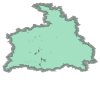

In [9]:
boundary = gdf_polygons.dissolve().iloc[0].geometry
boundary

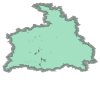

In [29]:
boundary

In [22]:
gpd.GeoDataFrame(geometry=[boundary]).to_file("data/tmp/boundary.geojson", driver="GeoJSON")

In [10]:
#!rm -rf data/tmp/

In [36]:
# To determin if the building intersects, use the tiles_in_polygon function
# to get a bounding box in terms of map tiles at a certain zoom level


# Our DSM does have a higher zoom but for simplicity, I'll use the same 
# zoom for both

def tiles_in_polygon_simple(geometry, zoom):
    w, n, e, s = geometry.bounds
    minx, miny = deg2num(w, s, zoom)
    maxx, maxy = deg2num(e, n, zoom)
    return [(x, y, zoom) for x in range(minx, maxx+1) for y in range(miny, maxy+1)]

def tiles_in_polygon(geometry, zoom, tile_footprint_filepath=None):
    w, n, e, s = geometry.bounds
    minx, miny = deg2num(w, s, zoom)
    maxx, maxy = deg2num(e, n, zoom)
    tiles = []
    geometries = []
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            tile_boundary = get_tile_boundary(x, y, zoom)
            if tile_boundary.intersects(geometry):
                tiles.append((x, y, zoom))
                geometries.append(tile_boundary)
    if tile_footprint_filepath:
        gpd.GeoDataFrame(geometry=geometries).to_file(tile_footprint_filepath)
    return tiles

import requests
from PIL import Image
import pickle
import os
import io

class NoImageReturnedError(Exception):
    pass

def get_tile(x, y, zoom, api, token, aoi = None, layer="bluesky-ultra", local_path=None, **kwargs):
    """
    For background on how tiles are named according to x, y and zoom, see 
    https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

    For more detail on each of the parameters below, see our documenation 
    https://vexcel.atlassian.net/wiki/spaces/APIDOCS/pages/2131887188/GetOrthoImageTile+Service+-+v1.4#Parameters

    without using local path: 936 ms ± 586 ms
    using local path: 94.4 µs ± 2.41 µs per loop

    :param x: The x coordinate of the tile. (Datum: WGS84)
    :param y: The y coordinate of the tile. (Datum: WGS84)
    :param zoom: The zoom level of the tile. 
    :param api: the API endpoint
    :param layer: the name of the layer
    :param kwargs: optional keyword arguments to be passed directly into the API call
    :returns: this is a description of what is returned
    """

    if local_path:
        if len(kwargs) > 0:
            raise NotImplementedError("local path naming won't work with **kwargs")
        tile_folder = os.path.join(local_path, api, layer, f"{zoom}/{x}/{y}")
        tile_name = "tile.pckl"
        tile_path = os.path.join(tile_folder, tile_name)
        if os.path.exists(tile_path):
            with open(tile_path, "rb") as fp:
                return pickle.load(fp)
        os.makedirs(tile_folder, exist_ok=True)
        
    
    if api == "GetDSMTile" or api == "GetDTMTile": 
        url = f"https://api.gic.org/images/{api}/{zoom}/{x}/{y}?token={token}"
        url += f"&layer={layer}"
        if len(kwargs) > 0:
            url += "&" + "&".join([f"{k}={v}" for k, v in kwargs.items()])
        if aoi:
            url += f"&AOI={aoi}"
        response = requests.get(url)
        if response.status_code != 200:
            raise NoImageReturnedError
        image = Image.open(io.BytesIO(response.content))
    else:
        url = f"https://api.gic.org/images/{api}/{layer}/{zoom}/{x}/{y}?token={token}" 
        if len(kwargs) > 0:
            url += "&" + "&".join([f"{k}={v}" for k, v in kwargs.items()])
        if aoi:
            url += f"&AOI={aoi}"
        response = requests.get(url, stream = True)
        if response.status_code != 200:
            raise NoImageReturnedError
        image = Image.open(response.raw)
    if local_path:
        with open(tile_path, "wb") as fp:
            pickle.dump(image, fp)
    return image

In [12]:
api_name = "DSMCoverage"
layer_name = "bluesky-high-europe"
url = f"https://api.gic.org/metadata/{api_name}/?token={token}&layer={layer_name}"
r = requests.get(url)
gpd.GeoDataFrame.from_features(r.json()['features'])

KeyError: 'features'

In [13]:
boundary.centroid.wkt

'POINT (9.628894731785454 49.01593196132184)'

In [30]:
import requests

zoom = 16
x_tile, y_tile = deg2num(9.628894731785454, 49.01593196132184, zoom)
x_tile, y_tile = 34360, 22616

dsm_url = f"https://api.gic.org/images/GetDSMTile/{zoom}/{x_tile}/{y_tile}?token={token}&layer=bluesky-high-europe"
dtm_url = f"https://api.gic.org/images/GetDTMTile/{zoom}/{x_tile}/{y_tile}?token={token}&layer=bluesky-high-europe"
ortho_url = f"https://api.gic.org/images/GetOrthoImageTile/bluesky-high-europe/{zoom}/{x_tile}/{y_tile}?token={token}"

r = requests.get(dsm_url)
print("DSM: ", r.status_code, r.reason, dsm_url.replace(token, "{token}"))

r = requests.get(ortho_url)
print("Ortho: ", r.status_code, r.reason, ortho_url)
print(x_tile, y_tile)

DSM:  404 Not Found https://api.gic.org/images/GetDSMTile/16/34360/22616?token={token}&layer=bluesky-high-europe
Ortho:  200 OK https://api.gic.org/images/GetOrthoImageTile/bluesky-high-europe/16/34360/22616?token=18ce4021b30866171cce26cc203d41e513a7fe0054e12cb9aace39cf0c528f7009c2996f260215079bee8dfff1ec112587d8aecd4098fa0157a73b34dbf4d39ce573cb00e36edf1eeda334c374fbd807fa55a02f8d3f98d7
34360 22616


In [ ]:
aoi = "EUEUCON1901"
aoi

For each building footprint, do the following:
- for each tile that intersects it, download the tile if we haven't already
- write them down with the geospatial bounds
- read them into a sinlge raster
- crop the raster to the building
- run the QA analysis
- add a score to the BP feature

In [31]:

from sqlalchemy import create_engine
import geopandas as gpd
import os
import shapely
from shapely.geometry import Polygon, MultiPolygon

#TODO: add requirements to environment.yml AND factor the 3D conversion into a function
# pip install geoalchemy2 psycopg2 sqlalchemy

psql_url = "postgresql://localhost:5432"
engine = create_engine(psql_url)

In [32]:
from shapely.geometry import Point

def degrees_per_pixel(bounds, pixels_wide, pixels_high):
    width_in_deg = bounds[2] - bounds[0]
    height_in_deg = bounds[3] - bounds[1]

    deg_per_pixel_wide = width_in_deg/pixels_wide
    deg_per_pixel_high = height_in_deg/pixels_high
    return deg_per_pixel_wide, deg_per_pixel_high

def pixel_to_coord(p_x, p_y, bounds, deg_per_pixel_wide, deg_per_pixel_high):
    c_x = bounds[0] + p_x*deg_per_pixel_wide
    c_y = bounds[1] + (255-p_y)*deg_per_pixel_high
    return [ c_x, c_y]


def process_elevations(x_tile, y_tile, zoom, layer):
    dsm_array = np.array(get_tile(x_tile, y_tile, zoom, "GetDSMTile", token, layer=layer, local_path="./data/tmp/tagging_attempt"))
    dtm_array = np.array(get_tile(x_tile, y_tile, zoom, "GetDTMTile", token, layer=layer, local_path="./data/tmp/tagging_attempt"))
    height_array = dsm_array - dtm_array
    w, h = height_array.shape
    bounds = get_tile_boundary(x_tile, y_tile, zoom).bounds
    deg_per_pixel_wide, deg_per_pixel_high = degrees_per_pixel(bounds, w, h)
    points = []
    for x_pixel in range(w):
        for y_pixel in range(h):
            points.append([x_tile, y_tile, zoom, height_array[y_pixel, x_pixel], Point(*pixel_to_coord(x_pixel, y_pixel, bounds, deg_per_pixel_wide, deg_per_pixel_high))])


    gdf_points = gpd.GeoDataFrame(points, columns=["x_tile", "y_tile", "zoom", "height_m", "geometry"])
    gdf_points = gdf_points.set_crs(epsg=4326)
    gdf_points.to_postgis(name=f"points_with_elevation_zoom_{zoom}", con=engine, if_exists="append")

In [17]:
import psycopg2
conn = psycopg2.connect()
curs = conn.cursor()

In [18]:
zoom = 16
sql = f"create table points_with_elevation_zoom_{zoom} (id serial, name varchar, geom geometry(GEOMETRY, 4326));"
curs.execute(sql);

In [34]:
from vdp_python_tools.tile_math import tiles_in_polygon

tiles = tiles_in_polygon(boundary, 16)

In [38]:
successes = set([])
failures = set([])

In [20]:
len(tiles), boundary.centroid.coords[0]

(67135, (9.628894731785454, 49.01593196132184))

In [ ]:

#counter = 0
for x, y, _ in tiles:
    key = f"{x}-{y}-{zoom}"
    counter += 1
    try:
        process_elevations(x, y, zoom, "bluesky-high-europe")
        print(f"Success at {zoom}/{x}/{y}")
        successes.add(key)
    except NoImageReturnedError:
        print(f"Failure at {zoom}/{x}/{y}")
        failures.add(key)
    if counter % 100 == 0: print(counter)
        


Failure at 16/34360/22616
Failure at 16/34360/22617
Failure at 16/34360/22618
Failure at 16/34361/22615
Failure at 16/34361/22616
Failure at 16/34361/22617
Failure at 16/34361/22618
Failure at 16/34361/22619
Failure at 16/34361/22620
Failure at 16/34361/22621
Failure at 16/34361/22622
Failure at 16/34361/22623
Failure at 16/34361/22624
Failure at 16/34361/22625
Failure at 16/34362/22615
Failure at 16/34362/22616
Failure at 16/34362/22617
Failure at 16/34362/22618
Failure at 16/34362/22619
Failure at 16/34362/22620
Failure at 16/34362/22621
Failure at 16/34362/22622
Failure at 16/34362/22623
Failure at 16/34362/22624
Failure at 16/34362/22625
Failure at 16/34362/22626
Failure at 16/34362/22627
Failure at 16/34362/22628
Failure at 16/34362/22629
Failure at 16/34362/22631
Failure at 16/34362/22632
Failure at 16/34362/22633
Failure at 16/34362/22634
Failure at 16/34362/22635
Failure at 16/34362/22636
Failure at 16/34362/22637
Failure at 16/34363/22615
Failure at 16/34363/22616
Failure at 1

Failure at 16/34371/22639
Failure at 16/34371/22640
Failure at 16/34371/22641
Failure at 16/34371/22642
Success at 16/34372/22453
Success at 16/34372/22454
Success at 16/34372/22455
Success at 16/34372/22456
Success at 16/34372/22457
Success at 16/34372/22458
Success at 16/34372/22459
Success at 16/34372/22460
Failure at 16/34372/22566
Failure at 16/34372/22567
Failure at 16/34372/22568
Failure at 16/34372/22569
Failure at 16/34372/22570
Failure at 16/34372/22571
Failure at 16/34372/22599
Failure at 16/34372/22600
Failure at 16/34372/22601
Failure at 16/34372/22602
Failure at 16/34372/22603
Failure at 16/34372/22604
Failure at 16/34372/22605
Failure at 16/34372/22606
Failure at 16/34372/22607
Failure at 16/34372/22608
Failure at 16/34372/22609
Failure at 16/34372/22610
Failure at 16/34372/22611
Failure at 16/34372/22612
Failure at 16/34372/22613
Failure at 16/34372/22614
Failure at 16/34372/22615
Failure at 16/34372/22616
Failure at 16/34372/22617
Failure at 16/34372/22618
Failure at 1

Failure at 16/34376/22595
Failure at 16/34376/22596
Failure at 16/34376/22597
Failure at 16/34376/22598
Failure at 16/34376/22599
Failure at 16/34376/22600
Failure at 16/34376/22601
Failure at 16/34376/22602
Failure at 16/34376/22603
Failure at 16/34376/22604
Failure at 16/34376/22605
Failure at 16/34376/22606
Failure at 16/34376/22607
Failure at 16/34376/22608
Failure at 16/34376/22609
Failure at 16/34376/22610
Failure at 16/34376/22611
Failure at 16/34376/22612
Failure at 16/34376/22613
Failure at 16/34376/22614
Failure at 16/34376/22615
Failure at 16/34376/22616
Failure at 16/34376/22617
Failure at 16/34376/22618
Failure at 16/34376/22619
Failure at 16/34376/22620
Failure at 16/34376/22621
Failure at 16/34376/22622
Failure at 16/34376/22623
Failure at 16/34376/22624
Failure at 16/34376/22625
Failure at 16/34376/22626
Failure at 16/34376/22627
Failure at 16/34376/22628
Failure at 16/34376/22629
Failure at 16/34376/22630
Failure at 16/34376/22631
Failure at 16/34376/22632
Failure at 1

Success at 16/34380/22467
Success at 16/34380/22468
Failure at 16/34380/22563
Failure at 16/34380/22564
Failure at 16/34380/22565
Failure at 16/34380/22566
Failure at 16/34380/22567
Failure at 16/34380/22568
Failure at 16/34380/22569
Failure at 16/34380/22570
Failure at 16/34380/22571
Failure at 16/34380/22572
Failure at 16/34380/22573
Failure at 16/34380/22574
Failure at 16/34380/22575
Failure at 16/34380/22576
Failure at 16/34380/22577
Failure at 16/34380/22578
Failure at 16/34380/22579
Failure at 16/34380/22580
Failure at 16/34380/22586
Failure at 16/34380/22587
Failure at 16/34380/22591
Failure at 16/34380/22592
Failure at 16/34380/22593
Failure at 16/34380/22594
Failure at 16/34380/22595
Failure at 16/34380/22596
Failure at 16/34380/22597
Failure at 16/34380/22598
Failure at 16/34380/22599
Failure at 16/34380/22600
Failure at 16/34380/22601
Failure at 16/34380/22602
Failure at 16/34380/22603
Failure at 16/34380/22604
Failure at 16/34380/22605
Failure at 16/34380/22606
Failure at 1

Failure at 16/34383/22594
Failure at 16/34383/22595
Failure at 16/34383/22596
Failure at 16/34383/22597
Failure at 16/34383/22598
Failure at 16/34383/22599
Failure at 16/34383/22600
Failure at 16/34383/22601
Failure at 16/34383/22602
Failure at 16/34383/22603
Failure at 16/34383/22604
Failure at 16/34383/22605
Failure at 16/34383/22606
Failure at 16/34383/22607
Failure at 16/34383/22608
Failure at 16/34383/22609
Failure at 16/34383/22610
Failure at 16/34383/22611
Failure at 16/34383/22612
Failure at 16/34383/22613
Failure at 16/34383/22614
Failure at 16/34383/22615
Failure at 16/34383/22616
Failure at 16/34383/22617
Failure at 16/34383/22618
Failure at 16/34383/22619
Failure at 16/34383/22620
Failure at 16/34383/22621
Failure at 16/34383/22622
Failure at 16/34383/22623
Failure at 16/34383/22624
Failure at 16/34383/22625
Failure at 16/34383/22626
Failure at 16/34383/22627
Failure at 16/34383/22628
Failure at 16/34383/22629
Failure at 16/34383/22630
5000
Failure at 16/34383/22631
Failure

Success at 16/34386/22486
Success at 16/34386/22487
Success at 16/34386/22488
Success at 16/34386/22489
Success at 16/34386/22490
Success at 16/34386/22491
Success at 16/34386/22492
Success at 16/34386/22493
Success at 16/34386/22494
Success at 16/34386/22495
Success at 16/34386/22496
Success at 16/34386/22497
Failure at 16/34386/22549
Failure at 16/34386/22550
Failure at 16/34386/22551
Failure at 16/34386/22552
Failure at 16/34386/22553
Failure at 16/34386/22554
Failure at 16/34386/22555
Failure at 16/34386/22558
Failure at 16/34386/22559
Failure at 16/34386/22560
5300
Failure at 16/34386/22561
Failure at 16/34386/22562
Failure at 16/34386/22563
Failure at 16/34386/22564
Failure at 16/34386/22565
Failure at 16/34386/22566
Failure at 16/34386/22567
Failure at 16/34386/22568
Failure at 16/34386/22569
Failure at 16/34386/22570
Failure at 16/34386/22571
Failure at 16/34386/22572
Failure at 16/34386/22573
Failure at 16/34386/22574
Failure at 16/34386/22575
Failure at 16/34386/22576
Failure

Failure at 16/34388/22576
Failure at 16/34388/22577
Failure at 16/34388/22578
Failure at 16/34388/22579
Failure at 16/34388/22580
Failure at 16/34388/22581
Failure at 16/34388/22582
5600
Failure at 16/34388/22583
Failure at 16/34388/22584
Failure at 16/34388/22585
Failure at 16/34388/22586
Failure at 16/34388/22587
Failure at 16/34388/22588
Failure at 16/34388/22589
Failure at 16/34388/22590
Failure at 16/34388/22591
Failure at 16/34388/22592
Failure at 16/34388/22593
Failure at 16/34388/22594
Failure at 16/34388/22595
Failure at 16/34388/22596
Failure at 16/34388/22597
Failure at 16/34388/22598
Failure at 16/34388/22599
Failure at 16/34388/22600
Failure at 16/34388/22601
Failure at 16/34388/22602
Failure at 16/34388/22603
Failure at 16/34388/22604
Failure at 16/34388/22605
Failure at 16/34388/22606
Failure at 16/34388/22607
Failure at 16/34388/22608
Failure at 16/34388/22609
Failure at 16/34388/22610
Failure at 16/34388/22611
Failure at 16/34388/22612
Failure at 16/34388/22613
Failure

Failure at 16/34390/22595
Failure at 16/34390/22596
Failure at 16/34390/22597
Failure at 16/34390/22598
Failure at 16/34390/22599
Failure at 16/34390/22600
Failure at 16/34390/22601
Failure at 16/34390/22602
Failure at 16/34390/22603
Failure at 16/34390/22604
Failure at 16/34390/22605
Failure at 16/34390/22606
Failure at 16/34390/22607
Failure at 16/34390/22608
Failure at 16/34390/22609
Failure at 16/34390/22610
Failure at 16/34390/22611
Failure at 16/34390/22612
Failure at 16/34390/22613
Failure at 16/34390/22614
Failure at 16/34390/22615
Failure at 16/34390/22616
Failure at 16/34390/22617
Failure at 16/34390/22618
Failure at 16/34390/22619
Failure at 16/34390/22620
Failure at 16/34390/22621
Failure at 16/34390/22622
Failure at 16/34390/22623
Failure at 16/34390/22624
Success at 16/34391/22445
Success at 16/34391/22446
Success at 16/34391/22447
Success at 16/34391/22448
Success at 16/34391/22449
Success at 16/34391/22450
Success at 16/34391/22451
Success at 16/34391/22452
Success at 1

Failure at 16/34392/22585
Failure at 16/34392/22586
Failure at 16/34392/22587
Failure at 16/34392/22588
Failure at 16/34392/22589
Failure at 16/34392/22590
Failure at 16/34392/22591
Failure at 16/34392/22592
Failure at 16/34392/22593
Failure at 16/34392/22594
Failure at 16/34392/22595
Failure at 16/34392/22596
Failure at 16/34392/22597
Failure at 16/34392/22598
Failure at 16/34392/22599
Failure at 16/34392/22600
Failure at 16/34392/22601
Failure at 16/34392/22602
Failure at 16/34392/22603
Failure at 16/34392/22604
Failure at 16/34392/22605
Failure at 16/34392/22606
Failure at 16/34392/22607
Failure at 16/34392/22608
Failure at 16/34392/22609
Failure at 16/34392/22610
Failure at 16/34392/22611
Failure at 16/34392/22612
Failure at 16/34392/22613
Failure at 16/34392/22614
Failure at 16/34392/22615
Failure at 16/34392/22616
Failure at 16/34392/22617
Failure at 16/34392/22618
Failure at 16/34392/22619
Failure at 16/34392/22620
Failure at 16/34392/22621
Failure at 16/34392/22622
Failure at 1

Failure at 16/34394/22554
Failure at 16/34394/22555
Failure at 16/34394/22556
Failure at 16/34394/22557
Failure at 16/34394/22558
Failure at 16/34394/22559
Failure at 16/34394/22560
Failure at 16/34394/22561
Failure at 16/34394/22562
Failure at 16/34394/22563
Failure at 16/34394/22564
Failure at 16/34394/22565
Failure at 16/34394/22566
Failure at 16/34394/22567
Failure at 16/34394/22568
Failure at 16/34394/22569
Failure at 16/34394/22570
Failure at 16/34394/22571
Failure at 16/34394/22572
Failure at 16/34394/22573
Failure at 16/34394/22574
Failure at 16/34394/22575
Failure at 16/34394/22576
Failure at 16/34394/22577
Failure at 16/34394/22578
Failure at 16/34394/22579
Failure at 16/34394/22580
Failure at 16/34394/22581
Failure at 16/34394/22582
Failure at 16/34394/22583
Failure at 16/34394/22584
Failure at 16/34394/22585
Failure at 16/34394/22586
Failure at 16/34394/22587
Failure at 16/34394/22588
Failure at 16/34394/22589
Failure at 16/34394/22590
Failure at 16/34394/22591
Failure at 1

Failure at 16/34396/22511
Failure at 16/34396/22512
Failure at 16/34396/22513
Failure at 16/34396/22514
Failure at 16/34396/22515
Failure at 16/34396/22516
Failure at 16/34396/22517
Failure at 16/34396/22518
Failure at 16/34396/22519
Failure at 16/34396/22520
Failure at 16/34396/22521
Failure at 16/34396/22522
Failure at 16/34396/22523
Failure at 16/34396/22524
Failure at 16/34396/22525
Failure at 16/34396/22526
Failure at 16/34396/22527
Failure at 16/34396/22528
Failure at 16/34396/22529
Failure at 16/34396/22530
Failure at 16/34396/22531
Failure at 16/34396/22532
Failure at 16/34396/22533
Failure at 16/34396/22534
Failure at 16/34396/22535
Failure at 16/34396/22536
Failure at 16/34396/22537
Failure at 16/34396/22538
Failure at 16/34396/22539
Failure at 16/34396/22540
Failure at 16/34396/22541
Failure at 16/34396/22542
Failure at 16/34396/22543
Failure at 16/34396/22544
Failure at 16/34396/22545
Failure at 16/34396/22546
Failure at 16/34396/22547
Failure at 16/34396/22548
Failure at 1

Success at 16/34398/22465
Success at 16/34398/22466
Success at 16/34398/22467
Success at 16/34398/22468
Success at 16/34398/22469
Success at 16/34398/22470
Success at 16/34398/22471
Success at 16/34398/22472
Success at 16/34398/22473
Success at 16/34398/22474
Success at 16/34398/22475
Success at 16/34398/22476
Success at 16/34398/22477
Success at 16/34398/22478
Success at 16/34398/22479
Success at 16/34398/22480
Success at 16/34398/22481
Success at 16/34398/22482
Success at 16/34398/22483
Success at 16/34398/22484
Success at 16/34398/22485
Success at 16/34398/22486
Success at 16/34398/22487
Success at 16/34398/22488
Success at 16/34398/22489
Success at 16/34398/22490
Success at 16/34398/22491
Success at 16/34398/22492
Success at 16/34398/22493
Success at 16/34398/22494
Success at 16/34398/22495
Success at 16/34398/22496
7200
Success at 16/34398/22497
Success at 16/34398/22498
Success at 16/34398/22499
Success at 16/34398/22500
Success at 16/34398/22501
Success at 16/34398/22502
Success

Failure at 16/34399/22600
Failure at 16/34399/22601
Failure at 16/34399/22602
Failure at 16/34399/22603
Failure at 16/34399/22604
Failure at 16/34399/22605
Failure at 16/34399/22606
Failure at 16/34399/22607
Failure at 16/34399/22608
Failure at 16/34399/22609
Failure at 16/34399/22610
Failure at 16/34399/22611
Failure at 16/34399/22612
Failure at 16/34399/22613
Failure at 16/34399/22614
Failure at 16/34399/22615
Failure at 16/34399/22616
7500
Failure at 16/34399/22617
Failure at 16/34399/22618
Failure at 16/34399/22619
Failure at 16/34399/22620
Failure at 16/34399/22621
Failure at 16/34400/22440
Failure at 16/34400/22441
Failure at 16/34400/22442
Failure at 16/34400/22443
Failure at 16/34400/22444
Failure at 16/34400/22445
Failure at 16/34400/22446
Failure at 16/34400/22447
Failure at 16/34400/22448
Failure at 16/34400/22449
Failure at 16/34400/22450
Failure at 16/34400/22451
Failure at 16/34400/22452
Failure at 16/34400/22453
Failure at 16/34400/22454
Failure at 16/34400/22455
Failure

Failure at 16/34401/22552
Failure at 16/34401/22553
7800
Failure at 16/34401/22554
Failure at 16/34401/22555
Failure at 16/34401/22556
Failure at 16/34401/22557
Failure at 16/34401/22558
Failure at 16/34401/22559
Failure at 16/34401/22560
Failure at 16/34401/22561
Failure at 16/34401/22562
Failure at 16/34401/22563
Failure at 16/34401/22564
Failure at 16/34401/22565
Failure at 16/34401/22566
Failure at 16/34401/22567
Failure at 16/34401/22568
Failure at 16/34401/22569
Failure at 16/34401/22570
Failure at 16/34401/22571
Failure at 16/34401/22572
Failure at 16/34401/22573
Failure at 16/34401/22574
Failure at 16/34401/22575
Failure at 16/34401/22576
Failure at 16/34401/22577
Failure at 16/34401/22578
Failure at 16/34401/22579
Failure at 16/34401/22580
Failure at 16/34401/22581
Failure at 16/34401/22582
Failure at 16/34401/22583
Failure at 16/34401/22584
Failure at 16/34401/22585
Failure at 16/34401/22586
Failure at 16/34401/22587
Failure at 16/34401/22588
Failure at 16/34401/22589
Failure

Failure at 16/34403/22506
Failure at 16/34403/22507
Failure at 16/34403/22508
Failure at 16/34403/22509
Failure at 16/34403/22510
Failure at 16/34403/22511
Failure at 16/34403/22512
Failure at 16/34403/22513
Failure at 16/34403/22514
Failure at 16/34403/22515
Failure at 16/34403/22516
Failure at 16/34403/22517
Failure at 16/34403/22518
Failure at 16/34403/22519
Failure at 16/34403/22520
Failure at 16/34403/22521
Failure at 16/34403/22522
Failure at 16/34403/22523
Failure at 16/34403/22524
Failure at 16/34403/22525
Failure at 16/34403/22526
Failure at 16/34403/22527
Failure at 16/34403/22528
Failure at 16/34403/22529
Failure at 16/34403/22530
Failure at 16/34403/22531
Failure at 16/34403/22532
Failure at 16/34403/22533
Failure at 16/34403/22534
Failure at 16/34403/22535
Failure at 16/34403/22536
Failure at 16/34403/22537
Failure at 16/34403/22538
Failure at 16/34403/22539
Failure at 16/34403/22540
Failure at 16/34403/22541
Failure at 16/34403/22542
Failure at 16/34403/22543
Failure at 1

Failure at 16/34405/22453
Failure at 16/34405/22454
Failure at 16/34405/22455
Failure at 16/34405/22456
Failure at 16/34405/22457
Failure at 16/34405/22458
Failure at 16/34405/22459
Failure at 16/34405/22460
Failure at 16/34405/22461
Failure at 16/34405/22462
Failure at 16/34405/22463
Failure at 16/34405/22464
Failure at 16/34405/22465
Failure at 16/34405/22466
Failure at 16/34405/22467
Failure at 16/34405/22468
Failure at 16/34405/22469
Failure at 16/34405/22470
Failure at 16/34405/22471
Failure at 16/34405/22472
Failure at 16/34405/22473
Failure at 16/34405/22474
Failure at 16/34405/22475
Failure at 16/34405/22476
Failure at 16/34405/22477
Failure at 16/34405/22478
Failure at 16/34405/22479
Failure at 16/34405/22480
Failure at 16/34405/22481
Failure at 16/34405/22482
Failure at 16/34405/22483
Failure at 16/34405/22484
Failure at 16/34405/22485
Failure at 16/34405/22486
Failure at 16/34405/22487
Failure at 16/34405/22488
Failure at 16/34405/22489
Failure at 16/34405/22490
Failure at 1

Failure at 16/34406/22579
Failure at 16/34406/22580
Failure at 16/34406/22581
Failure at 16/34406/22582
Failure at 16/34406/22583
Failure at 16/34406/22584
Failure at 16/34406/22585
Failure at 16/34406/22586
Failure at 16/34406/22587
Failure at 16/34406/22588
Failure at 16/34406/22589
Failure at 16/34406/22590
Failure at 16/34406/22591
Failure at 16/34406/22592
Failure at 16/34406/22593
Failure at 16/34406/22594
Failure at 16/34406/22595
Failure at 16/34406/22596
Failure at 16/34406/22597
Failure at 16/34406/22598
Failure at 16/34406/22599
Failure at 16/34406/22600
Failure at 16/34406/22601
Failure at 16/34406/22602
Failure at 16/34406/22603
Failure at 16/34406/22604
Failure at 16/34406/22605
Failure at 16/34406/22606
Failure at 16/34406/22607
Failure at 16/34406/22608
Failure at 16/34406/22609
Failure at 16/34406/22610
Failure at 16/34406/22611
Failure at 16/34406/22612
Failure at 16/34406/22613
Failure at 16/34406/22614
Failure at 16/34406/22615
Failure at 16/34406/22616
Failure at 1

Failure at 16/34408/22514
Failure at 16/34408/22515
Failure at 16/34408/22516
Failure at 16/34408/22517
Failure at 16/34408/22518
Failure at 16/34408/22519
Failure at 16/34408/22520
Failure at 16/34408/22521
Failure at 16/34408/22522
Failure at 16/34408/22523
Failure at 16/34408/22524
Failure at 16/34408/22525
Failure at 16/34408/22526
Failure at 16/34408/22527
Failure at 16/34408/22528
Failure at 16/34408/22529
Failure at 16/34408/22530
Failure at 16/34408/22531
Failure at 16/34408/22532
Failure at 16/34408/22533
Failure at 16/34408/22534
Failure at 16/34408/22535
Failure at 16/34408/22536
Failure at 16/34408/22537
Failure at 16/34408/22538
Failure at 16/34408/22539
Failure at 16/34408/22540
Failure at 16/34408/22541
Failure at 16/34408/22542
Failure at 16/34408/22543
Failure at 16/34408/22544
Failure at 16/34408/22545
Failure at 16/34408/22546
Failure at 16/34408/22547
Failure at 16/34408/22548
Failure at 16/34408/22549
Failure at 16/34408/22550
Failure at 16/34408/22551
Failure at 1

Failure at 16/34410/22437
Failure at 16/34410/22438
Failure at 16/34410/22439
Failure at 16/34410/22440
Failure at 16/34410/22441
Failure at 16/34410/22442
Failure at 16/34410/22443
Failure at 16/34410/22444
Failure at 16/34410/22445
Failure at 16/34410/22446
Failure at 16/34410/22447
Failure at 16/34410/22448
Failure at 16/34410/22449
Failure at 16/34410/22450
Failure at 16/34410/22451
Failure at 16/34410/22452
Failure at 16/34410/22453
Failure at 16/34410/22454
Failure at 16/34410/22455
Failure at 16/34410/22456
Failure at 16/34410/22457
Failure at 16/34410/22458
Failure at 16/34410/22459
Failure at 16/34410/22460
Failure at 16/34410/22461
Failure at 16/34410/22462
Failure at 16/34410/22463
9400
Failure at 16/34410/22464
Failure at 16/34410/22465
Failure at 16/34410/22466
Failure at 16/34410/22467
Failure at 16/34410/22468
Failure at 16/34410/22469
Failure at 16/34410/22470
Failure at 16/34410/22471
Failure at 16/34410/22472
Failure at 16/34410/22473
Failure at 16/34410/22474
Failure

Failure at 16/34411/22551
Failure at 16/34411/22552
Failure at 16/34411/22553
Failure at 16/34411/22554
Failure at 16/34411/22555
Failure at 16/34411/22556
Failure at 16/34411/22557
Failure at 16/34411/22558
Failure at 16/34411/22559
Failure at 16/34411/22560
Failure at 16/34411/22561
Failure at 16/34411/22562
9700
Failure at 16/34411/22563
Failure at 16/34411/22564
Failure at 16/34411/22565
Failure at 16/34411/22566
Failure at 16/34411/22567
Failure at 16/34411/22568
Failure at 16/34411/22569
Failure at 16/34411/22570
Failure at 16/34411/22571
Failure at 16/34411/22572
Failure at 16/34411/22573
Failure at 16/34411/22574
Failure at 16/34411/22575
Failure at 16/34411/22576
Failure at 16/34411/22577
Failure at 16/34411/22578
Failure at 16/34411/22579
Failure at 16/34411/22580
Failure at 16/34411/22581
Failure at 16/34411/22582
Failure at 16/34411/22583
Failure at 16/34411/22584
Failure at 16/34411/22585
Failure at 16/34411/22586
Failure at 16/34411/22587
Failure at 16/34411/22588
Failure

Failure at 16/34413/22463
Failure at 16/34413/22464
Failure at 16/34413/22465
Failure at 16/34413/22466
Failure at 16/34413/22467
Failure at 16/34413/22468
Failure at 16/34413/22469
Failure at 16/34413/22470
Failure at 16/34413/22471
Failure at 16/34413/22472
Failure at 16/34413/22473
Failure at 16/34413/22474
Failure at 16/34413/22475
Failure at 16/34413/22476
Failure at 16/34413/22477
Failure at 16/34413/22478
Failure at 16/34413/22479
Failure at 16/34413/22480
Failure at 16/34413/22481
Failure at 16/34413/22482
Failure at 16/34413/22483
Failure at 16/34413/22484
Failure at 16/34413/22485
Failure at 16/34413/22486
Failure at 16/34413/22487
Failure at 16/34413/22488
Failure at 16/34413/22489
Failure at 16/34413/22490
Failure at 16/34413/22491
Failure at 16/34413/22492
Failure at 16/34413/22493
Failure at 16/34413/22494
Failure at 16/34413/22495
Failure at 16/34413/22496
Failure at 16/34413/22497
Failure at 16/34413/22498
Failure at 16/34413/22499
Failure at 16/34413/22500
Failure at 1

Failure at 16/34414/22577
Failure at 16/34414/22578
Failure at 16/34414/22579
Failure at 16/34414/22580
Failure at 16/34414/22581
Failure at 16/34414/22582
Failure at 16/34414/22583
Failure at 16/34414/22584
Failure at 16/34414/22585
Failure at 16/34414/22586
Failure at 16/34414/22587
Failure at 16/34414/22588
Failure at 16/34414/22589
Failure at 16/34414/22590
Failure at 16/34414/22591
Failure at 16/34414/22592
Failure at 16/34414/22593
Failure at 16/34414/22594
Failure at 16/34414/22595
Failure at 16/34414/22596
Failure at 16/34414/22597
Failure at 16/34414/22598
Failure at 16/34414/22599
Failure at 16/34414/22600
Failure at 16/34414/22601
Failure at 16/34414/22602
Failure at 16/34414/22603
Failure at 16/34414/22604
Failure at 16/34414/22605
Failure at 16/34414/22606
Failure at 16/34414/22607
Failure at 16/34414/22608
Failure at 16/34414/22609
Failure at 16/34414/22610
Failure at 16/34414/22611
Failure at 16/34414/22612
Failure at 16/34414/22613
Failure at 16/34414/22614
Failure at 1

Failure at 16/34416/22499
Failure at 16/34416/22500
Failure at 16/34416/22501
Failure at 16/34416/22502
Failure at 16/34416/22503
Failure at 16/34416/22504
Failure at 16/34416/22505
Failure at 16/34416/22506
Failure at 16/34416/22507
Failure at 16/34416/22508
Failure at 16/34416/22509
Failure at 16/34416/22510
Failure at 16/34416/22511
Failure at 16/34416/22512
Failure at 16/34416/22513
Failure at 16/34416/22514
Failure at 16/34416/22515
Failure at 16/34416/22516
Failure at 16/34416/22517
Failure at 16/34416/22518
Failure at 16/34416/22519
Failure at 16/34416/22520
Failure at 16/34416/22521
Failure at 16/34416/22522
Failure at 16/34416/22523
Failure at 16/34416/22524
Failure at 16/34416/22525
Failure at 16/34416/22526
Failure at 16/34416/22527
Failure at 16/34416/22528
Failure at 16/34416/22529
Failure at 16/34416/22530
Failure at 16/34416/22531
Failure at 16/34416/22532
Failure at 16/34416/22533
Failure at 16/34416/22534
Failure at 16/34416/22535
Failure at 16/34416/22536
Failure at 1

Failure at 16/34417/22619
Failure at 16/34418/22425
Failure at 16/34418/22426
Failure at 16/34418/22427
Failure at 16/34418/22428
Failure at 16/34418/22429
Failure at 16/34418/22430
Failure at 16/34418/22431
Failure at 16/34418/22432
Failure at 16/34418/22433
Failure at 16/34418/22434
Failure at 16/34418/22435
Failure at 16/34418/22436
Failure at 16/34418/22437
Failure at 16/34418/22438
Failure at 16/34418/22439
Failure at 16/34418/22440
Failure at 16/34418/22441
Failure at 16/34418/22442
Failure at 16/34418/22443
Failure at 16/34418/22444
Failure at 16/34418/22445
Failure at 16/34418/22446
Failure at 16/34418/22447
Failure at 16/34418/22448
Failure at 16/34418/22449
Failure at 16/34418/22450
Failure at 16/34418/22451
Failure at 16/34418/22452
Failure at 16/34418/22453
Failure at 16/34418/22454
Failure at 16/34418/22455
Failure at 16/34418/22456
Failure at 16/34418/22457
Failure at 16/34418/22458
Failure at 16/34418/22459
Failure at 16/34418/22460
Failure at 16/34418/22461
Failure at 1

Failure at 16/34419/22545
Failure at 16/34419/22546
Failure at 16/34419/22547
Failure at 16/34419/22548
Failure at 16/34419/22549
Failure at 16/34419/22550
Failure at 16/34419/22551
Failure at 16/34419/22552
Failure at 16/34419/22553
Failure at 16/34419/22554
Failure at 16/34419/22555
Failure at 16/34419/22556
Failure at 16/34419/22557
Failure at 16/34419/22558
Failure at 16/34419/22559
Failure at 16/34419/22560
Failure at 16/34419/22561
Failure at 16/34419/22562
Failure at 16/34419/22563
Failure at 16/34419/22564
Failure at 16/34419/22565
Failure at 16/34419/22566
Failure at 16/34419/22567
Failure at 16/34419/22568
Failure at 16/34419/22569
Failure at 16/34419/22570
Failure at 16/34419/22571
Failure at 16/34419/22572
Failure at 16/34419/22573
Failure at 16/34419/22574
Failure at 16/34419/22575
Failure at 16/34419/22576
Failure at 16/34419/22577
Failure at 16/34419/22578
Failure at 16/34419/22579
Failure at 16/34419/22580
Failure at 16/34419/22581
11300
Failure at 16/34419/22582
Failur

Failure at 16/34421/22475
Failure at 16/34421/22476
Failure at 16/34421/22477
Failure at 16/34421/22478
Failure at 16/34421/22479
Failure at 16/34421/22480
Failure at 16/34421/22481
Failure at 16/34421/22482
Failure at 16/34421/22483
Failure at 16/34421/22484
Failure at 16/34421/22485
Failure at 16/34421/22486
Failure at 16/34421/22487
Failure at 16/34421/22488
Failure at 16/34421/22489
Failure at 16/34421/22490
Failure at 16/34421/22491
Failure at 16/34421/22492
Failure at 16/34421/22493
Failure at 16/34421/22494
Failure at 16/34421/22495
Failure at 16/34421/22496
11600
Failure at 16/34421/22497
Failure at 16/34421/22498
Failure at 16/34421/22499
Failure at 16/34421/22500
Failure at 16/34421/22501
Failure at 16/34421/22502
Failure at 16/34421/22503
Failure at 16/34421/22504
Failure at 16/34421/22505
Failure at 16/34421/22506
Failure at 16/34421/22507
Failure at 16/34421/22508
Failure at 16/34421/22509
Failure at 16/34421/22510
Failure at 16/34421/22511
Failure at 16/34421/22512
Failur

Failure at 16/34422/22599
Failure at 16/34422/22600
Failure at 16/34422/22601
Failure at 16/34422/22602
Failure at 16/34422/22603
Failure at 16/34422/22604
Failure at 16/34422/22605
11900
Failure at 16/34422/22606
Failure at 16/34422/22607
Failure at 16/34422/22608
Failure at 16/34422/22609
Failure at 16/34422/22610
Failure at 16/34422/22611
Failure at 16/34422/22612
Failure at 16/34422/22613
Failure at 16/34422/22614
Failure at 16/34422/22615
Failure at 16/34422/22616
Failure at 16/34423/22427
Failure at 16/34423/22428
Failure at 16/34423/22429
Failure at 16/34423/22430
Failure at 16/34423/22431
Failure at 16/34423/22432
Failure at 16/34423/22433
Failure at 16/34423/22434
Failure at 16/34423/22435
Failure at 16/34423/22436
Failure at 16/34423/22437
Failure at 16/34423/22438
Failure at 16/34423/22439
Failure at 16/34423/22440
Failure at 16/34423/22441
Failure at 16/34423/22442
Failure at 16/34423/22443
Failure at 16/34423/22444
Failure at 16/34423/22445
Failure at 16/34423/22446
Failur

Failure at 16/34424/22534
Failure at 16/34424/22535
Failure at 16/34424/22536
Failure at 16/34424/22537
Failure at 16/34424/22538
Failure at 16/34424/22539
Failure at 16/34424/22540
Failure at 16/34424/22541
Failure at 16/34424/22542
Failure at 16/34424/22543
Failure at 16/34424/22544
Failure at 16/34424/22545
Failure at 16/34424/22546
Failure at 16/34424/22547
Failure at 16/34424/22548
Failure at 16/34424/22549
Failure at 16/34424/22550
Failure at 16/34424/22551
Failure at 16/34424/22552
Failure at 16/34424/22553
Failure at 16/34424/22554
Failure at 16/34424/22555
Failure at 16/34424/22556
Failure at 16/34424/22557
Failure at 16/34424/22558
Failure at 16/34424/22559
Failure at 16/34424/22560
Failure at 16/34424/22561
Failure at 16/34424/22562
Failure at 16/34424/22563
Failure at 16/34424/22564
Failure at 16/34424/22565
Failure at 16/34424/22566
Failure at 16/34424/22567
Failure at 16/34424/22568
Failure at 16/34424/22569
Failure at 16/34424/22570
Failure at 16/34424/22571
Failure at 1

Failure at 16/34426/22469
Failure at 16/34426/22470
Failure at 16/34426/22471
Failure at 16/34426/22472
Failure at 16/34426/22473
Failure at 16/34426/22474
Failure at 16/34426/22475
Failure at 16/34426/22476
Failure at 16/34426/22477
Failure at 16/34426/22478
Failure at 16/34426/22479
Failure at 16/34426/22480
Failure at 16/34426/22481
Failure at 16/34426/22482
Failure at 16/34426/22483
Failure at 16/34426/22484
Failure at 16/34426/22485
Failure at 16/34426/22486
Failure at 16/34426/22487
Failure at 16/34426/22488
Failure at 16/34426/22489
Failure at 16/34426/22490
Failure at 16/34426/22491
Failure at 16/34426/22492
Failure at 16/34426/22493
Failure at 16/34426/22494
Failure at 16/34426/22495
Failure at 16/34426/22496
Failure at 16/34426/22497
Failure at 16/34426/22498
Failure at 16/34426/22499
Failure at 16/34426/22500
Failure at 16/34426/22501
Failure at 16/34426/22502
Failure at 16/34426/22503
Failure at 16/34426/22504
Failure at 16/34426/22505
Failure at 16/34426/22506
Failure at 1

Failure at 16/34427/22595
Failure at 16/34427/22596
Failure at 16/34427/22597
Failure at 16/34427/22598
Failure at 16/34427/22599
Failure at 16/34427/22600
Failure at 16/34427/22601
Failure at 16/34427/22602
Failure at 16/34427/22603
Failure at 16/34427/22604
Failure at 16/34427/22605
Failure at 16/34427/22606
Failure at 16/34427/22607
Failure at 16/34427/22608
Failure at 16/34427/22609
Failure at 16/34427/22610
Failure at 16/34427/22611
Failure at 16/34427/22612
Failure at 16/34427/22613
Failure at 16/34427/22614
Failure at 16/34427/22615
Failure at 16/34427/22616
Failure at 16/34428/22428
Failure at 16/34428/22430
Failure at 16/34428/22431
Failure at 16/34428/22432
Failure at 16/34428/22433
Failure at 16/34428/22434
Failure at 16/34428/22435
Failure at 16/34428/22436
Failure at 16/34428/22437
Failure at 16/34428/22438
Failure at 16/34428/22439
Failure at 16/34428/22440
Failure at 16/34428/22441
Failure at 16/34428/22442
Failure at 16/34428/22443
Failure at 16/34428/22444
Failure at 1

Failure at 16/34429/22534
Failure at 16/34429/22535
Failure at 16/34429/22536
Failure at 16/34429/22537
Failure at 16/34429/22538
Failure at 16/34429/22539
Failure at 16/34429/22540
Failure at 16/34429/22541
Failure at 16/34429/22542
Failure at 16/34429/22543
Failure at 16/34429/22544
Failure at 16/34429/22545
Failure at 16/34429/22546
Failure at 16/34429/22547
Failure at 16/34429/22548
Failure at 16/34429/22549
Failure at 16/34429/22550
Failure at 16/34429/22551
Failure at 16/34429/22552
Failure at 16/34429/22553
Failure at 16/34429/22554
Failure at 16/34429/22555
Failure at 16/34429/22556
Failure at 16/34429/22557
Failure at 16/34429/22558
Failure at 16/34429/22559
Failure at 16/34429/22560
Failure at 16/34429/22561
Failure at 16/34429/22562
Failure at 16/34429/22563
Failure at 16/34429/22564
Failure at 16/34429/22565
Failure at 16/34429/22566
Failure at 16/34429/22567
Failure at 16/34429/22568
Failure at 16/34429/22569
Failure at 16/34429/22570
Failure at 16/34429/22571
Failure at 1

Failure at 16/34431/22465
Failure at 16/34431/22466
Failure at 16/34431/22467
Failure at 16/34431/22468
Failure at 16/34431/22469
Failure at 16/34431/22470
Failure at 16/34431/22471
Failure at 16/34431/22472
Failure at 16/34431/22473
Failure at 16/34431/22474
Failure at 16/34431/22475
Failure at 16/34431/22476
Failure at 16/34431/22477
Failure at 16/34431/22478
Failure at 16/34431/22479
Failure at 16/34431/22480
Failure at 16/34431/22481
Failure at 16/34431/22482
Failure at 16/34431/22483
Failure at 16/34431/22484
Failure at 16/34431/22485
Failure at 16/34431/22486
Failure at 16/34431/22487
Failure at 16/34431/22488
Failure at 16/34431/22489
Failure at 16/34431/22490
Failure at 16/34431/22491
Failure at 16/34431/22492
Failure at 16/34431/22493
Failure at 16/34431/22494
Failure at 16/34431/22495
Failure at 16/34431/22496
13500
Failure at 16/34431/22497
Failure at 16/34431/22498
Failure at 16/34431/22499
Failure at 16/34431/22500
Failure at 16/34431/22501
Failure at 16/34431/22502
Failur

Failure at 16/34432/22586
Failure at 16/34432/22587
Failure at 16/34432/22588
Failure at 16/34432/22589
Failure at 16/34432/22590
Failure at 16/34432/22591
Failure at 16/34432/22592
Failure at 16/34432/22593
Failure at 16/34432/22594
Failure at 16/34432/22595
Failure at 16/34432/22596
Failure at 16/34432/22597
Failure at 16/34432/22598
Failure at 16/34432/22599
Failure at 16/34432/22600
Failure at 16/34432/22601
Failure at 16/34432/22602
13800
Failure at 16/34432/22603
Failure at 16/34432/22604
Failure at 16/34432/22605
Failure at 16/34432/22606
Failure at 16/34432/22607
Failure at 16/34432/22608
Failure at 16/34432/22609
Failure at 16/34432/22610
Failure at 16/34432/22611
Failure at 16/34432/22612
Failure at 16/34432/22613
Failure at 16/34432/22614
Failure at 16/34432/22615
Failure at 16/34432/22616
Failure at 16/34433/22421
Failure at 16/34433/22422
Failure at 16/34433/22423
Failure at 16/34433/22424
Failure at 16/34433/22425
Failure at 16/34433/22429
Failure at 16/34433/22430
Failur

Failure at 16/34434/22511
Failure at 16/34434/22512
14100
Failure at 16/34434/22513
Failure at 16/34434/22514
Failure at 16/34434/22515
Failure at 16/34434/22516
Failure at 16/34434/22517
Failure at 16/34434/22518
Failure at 16/34434/22519
Failure at 16/34434/22520
Failure at 16/34434/22521
Failure at 16/34434/22522
Failure at 16/34434/22523
Failure at 16/34434/22524
Failure at 16/34434/22525
Failure at 16/34434/22526
Failure at 16/34434/22527
Failure at 16/34434/22528
Failure at 16/34434/22529
Failure at 16/34434/22530
Failure at 16/34434/22531
Failure at 16/34434/22532
Failure at 16/34434/22533
Failure at 16/34434/22534
Failure at 16/34434/22535
Failure at 16/34434/22536
Failure at 16/34434/22537
Failure at 16/34434/22538
Failure at 16/34434/22539
Failure at 16/34434/22540
Failure at 16/34434/22541
Failure at 16/34434/22542
Failure at 16/34434/22543
Failure at 16/34434/22544
Failure at 16/34434/22545
Failure at 16/34434/22546
Failure at 16/34434/22547
Failure at 16/34434/22548
Failur

Failure at 16/34436/22423
Failure at 16/34436/22424
Failure at 16/34436/22425
Failure at 16/34436/22426
Failure at 16/34436/22427
Failure at 16/34436/22428
Failure at 16/34436/22429
Failure at 16/34436/22430
Failure at 16/34436/22431
Failure at 16/34436/22432
Failure at 16/34436/22433
Failure at 16/34436/22434
Failure at 16/34436/22435
Failure at 16/34436/22436
Failure at 16/34436/22437
Failure at 16/34436/22438
Failure at 16/34436/22439
Failure at 16/34436/22440
Failure at 16/34436/22441
Failure at 16/34436/22442
Failure at 16/34436/22443
Failure at 16/34436/22444
Failure at 16/34436/22445
Failure at 16/34436/22446
Failure at 16/34436/22447
Failure at 16/34436/22448
Failure at 16/34436/22449
Failure at 16/34436/22450
Failure at 16/34436/22451
Failure at 16/34436/22452
Failure at 16/34436/22453
Failure at 16/34436/22454
Failure at 16/34436/22455
Failure at 16/34436/22456
Failure at 16/34436/22457
Failure at 16/34436/22458
Failure at 16/34436/22459
Failure at 16/34436/22460
Failure at 1

Failure at 16/34437/22536
Failure at 16/34437/22537
Failure at 16/34437/22538
Failure at 16/34437/22539
Failure at 16/34437/22540
Failure at 16/34437/22541
Failure at 16/34437/22542
Failure at 16/34437/22543
Failure at 16/34437/22544
Failure at 16/34437/22545
Failure at 16/34437/22546
Failure at 16/34437/22547
Failure at 16/34437/22548
Failure at 16/34437/22549
Failure at 16/34437/22550
Failure at 16/34437/22551
Failure at 16/34437/22552
Failure at 16/34437/22553
Failure at 16/34437/22554
Failure at 16/34437/22555
Failure at 16/34437/22556
Failure at 16/34437/22557
Failure at 16/34437/22558
Failure at 16/34437/22559
Failure at 16/34437/22560
Failure at 16/34437/22561
Failure at 16/34437/22562
Failure at 16/34437/22563
Failure at 16/34437/22564
Failure at 16/34437/22565
Failure at 16/34437/22566
Failure at 16/34437/22567
Failure at 16/34437/22568
Failure at 16/34437/22569
Failure at 16/34437/22570
Failure at 16/34437/22571
Failure at 16/34437/22572
Failure at 16/34437/22573
Failure at 1

Failure at 16/34439/22448
Failure at 16/34439/22449
Failure at 16/34439/22450
Failure at 16/34439/22451
Failure at 16/34439/22452
Failure at 16/34439/22453
Failure at 16/34439/22454
Failure at 16/34439/22455
Failure at 16/34439/22456
Failure at 16/34439/22457
Failure at 16/34439/22458
Failure at 16/34439/22459
Failure at 16/34439/22460
Failure at 16/34439/22461
Failure at 16/34439/22462
Failure at 16/34439/22463
Failure at 16/34439/22464
Failure at 16/34439/22465
Failure at 16/34439/22466
Failure at 16/34439/22467
Failure at 16/34439/22468
Failure at 16/34439/22469
Failure at 16/34439/22470
Failure at 16/34439/22471
Failure at 16/34439/22472
Failure at 16/34439/22473
Failure at 16/34439/22474
Failure at 16/34439/22475
Failure at 16/34439/22476
Failure at 16/34439/22477
Failure at 16/34439/22478
Failure at 16/34439/22479
Failure at 16/34439/22480
Failure at 16/34439/22481
Failure at 16/34439/22482
Failure at 16/34439/22483
Failure at 16/34439/22484
Failure at 16/34439/22485
Failure at 1

Failure at 16/34440/22561
Failure at 16/34440/22562
Failure at 16/34440/22563
Failure at 16/34440/22564
Failure at 16/34440/22565
Failure at 16/34440/22566
Failure at 16/34440/22567
Failure at 16/34440/22568
Failure at 16/34440/22569
Failure at 16/34440/22570
Failure at 16/34440/22571
Failure at 16/34440/22572
Failure at 16/34440/22573
Failure at 16/34440/22574
Failure at 16/34440/22575
Failure at 16/34440/22576
Failure at 16/34440/22577
Failure at 16/34440/22578
Failure at 16/34440/22579
Failure at 16/34440/22580
Failure at 16/34440/22581
Failure at 16/34440/22582
Failure at 16/34440/22583
Failure at 16/34440/22584
Failure at 16/34440/22585
Failure at 16/34440/22586
Failure at 16/34440/22587
Failure at 16/34440/22588
Failure at 16/34440/22589
Failure at 16/34440/22590
Failure at 16/34440/22591
Failure at 16/34440/22592
Failure at 16/34440/22593
Failure at 16/34440/22594
Failure at 16/34440/22595
Failure at 16/34440/22596
Failure at 16/34440/22597
Failure at 16/34440/22598
Failure at 1

Failure at 16/34442/22470
Failure at 16/34442/22471
Failure at 16/34442/22472
Failure at 16/34442/22473
Failure at 16/34442/22474
Failure at 16/34442/22475
Failure at 16/34442/22476
Failure at 16/34442/22477
Failure at 16/34442/22478
Failure at 16/34442/22479
Failure at 16/34442/22480
Failure at 16/34442/22481
Failure at 16/34442/22482
Failure at 16/34442/22483
Failure at 16/34442/22484
Failure at 16/34442/22485
Failure at 16/34442/22486
Failure at 16/34442/22487
Failure at 16/34442/22488
Failure at 16/34442/22489
Failure at 16/34442/22490
Failure at 16/34442/22491
Failure at 16/34442/22492
Failure at 16/34442/22493
Failure at 16/34442/22494
Failure at 16/34442/22495
Failure at 16/34442/22496
15700
Failure at 16/34442/22497
Failure at 16/34442/22498
Failure at 16/34442/22499
Failure at 16/34442/22500
Failure at 16/34442/22501
Failure at 16/34442/22502
Failure at 16/34442/22503
Failure at 16/34442/22504
Failure at 16/34442/22505
Failure at 16/34442/22506
Failure at 16/34442/22507
Failur

Failure at 16/34443/22580
Failure at 16/34443/22581
Failure at 16/34443/22582
Failure at 16/34443/22583
Failure at 16/34443/22584
Failure at 16/34443/22585
Failure at 16/34443/22586
Failure at 16/34443/22587
Failure at 16/34443/22588
Failure at 16/34443/22589
Failure at 16/34443/22590
Failure at 16/34443/22591
16000
Failure at 16/34443/22592
Failure at 16/34443/22593
Failure at 16/34443/22594
Failure at 16/34443/22595
Failure at 16/34443/22596
Failure at 16/34443/22597
Failure at 16/34443/22598
Failure at 16/34443/22599
Failure at 16/34443/22600
Failure at 16/34443/22601
Failure at 16/34443/22602
Failure at 16/34443/22603
Failure at 16/34443/22604
Failure at 16/34443/22605
Failure at 16/34443/22606
Failure at 16/34443/22607
Failure at 16/34443/22608
Failure at 16/34443/22609
Failure at 16/34443/22610
Failure at 16/34443/22611
Failure at 16/34443/22612
Failure at 16/34443/22613
Failure at 16/34443/22614
Failure at 16/34443/22615
Failure at 16/34443/22618
Failure at 16/34443/22619
Failur

Failure at 16/34445/22480
Failure at 16/34445/22481
Failure at 16/34445/22482
Failure at 16/34445/22483
Failure at 16/34445/22484
Failure at 16/34445/22485
Failure at 16/34445/22486
Failure at 16/34445/22487
Failure at 16/34445/22488
Failure at 16/34445/22489
Failure at 16/34445/22490
Failure at 16/34445/22491
Failure at 16/34445/22492
Failure at 16/34445/22493
Failure at 16/34445/22494
Failure at 16/34445/22495
Failure at 16/34445/22496
Failure at 16/34445/22497
Failure at 16/34445/22498
Failure at 16/34445/22499
Failure at 16/34445/22500
Failure at 16/34445/22501
Failure at 16/34445/22502
Failure at 16/34445/22503
Failure at 16/34445/22504
Failure at 16/34445/22505
Failure at 16/34445/22506
Failure at 16/34445/22507
Failure at 16/34445/22508
Failure at 16/34445/22509
Failure at 16/34445/22510
Failure at 16/34445/22511
Failure at 16/34445/22512
Failure at 16/34445/22513
Failure at 16/34445/22514
Failure at 16/34445/22515
Failure at 16/34445/22516
Failure at 16/34445/22517
Failure at 1

Failure at 16/34446/22587
Failure at 16/34446/22588
Failure at 16/34446/22589
Failure at 16/34446/22590
Failure at 16/34446/22591
Failure at 16/34446/22592
Failure at 16/34446/22593
Failure at 16/34446/22594
Failure at 16/34446/22595
Failure at 16/34446/22596
Failure at 16/34446/22597
Failure at 16/34446/22598
Failure at 16/34446/22599
Failure at 16/34446/22600
Failure at 16/34446/22601
Failure at 16/34446/22602
Failure at 16/34446/22603
Failure at 16/34446/22604
Failure at 16/34446/22605
Failure at 16/34446/22606
Failure at 16/34446/22607
Failure at 16/34446/22608
Failure at 16/34446/22609
Failure at 16/34446/22610
Failure at 16/34446/22611
Failure at 16/34446/22612
Failure at 16/34446/22613
Failure at 16/34446/22614
Failure at 16/34446/22615
Failure at 16/34446/22616
Failure at 16/34446/22617
Failure at 16/34446/22618
Failure at 16/34446/22619
Failure at 16/34446/22620
Failure at 16/34446/22621
Failure at 16/34446/22622
Failure at 16/34446/22623
Failure at 16/34446/22624
Failure at 1

Failure at 16/34448/22484
Failure at 16/34448/22485
Failure at 16/34448/22486
Failure at 16/34448/22487
Failure at 16/34448/22488
Failure at 16/34448/22489
Failure at 16/34448/22490
Failure at 16/34448/22491
Failure at 16/34448/22492
Failure at 16/34448/22493
Failure at 16/34448/22494
Failure at 16/34448/22495
Failure at 16/34448/22496
Failure at 16/34448/22497
Failure at 16/34448/22498
Failure at 16/34448/22499
Failure at 16/34448/22500
Failure at 16/34448/22501
Failure at 16/34448/22502
Failure at 16/34448/22503
Failure at 16/34448/22504
Failure at 16/34448/22505
Failure at 16/34448/22506
Failure at 16/34448/22507
Failure at 16/34448/22508
Failure at 16/34448/22509
Failure at 16/34448/22510
Failure at 16/34448/22511
Failure at 16/34448/22512
Failure at 16/34448/22513
Failure at 16/34448/22514
Failure at 16/34448/22515
Failure at 16/34448/22516
Failure at 16/34448/22517
Failure at 16/34448/22518
Failure at 16/34448/22519
Failure at 16/34448/22520
Failure at 16/34448/22521
Failure at 1

Failure at 16/34449/22589
Failure at 16/34449/22590
Failure at 16/34449/22591
Failure at 16/34449/22592
Failure at 16/34449/22593
Failure at 16/34449/22594
Failure at 16/34449/22595
Failure at 16/34449/22596
Failure at 16/34449/22597
Failure at 16/34449/22598
Failure at 16/34449/22599
Failure at 16/34449/22600
Failure at 16/34449/22601
Failure at 16/34449/22602
Failure at 16/34449/22603
Failure at 16/34449/22604
Failure at 16/34449/22605
Failure at 16/34449/22606
Failure at 16/34449/22607
Failure at 16/34449/22608
Failure at 16/34449/22609
Failure at 16/34449/22610
Failure at 16/34449/22611
Failure at 16/34449/22612
Failure at 16/34449/22613
Failure at 16/34449/22614
Failure at 16/34449/22615
Failure at 16/34449/22616
Failure at 16/34449/22617
Failure at 16/34449/22618
Failure at 16/34449/22619
Failure at 16/34449/22620
Failure at 16/34449/22621
Failure at 16/34449/22622
Failure at 16/34449/22623
Failure at 16/34449/22624
Failure at 16/34449/22626
Failure at 16/34449/22627
Failure at 1

Failure at 16/34451/22492
Failure at 16/34451/22493
Failure at 16/34451/22494
Failure at 16/34451/22495
Failure at 16/34451/22496
Failure at 16/34451/22497
Failure at 16/34451/22498
Failure at 16/34451/22499
Failure at 16/34451/22500
Failure at 16/34451/22501
Failure at 16/34451/22502
Failure at 16/34451/22503
Failure at 16/34451/22504
Failure at 16/34451/22505
Failure at 16/34451/22506
Failure at 16/34451/22507
Failure at 16/34451/22508
Failure at 16/34451/22509
Failure at 16/34451/22510
Failure at 16/34451/22511
Failure at 16/34451/22512
Failure at 16/34451/22513
Failure at 16/34451/22514
Failure at 16/34451/22515
Failure at 16/34451/22516
Failure at 16/34451/22517
Failure at 16/34451/22518
Failure at 16/34451/22519
Failure at 16/34451/22520
Failure at 16/34451/22521
Failure at 16/34451/22522
Failure at 16/34451/22523
Failure at 16/34451/22524
Failure at 16/34451/22525
Failure at 16/34451/22526
Failure at 16/34451/22527
Failure at 16/34451/22528
17600
Failure at 16/34451/22529
Failur

Failure at 16/34452/22605
Failure at 16/34452/22606
Failure at 16/34452/22607
Failure at 16/34452/22608
Failure at 16/34452/22609
Failure at 16/34452/22610
Failure at 16/34452/22611
Failure at 16/34452/22612
Failure at 16/34452/22613
Failure at 16/34452/22614
Failure at 16/34452/22615
Failure at 16/34452/22616
Failure at 16/34452/22617
Failure at 16/34452/22618
Failure at 16/34452/22619
Failure at 16/34452/22620
Failure at 16/34452/22621
Failure at 16/34452/22622
Failure at 16/34452/22623
Failure at 16/34452/22624
Failure at 16/34452/22625
Failure at 16/34453/22422
17900
Failure at 16/34453/22423
Failure at 16/34453/22424
Failure at 16/34453/22425
Failure at 16/34453/22426
Failure at 16/34453/22427
Failure at 16/34453/22428
Failure at 16/34453/22429
Failure at 16/34453/22430
Failure at 16/34453/22431
Failure at 16/34453/22432
Failure at 16/34453/22433
Failure at 16/34453/22434
Failure at 16/34453/22435
Failure at 16/34453/22436
Failure at 16/34453/22437
Failure at 16/34453/22438
Failur

Failure at 16/34454/22509
Failure at 16/34454/22510
Failure at 16/34454/22511
Failure at 16/34454/22512
Failure at 16/34454/22513
Failure at 16/34454/22514
Failure at 16/34454/22515
18200
Failure at 16/34454/22516
Failure at 16/34454/22517
Failure at 16/34454/22518
Failure at 16/34454/22519
Failure at 16/34454/22520
Failure at 16/34454/22521
Failure at 16/34454/22522
Failure at 16/34454/22523
Failure at 16/34454/22524
Failure at 16/34454/22525
Failure at 16/34454/22526
Failure at 16/34454/22527
Failure at 16/34454/22528
Failure at 16/34454/22529
Failure at 16/34454/22530
Failure at 16/34454/22531
Failure at 16/34454/22532
Failure at 16/34454/22533
Failure at 16/34454/22534
Failure at 16/34454/22535
Failure at 16/34454/22536
Failure at 16/34454/22537
Failure at 16/34454/22538
Failure at 16/34454/22539
Failure at 16/34454/22540
Failure at 16/34454/22541
Failure at 16/34454/22542
Failure at 16/34454/22543
Failure at 16/34454/22544
Failure at 16/34454/22545
Failure at 16/34454/22546
Failur

Failure at 16/34455/22614
Failure at 16/34455/22615
Failure at 16/34455/22616
Failure at 16/34455/22617
Failure at 16/34455/22618
Failure at 16/34455/22619
Failure at 16/34455/22620
Failure at 16/34455/22621
Failure at 16/34455/22622
Failure at 16/34455/22623
Failure at 16/34455/22624
Failure at 16/34455/22625
Failure at 16/34456/22414
Failure at 16/34456/22415
Failure at 16/34456/22416
Failure at 16/34456/22417
Failure at 16/34456/22418
Failure at 16/34456/22419
Failure at 16/34456/22420
Failure at 16/34456/22421
Failure at 16/34456/22422
Failure at 16/34456/22423
Failure at 16/34456/22424
Failure at 16/34456/22425
Failure at 16/34456/22426
Failure at 16/34456/22427
Failure at 16/34456/22428
Failure at 16/34456/22429
Failure at 16/34456/22430
Failure at 16/34456/22431
Failure at 16/34456/22432
Failure at 16/34456/22433
Failure at 16/34456/22434
Failure at 16/34456/22435
Failure at 16/34456/22436
Failure at 16/34456/22437
Failure at 16/34456/22438
Failure at 16/34456/22439
Failure at 1

Failure at 16/34457/22505
Failure at 16/34457/22506
Failure at 16/34457/22507
Failure at 16/34457/22508
Failure at 16/34457/22509
Failure at 16/34457/22510
Failure at 16/34457/22511
Failure at 16/34457/22512
Failure at 16/34457/22513
Failure at 16/34457/22514
Failure at 16/34457/22515
Failure at 16/34457/22516
Failure at 16/34457/22517
Failure at 16/34457/22518
Failure at 16/34457/22519
Failure at 16/34457/22520
Failure at 16/34457/22521
Failure at 16/34457/22522
Failure at 16/34457/22523
Failure at 16/34457/22524
Failure at 16/34457/22525
Failure at 16/34457/22526
Failure at 16/34457/22527
Failure at 16/34457/22528
Failure at 16/34457/22529
Failure at 16/34457/22530
Failure at 16/34457/22531
Failure at 16/34457/22532
Failure at 16/34457/22533
Failure at 16/34457/22534
Failure at 16/34457/22535
Failure at 16/34457/22536
Failure at 16/34457/22537
Failure at 16/34457/22538
Failure at 16/34457/22539
Failure at 16/34457/22540
Failure at 16/34457/22541
Failure at 16/34457/22542
Failure at 1

Failure at 16/34458/22608
Failure at 16/34458/22609
Failure at 16/34458/22610
Failure at 16/34458/22611
Failure at 16/34458/22612
Failure at 16/34458/22613
Failure at 16/34458/22614
Failure at 16/34458/22615
Failure at 16/34458/22616
Failure at 16/34458/22617
Failure at 16/34458/22618
Failure at 16/34458/22619
Failure at 16/34458/22620
Failure at 16/34458/22621
Failure at 16/34458/22622
Failure at 16/34458/22623
Failure at 16/34458/22624
Failure at 16/34458/22625
Failure at 16/34458/22626
Failure at 16/34459/22414
Failure at 16/34459/22415
Failure at 16/34459/22416
Failure at 16/34459/22417
Failure at 16/34459/22418
Failure at 16/34459/22419
Failure at 16/34459/22420
Failure at 16/34459/22421
Failure at 16/34459/22422
Failure at 16/34459/22423
Failure at 16/34459/22424
Failure at 16/34459/22425
Failure at 16/34459/22426
Failure at 16/34459/22427
Failure at 16/34459/22428
Failure at 16/34459/22429
Failure at 16/34459/22430
Failure at 16/34459/22431
Failure at 16/34459/22432
Failure at 1

Failure at 16/34460/22494
Failure at 16/34460/22495
Failure at 16/34460/22496
Failure at 16/34460/22497
Failure at 16/34460/22498
Failure at 16/34460/22499
Failure at 16/34460/22500
Failure at 16/34460/22501
Failure at 16/34460/22502
Failure at 16/34460/22503
Failure at 16/34460/22504
Failure at 16/34460/22505
Failure at 16/34460/22506
Failure at 16/34460/22507
Failure at 16/34460/22508
Failure at 16/34460/22509
Failure at 16/34460/22510
Failure at 16/34460/22511
Failure at 16/34460/22512
Failure at 16/34460/22513
Failure at 16/34460/22514
Failure at 16/34460/22515
Failure at 16/34460/22516
Failure at 16/34460/22517
Failure at 16/34460/22518
Failure at 16/34460/22519
Failure at 16/34460/22520
Failure at 16/34460/22521
Failure at 16/34460/22522
Failure at 16/34460/22523
Failure at 16/34460/22524
Failure at 16/34460/22525
Failure at 16/34460/22526
Failure at 16/34460/22527
Failure at 16/34460/22528
Failure at 16/34460/22529
Failure at 16/34460/22530
Failure at 16/34460/22531
Failure at 1

Failure at 16/34461/22589
Failure at 16/34461/22590
Failure at 16/34461/22591
Failure at 16/34461/22592
Failure at 16/34461/22593
Failure at 16/34461/22594
Failure at 16/34461/22595
Failure at 16/34461/22596
Failure at 16/34461/22597
Failure at 16/34461/22598
Failure at 16/34461/22599
Failure at 16/34461/22600
Failure at 16/34461/22601
Failure at 16/34461/22602
Failure at 16/34461/22603
Failure at 16/34461/22604
Failure at 16/34461/22605
Failure at 16/34461/22606
Failure at 16/34461/22607
Failure at 16/34461/22608
Failure at 16/34461/22609
Failure at 16/34461/22610
Failure at 16/34461/22611
Failure at 16/34461/22612
Failure at 16/34461/22613
Failure at 16/34461/22614
Failure at 16/34461/22615
Failure at 16/34461/22616
Failure at 16/34461/22617
Failure at 16/34461/22618
Failure at 16/34461/22619
Failure at 16/34461/22620
19800
Failure at 16/34461/22621
Failure at 16/34461/22622
Failure at 16/34461/22623
Failure at 16/34461/22624
Failure at 16/34461/22625
Failure at 16/34461/22626
Failur

Failure at 16/34463/22457
Failure at 16/34463/22458
Failure at 16/34463/22459
Failure at 16/34463/22460
Failure at 16/34463/22461
Failure at 16/34463/22462
Failure at 16/34463/22463
Failure at 16/34463/22464
Failure at 16/34463/22465
Failure at 16/34463/22466
Failure at 16/34463/22467
Failure at 16/34463/22468
Failure at 16/34463/22469
Failure at 16/34463/22470
Failure at 16/34463/22471
Failure at 16/34463/22472
Failure at 16/34463/22473
20100
Failure at 16/34463/22474
Failure at 16/34463/22475
Failure at 16/34463/22476
Failure at 16/34463/22477
Failure at 16/34463/22478
Failure at 16/34463/22479
Failure at 16/34463/22480
Failure at 16/34463/22481
Failure at 16/34463/22482
Failure at 16/34463/22483
Failure at 16/34463/22484
Failure at 16/34463/22485
Failure at 16/34463/22486
Failure at 16/34463/22487
Failure at 16/34463/22488
Failure at 16/34463/22489
Failure at 16/34463/22490
Failure at 16/34463/22491
Failure at 16/34463/22492
Failure at 16/34463/22493
Failure at 16/34463/22494
Failur

Failure at 16/34464/22540
Failure at 16/34464/22541
20400
Failure at 16/34464/22542
Failure at 16/34464/22543
Failure at 16/34464/22544
Failure at 16/34464/22545
Failure at 16/34464/22546
Failure at 16/34464/22547
Failure at 16/34464/22548
Failure at 16/34464/22549
Failure at 16/34464/22550
Failure at 16/34464/22551
Failure at 16/34464/22552
Failure at 16/34464/22553
Failure at 16/34464/22554
Failure at 16/34464/22555
Failure at 16/34464/22556
Failure at 16/34464/22557
Failure at 16/34464/22558
Failure at 16/34464/22559
Failure at 16/34464/22560
Failure at 16/34464/22561
Failure at 16/34464/22562
Failure at 16/34464/22563
Failure at 16/34464/22564
Failure at 16/34464/22565
Failure at 16/34464/22566
Failure at 16/34464/22567
Failure at 16/34464/22568
Failure at 16/34464/22569
Failure at 16/34464/22570
Failure at 16/34464/22571
Failure at 16/34464/22572
Failure at 16/34464/22573
Failure at 16/34464/22574
Failure at 16/34464/22575
Failure at 16/34464/22576
Failure at 16/34464/22577
Failur

Failure at 16/34465/22611
Failure at 16/34465/22612
Failure at 16/34465/22613
Failure at 16/34465/22614
Failure at 16/34465/22615
Failure at 16/34465/22616
Failure at 16/34465/22617
Failure at 16/34465/22618
Failure at 16/34465/22619
Failure at 16/34465/22620
Failure at 16/34465/22621
Failure at 16/34465/22622
Failure at 16/34465/22623
Failure at 16/34465/22624
Failure at 16/34465/22625
Failure at 16/34465/22626
Failure at 16/34465/22627
Failure at 16/34465/22628
Failure at 16/34465/22629
Failure at 16/34465/22630
Failure at 16/34465/22631
Failure at 16/34466/22291
Failure at 16/34466/22292
Failure at 16/34466/22293
Failure at 16/34466/22294
Failure at 16/34466/22295
Failure at 16/34466/22296
Failure at 16/34466/22297
Failure at 16/34466/22299
Failure at 16/34466/22300
Failure at 16/34466/22301
Failure at 16/34466/22302
Failure at 16/34466/22399
Failure at 16/34466/22400
Failure at 16/34466/22401
Failure at 16/34466/22402
Failure at 16/34466/22403
Failure at 16/34466/22404
Failure at 1

Failure at 16/34467/22435
Failure at 16/34467/22436
Failure at 16/34467/22437
Failure at 16/34467/22438
Failure at 16/34467/22439
Failure at 16/34467/22440
Failure at 16/34467/22441
Failure at 16/34467/22442
Failure at 16/34467/22443
Failure at 16/34467/22444
Failure at 16/34467/22445
Failure at 16/34467/22446
Failure at 16/34467/22447
Failure at 16/34467/22448
Failure at 16/34467/22449
Failure at 16/34467/22450
Failure at 16/34467/22451
Failure at 16/34467/22452
Failure at 16/34467/22453
Failure at 16/34467/22454
Failure at 16/34467/22455
Failure at 16/34467/22456
Failure at 16/34467/22457
Failure at 16/34467/22458
Failure at 16/34467/22459
Failure at 16/34467/22460
Failure at 16/34467/22461
Failure at 16/34467/22462
Failure at 16/34467/22463
Failure at 16/34467/22464
Failure at 16/34467/22465
Failure at 16/34467/22466
Failure at 16/34467/22467
Failure at 16/34467/22468
Failure at 16/34467/22469
Failure at 16/34467/22470
Failure at 16/34467/22471
Failure at 16/34467/22472
Failure at 1

Failure at 16/34468/22503
Failure at 16/34468/22504
Failure at 16/34468/22505
Failure at 16/34468/22506
Failure at 16/34468/22507
Failure at 16/34468/22508
Failure at 16/34468/22509
Failure at 16/34468/22510
Failure at 16/34468/22511
Failure at 16/34468/22512
Failure at 16/34468/22513
Failure at 16/34468/22514
Failure at 16/34468/22515
Failure at 16/34468/22516
Failure at 16/34468/22517
Failure at 16/34468/22518
Failure at 16/34468/22519
Failure at 16/34468/22520
Failure at 16/34468/22521
Failure at 16/34468/22522
Failure at 16/34468/22523
Failure at 16/34468/22524
Failure at 16/34468/22525
Failure at 16/34468/22526
Failure at 16/34468/22527
Failure at 16/34468/22528
Failure at 16/34468/22529
Failure at 16/34468/22530
Failure at 16/34468/22531
Failure at 16/34468/22532
Failure at 16/34468/22533
Failure at 16/34468/22534
Failure at 16/34468/22535
Failure at 16/34468/22536
Failure at 16/34468/22537
Failure at 16/34468/22538
Failure at 16/34468/22539
Failure at 16/34468/22540
Failure at 1

Failure at 16/34469/22573
Failure at 16/34469/22574
Failure at 16/34469/22575
Failure at 16/34469/22576
Failure at 16/34469/22577
Failure at 16/34469/22578
Failure at 16/34469/22579
Failure at 16/34469/22580
Failure at 16/34469/22581
Failure at 16/34469/22582
Failure at 16/34469/22583
Failure at 16/34469/22584
Failure at 16/34469/22585
Failure at 16/34469/22586
Failure at 16/34469/22587
Failure at 16/34469/22588
Failure at 16/34469/22589
Failure at 16/34469/22590
Failure at 16/34469/22591
Failure at 16/34469/22592
Failure at 16/34469/22593
Failure at 16/34469/22594
Failure at 16/34469/22595
Failure at 16/34469/22596
Failure at 16/34469/22597
Failure at 16/34469/22598
Failure at 16/34469/22599
Failure at 16/34469/22600
Failure at 16/34469/22601
Failure at 16/34469/22602
Failure at 16/34469/22603
Failure at 16/34469/22604
Failure at 16/34469/22605
Failure at 16/34469/22606
Failure at 16/34469/22607
Failure at 16/34469/22608
Failure at 16/34469/22609
Failure at 16/34469/22610
Failure at 1

Failure at 16/34471/22300
Failure at 16/34471/22301
Failure at 16/34471/22302
Failure at 16/34471/22305
Failure at 16/34471/22306
Failure at 16/34471/22401
Failure at 16/34471/22402
Failure at 16/34471/22403
Failure at 16/34471/22404
Failure at 16/34471/22405
Failure at 16/34471/22406
Failure at 16/34471/22407
Failure at 16/34471/22408
Failure at 16/34471/22409
Failure at 16/34471/22410
Failure at 16/34471/22411
Failure at 16/34471/22412
Failure at 16/34471/22413
Failure at 16/34471/22414
Failure at 16/34471/22415
Failure at 16/34471/22416
Failure at 16/34471/22417
Failure at 16/34471/22418
Failure at 16/34471/22419
Failure at 16/34471/22420
Failure at 16/34471/22421
Failure at 16/34471/22422
22000
Failure at 16/34471/22423
Failure at 16/34471/22424
Failure at 16/34471/22425
Failure at 16/34471/22426
Failure at 16/34471/22427
Failure at 16/34471/22428
Failure at 16/34471/22429
Failure at 16/34471/22430
Failure at 16/34471/22431
Failure at 16/34471/22432
Failure at 16/34471/22433
Failur

Failure at 16/34472/22463
Failure at 16/34472/22464
Failure at 16/34472/22465
Failure at 16/34472/22466
Failure at 16/34472/22467
Failure at 16/34472/22468
Failure at 16/34472/22469
Failure at 16/34472/22470
Failure at 16/34472/22471
Failure at 16/34472/22472
Failure at 16/34472/22473
Failure at 16/34472/22474
22300
Failure at 16/34472/22475
Failure at 16/34472/22476
Failure at 16/34472/22477
Failure at 16/34472/22478
Failure at 16/34472/22479
Failure at 16/34472/22480
Failure at 16/34472/22481
Failure at 16/34472/22482
Failure at 16/34472/22483
Failure at 16/34472/22484
Failure at 16/34472/22485
Failure at 16/34472/22486
Failure at 16/34472/22487
Failure at 16/34472/22488
Failure at 16/34472/22489
Failure at 16/34472/22490
Failure at 16/34472/22491
Failure at 16/34472/22492
Failure at 16/34472/22493
Failure at 16/34472/22494
Failure at 16/34472/22495
Failure at 16/34472/22496
Failure at 16/34472/22497
Failure at 16/34472/22498
Failure at 16/34472/22499
Failure at 16/34472/22500
Failur

Failure at 16/34473/22526
Failure at 16/34473/22527
Failure at 16/34473/22528
Failure at 16/34473/22529
Failure at 16/34473/22530
Failure at 16/34473/22531
Failure at 16/34473/22532
Failure at 16/34473/22533
Failure at 16/34473/22534
Failure at 16/34473/22535
Failure at 16/34473/22536
Failure at 16/34473/22537
Failure at 16/34473/22538
Failure at 16/34473/22539
Failure at 16/34473/22540
Failure at 16/34473/22541
Failure at 16/34473/22542
Failure at 16/34473/22543
Failure at 16/34473/22544
Failure at 16/34473/22545
Failure at 16/34473/22546
Failure at 16/34473/22547
Failure at 16/34473/22548
Failure at 16/34473/22549
Failure at 16/34473/22550
Failure at 16/34473/22551
Failure at 16/34473/22552
Failure at 16/34473/22553
Failure at 16/34473/22554
Failure at 16/34473/22555
Failure at 16/34473/22556
Failure at 16/34473/22557
Failure at 16/34473/22558
Failure at 16/34473/22559
Failure at 16/34473/22560
Failure at 16/34473/22561
Failure at 16/34473/22562
Failure at 16/34473/22563
Failure at 1

Failure at 16/34474/22587
Failure at 16/34474/22588
Failure at 16/34474/22589
Failure at 16/34474/22590
Failure at 16/34474/22591
Failure at 16/34474/22592
Failure at 16/34474/22593
Failure at 16/34474/22594
Failure at 16/34474/22595
Failure at 16/34474/22596
Failure at 16/34474/22597
Failure at 16/34474/22598
Failure at 16/34474/22599
Failure at 16/34474/22600
Failure at 16/34474/22601
Failure at 16/34474/22602
Failure at 16/34474/22603
Failure at 16/34474/22604
Failure at 16/34474/22605
Failure at 16/34474/22606
Failure at 16/34474/22607
Failure at 16/34474/22608
Failure at 16/34474/22609
Failure at 16/34474/22610
Failure at 16/34474/22611
Failure at 16/34474/22612
Failure at 16/34474/22613
Failure at 16/34474/22614
Failure at 16/34474/22615
Failure at 16/34474/22616
Failure at 16/34474/22617
Failure at 16/34474/22618
Failure at 16/34474/22619
Failure at 16/34474/22620
Failure at 16/34474/22621
Failure at 16/34474/22622
Failure at 16/34474/22623
Failure at 16/34474/22624
Failure at 1

Failure at 16/34476/22298
Failure at 16/34476/22299
Failure at 16/34476/22300
Failure at 16/34476/22301
Failure at 16/34476/22302
Failure at 16/34476/22303
Failure at 16/34476/22304
Failure at 16/34476/22305
Failure at 16/34476/22306
Failure at 16/34476/22307
Failure at 16/34476/22308
Failure at 16/34476/22309
Failure at 16/34476/22310
Failure at 16/34476/22405
Failure at 16/34476/22406
Failure at 16/34476/22407
Failure at 16/34476/22408
Failure at 16/34476/22409
Failure at 16/34476/22410
Failure at 16/34476/22411
Failure at 16/34476/22412
Failure at 16/34476/22413
Failure at 16/34476/22414
Failure at 16/34476/22415
Failure at 16/34476/22416
Failure at 16/34476/22417
Failure at 16/34476/22418
Failure at 16/34476/22419
Failure at 16/34476/22420
Failure at 16/34476/22421
Failure at 16/34476/22422
Failure at 16/34476/22423
Failure at 16/34476/22424
Failure at 16/34476/22425
Failure at 16/34476/22426
Failure at 16/34476/22427
Failure at 16/34476/22428
Failure at 16/34476/22429
Failure at 1

Failure at 16/34477/22454
Failure at 16/34477/22455
Failure at 16/34477/22456
Failure at 16/34477/22457
Failure at 16/34477/22458
Failure at 16/34477/22459
Failure at 16/34477/22460
Failure at 16/34477/22461
Failure at 16/34477/22462
Failure at 16/34477/22463
Failure at 16/34477/22464
Failure at 16/34477/22465
Failure at 16/34477/22466
Failure at 16/34477/22467
Failure at 16/34477/22468
Failure at 16/34477/22469
Failure at 16/34477/22470
Failure at 16/34477/22471
Failure at 16/34477/22472
Failure at 16/34477/22473
Failure at 16/34477/22474
Failure at 16/34477/22475
Failure at 16/34477/22476
Failure at 16/34477/22477
Failure at 16/34477/22478
Failure at 16/34477/22479
Failure at 16/34477/22480
Failure at 16/34477/22481
Failure at 16/34477/22482
Failure at 16/34477/22483
Failure at 16/34477/22484
Failure at 16/34477/22485
Failure at 16/34477/22486
Failure at 16/34477/22487
Failure at 16/34477/22488
Failure at 16/34477/22489
Failure at 16/34477/22490
Failure at 16/34477/22491
Failure at 1

Failure at 16/34478/22520
Failure at 16/34478/22521
Failure at 16/34478/22522
Failure at 16/34478/22523
Failure at 16/34478/22524
Failure at 16/34478/22525
Failure at 16/34478/22526
Failure at 16/34478/22527
Failure at 16/34478/22528
Failure at 16/34478/22529
Failure at 16/34478/22530
Failure at 16/34478/22531
Failure at 16/34478/22532
Failure at 16/34478/22533
Failure at 16/34478/22534
Failure at 16/34478/22535
Failure at 16/34478/22536
Failure at 16/34478/22537
Failure at 16/34478/22538
Failure at 16/34478/22539
Failure at 16/34478/22540
Failure at 16/34478/22541
Failure at 16/34478/22542
Failure at 16/34478/22543
Failure at 16/34478/22544
Failure at 16/34478/22545
Failure at 16/34478/22546
Failure at 16/34478/22547
Failure at 16/34478/22548
Failure at 16/34478/22549
Failure at 16/34478/22550
Failure at 16/34478/22551
Failure at 16/34478/22552
Failure at 16/34478/22553
Failure at 16/34478/22554
Failure at 16/34478/22555
Failure at 16/34478/22556
23900
Failure at 16/34478/22557
Failur

Failure at 16/34479/22587
Failure at 16/34479/22588
Failure at 16/34479/22589
Failure at 16/34479/22590
Failure at 16/34479/22591
Failure at 16/34479/22592
Failure at 16/34479/22593
Failure at 16/34479/22594
Failure at 16/34479/22595
Failure at 16/34479/22596
Failure at 16/34479/22597
Failure at 16/34479/22598
Failure at 16/34479/22599
Failure at 16/34479/22600
Failure at 16/34479/22601
Failure at 16/34479/22602
Failure at 16/34479/22603
Failure at 16/34479/22604
Failure at 16/34479/22605
Failure at 16/34479/22606
Failure at 16/34479/22607
Failure at 16/34479/22608
24200
Failure at 16/34479/22609
Failure at 16/34479/22610
Failure at 16/34479/22611
Failure at 16/34479/22612
Failure at 16/34479/22613
Failure at 16/34479/22614
Failure at 16/34479/22615
Failure at 16/34479/22616
Failure at 16/34479/22617
Failure at 16/34479/22618
Failure at 16/34479/22619
Failure at 16/34479/22620
Failure at 16/34479/22621
Failure at 16/34479/22622
Failure at 16/34479/22623
Failure at 16/34479/22624
Failur

Failure at 16/34481/22317
Failure at 16/34481/22318
Failure at 16/34481/22319
Failure at 16/34481/22320
Failure at 16/34481/22405
Failure at 16/34481/22406
Failure at 16/34481/22407
24500
Failure at 16/34481/22408
Failure at 16/34481/22409
Failure at 16/34481/22410
Failure at 16/34481/22411
Failure at 16/34481/22412
Failure at 16/34481/22413
Failure at 16/34481/22414
Failure at 16/34481/22415
Failure at 16/34481/22416
Failure at 16/34481/22417
Failure at 16/34481/22418
Failure at 16/34481/22419
Failure at 16/34481/22420
Failure at 16/34481/22421
Failure at 16/34481/22422
Failure at 16/34481/22423
Failure at 16/34481/22424
Failure at 16/34481/22425
Failure at 16/34481/22426
Failure at 16/34481/22427
Failure at 16/34481/22428
Failure at 16/34481/22429
Failure at 16/34481/22430
Failure at 16/34481/22431
Failure at 16/34481/22432
Failure at 16/34481/22433
Failure at 16/34481/22434
Failure at 16/34481/22435
Failure at 16/34481/22436
Failure at 16/34481/22437
Failure at 16/34481/22438
Failur

Failure at 16/34482/22462
Failure at 16/34482/22463
Failure at 16/34482/22464
Failure at 16/34482/22465
Failure at 16/34482/22466
Failure at 16/34482/22467
Failure at 16/34482/22468
Failure at 16/34482/22469
Failure at 16/34482/22470
Failure at 16/34482/22471
Failure at 16/34482/22472
Failure at 16/34482/22473
Failure at 16/34482/22474
Failure at 16/34482/22475
Failure at 16/34482/22476
Failure at 16/34482/22477
Failure at 16/34482/22478
Failure at 16/34482/22479
Failure at 16/34482/22480
Failure at 16/34482/22481
Failure at 16/34482/22482
Failure at 16/34482/22483
Failure at 16/34482/22484
Failure at 16/34482/22485
Failure at 16/34482/22486
Failure at 16/34482/22487
Failure at 16/34482/22488
Failure at 16/34482/22489
Failure at 16/34482/22490
Failure at 16/34482/22491
Failure at 16/34482/22492
Failure at 16/34482/22493
Failure at 16/34482/22494
Failure at 16/34482/22495
Failure at 16/34482/22496
Failure at 16/34482/22497
Failure at 16/34482/22498
Failure at 16/34482/22499
Failure at 1

Failure at 16/34483/22519
Failure at 16/34483/22520
Failure at 16/34483/22521
Failure at 16/34483/22522
Failure at 16/34483/22523
Failure at 16/34483/22524
Failure at 16/34483/22525
Failure at 16/34483/22526
Failure at 16/34483/22527
Failure at 16/34483/22528
Failure at 16/34483/22529
Failure at 16/34483/22530
Failure at 16/34483/22531
Failure at 16/34483/22532
Failure at 16/34483/22533
Failure at 16/34483/22534
Failure at 16/34483/22535
Failure at 16/34483/22536
Failure at 16/34483/22537
Failure at 16/34483/22538
Failure at 16/34483/22539
Failure at 16/34483/22540
Failure at 16/34483/22541
Failure at 16/34483/22542
Failure at 16/34483/22543
Failure at 16/34483/22544
Failure at 16/34483/22545
Failure at 16/34483/22546
Failure at 16/34483/22547
Failure at 16/34483/22548
Failure at 16/34483/22549
Failure at 16/34483/22550
Failure at 16/34483/22551
Failure at 16/34483/22552
Failure at 16/34483/22553
Failure at 16/34483/22554
Failure at 16/34483/22555
Failure at 16/34483/22556
Failure at 1

Failure at 16/34484/22570
Failure at 16/34484/22571
Failure at 16/34484/22572
Failure at 16/34484/22573
Failure at 16/34484/22574
Failure at 16/34484/22575
Failure at 16/34484/22576
Failure at 16/34484/22577
Failure at 16/34484/22578
Failure at 16/34484/22579
Failure at 16/34484/22580
Failure at 16/34484/22581
Failure at 16/34484/22582
Failure at 16/34484/22583
Failure at 16/34484/22584
Failure at 16/34484/22585
Failure at 16/34484/22586
Failure at 16/34484/22587
Failure at 16/34484/22588
Failure at 16/34484/22589
Failure at 16/34484/22590
Failure at 16/34484/22591
Failure at 16/34484/22592
Failure at 16/34484/22593
Failure at 16/34484/22594
Failure at 16/34484/22595
Failure at 16/34484/22596
Failure at 16/34484/22597
Failure at 16/34484/22598
Failure at 16/34484/22599
Failure at 16/34484/22600
Failure at 16/34484/22601
Failure at 16/34484/22602
Failure at 16/34484/22603
Failure at 16/34484/22604
Failure at 16/34484/22605
Failure at 16/34484/22606
Failure at 16/34484/22607
Failure at 1

Failure at 16/34485/22621
Failure at 16/34485/22622
Failure at 16/34485/22623
Failure at 16/34485/22624
Failure at 16/34485/22625
Failure at 16/34485/22626
Failure at 16/34485/22627
Failure at 16/34485/22628
Failure at 16/34485/22629
Failure at 16/34485/22630
Failure at 16/34485/22631
Failure at 16/34485/22632
Failure at 16/34486/22285
Failure at 16/34486/22286
Failure at 16/34486/22287
Failure at 16/34486/22288
Failure at 16/34486/22289
Failure at 16/34486/22290
Failure at 16/34486/22291
Failure at 16/34486/22292
Failure at 16/34486/22293
Failure at 16/34486/22294
Failure at 16/34486/22295
Failure at 16/34486/22296
Failure at 16/34486/22297
Failure at 16/34486/22298
Failure at 16/34486/22299
Failure at 16/34486/22300
Failure at 16/34486/22301
Failure at 16/34486/22302
Failure at 16/34486/22303
Failure at 16/34486/22304
Failure at 16/34486/22305
Failure at 16/34486/22306
Failure at 16/34486/22307
Failure at 16/34486/22308
Failure at 16/34486/22309
Failure at 16/34486/22310
Failure at 1

Failure at 16/34487/22321
Failure at 16/34487/22322
Failure at 16/34487/22323
Failure at 16/34487/22405
Failure at 16/34487/22406
Failure at 16/34487/22407
Failure at 16/34487/22408
Failure at 16/34487/22409
Failure at 16/34487/22410
Failure at 16/34487/22411
Failure at 16/34487/22412
Failure at 16/34487/22413
Failure at 16/34487/22414
Failure at 16/34487/22415
Failure at 16/34487/22416
Failure at 16/34487/22417
Failure at 16/34487/22418
Failure at 16/34487/22419
Failure at 16/34487/22420
Failure at 16/34487/22421
Failure at 16/34487/22422
Failure at 16/34487/22423
Failure at 16/34487/22424
Failure at 16/34487/22425
Failure at 16/34487/22426
Failure at 16/34487/22427
Failure at 16/34487/22428
Failure at 16/34487/22429
Failure at 16/34487/22430
Failure at 16/34487/22431
Failure at 16/34487/22432
Failure at 16/34487/22433
26100
Failure at 16/34487/22434
Failure at 16/34487/22435
Failure at 16/34487/22436
Failure at 16/34487/22437
Failure at 16/34487/22438
Failure at 16/34487/22439
Failur

Failure at 16/34488/22450
Failure at 16/34488/22451
Failure at 16/34488/22452
Failure at 16/34488/22453
Failure at 16/34488/22454
Failure at 16/34488/22455
Failure at 16/34488/22456
Failure at 16/34488/22457
Failure at 16/34488/22458
Failure at 16/34488/22459
Failure at 16/34488/22460
Failure at 16/34488/22461
Failure at 16/34488/22462
Failure at 16/34488/22463
Failure at 16/34488/22464
Failure at 16/34488/22465
Failure at 16/34488/22466
26400
Failure at 16/34488/22467
Failure at 16/34488/22468
Failure at 16/34488/22469
Failure at 16/34488/22470
Failure at 16/34488/22471
Failure at 16/34488/22472
Failure at 16/34488/22473
Failure at 16/34488/22474
Failure at 16/34488/22475
Failure at 16/34488/22476
Failure at 16/34488/22477
Failure at 16/34488/22478
Failure at 16/34488/22479
Failure at 16/34488/22480
Failure at 16/34488/22481
Failure at 16/34488/22482
Failure at 16/34488/22483
Failure at 16/34488/22484
Failure at 16/34488/22485
Failure at 16/34488/22486
Failure at 16/34488/22487
Failur

Failure at 16/34489/22495
Failure at 16/34489/22496
26700
Failure at 16/34489/22497
Failure at 16/34489/22498
Failure at 16/34489/22499
Failure at 16/34489/22500
Failure at 16/34489/22501
Failure at 16/34489/22502
Failure at 16/34489/22503
Failure at 16/34489/22504
Failure at 16/34489/22505
Failure at 16/34489/22506
Failure at 16/34489/22507
Failure at 16/34489/22508
Failure at 16/34489/22509
Failure at 16/34489/22510
Failure at 16/34489/22511
Failure at 16/34489/22512
Failure at 16/34489/22513
Failure at 16/34489/22514
Failure at 16/34489/22515
Failure at 16/34489/22516
Failure at 16/34489/22517
Failure at 16/34489/22518
Failure at 16/34489/22519
Failure at 16/34489/22520
Failure at 16/34489/22521
Failure at 16/34489/22522
Failure at 16/34489/22523
Failure at 16/34489/22524
Failure at 16/34489/22525
Failure at 16/34489/22526
Failure at 16/34489/22527
Failure at 16/34489/22528
Failure at 16/34489/22529
Failure at 16/34489/22530
Failure at 16/34489/22531
Failure at 16/34489/22532
Failur

Failure at 16/34490/22538
Failure at 16/34490/22539
Failure at 16/34490/22540
Failure at 16/34490/22541
Failure at 16/34490/22542
Failure at 16/34490/22543
Failure at 16/34490/22544
Failure at 16/34490/22545
Failure at 16/34490/22546
Failure at 16/34490/22547
Failure at 16/34490/22548
Failure at 16/34490/22549
Failure at 16/34490/22550
Failure at 16/34490/22551
Failure at 16/34490/22552
Failure at 16/34490/22553
Failure at 16/34490/22554
Failure at 16/34490/22555
Failure at 16/34490/22556
Failure at 16/34490/22557
Failure at 16/34490/22558
Failure at 16/34490/22559
Failure at 16/34490/22560
Failure at 16/34490/22561
Failure at 16/34490/22562
Failure at 16/34490/22563
Failure at 16/34490/22564
Failure at 16/34490/22565
Failure at 16/34490/22566
Failure at 16/34490/22567
Failure at 16/34490/22568
Failure at 16/34490/22569
Failure at 16/34490/22570
Failure at 16/34490/22571
Failure at 16/34490/22572
Failure at 16/34490/22573
Failure at 16/34490/22574
Failure at 16/34490/22575
Failure at 1

Failure at 16/34491/22581
Failure at 16/34491/22582
Failure at 16/34491/22583
Failure at 16/34491/22584
Failure at 16/34491/22585
Failure at 16/34491/22586
Failure at 16/34491/22587
Failure at 16/34491/22588
Failure at 16/34491/22589
Failure at 16/34491/22590
Failure at 16/34491/22591
Failure at 16/34491/22592
Failure at 16/34491/22593
Failure at 16/34491/22594
Failure at 16/34491/22595
Failure at 16/34491/22596
Failure at 16/34491/22597
Failure at 16/34491/22598
Failure at 16/34491/22599
Failure at 16/34491/22600
Failure at 16/34491/22601
Failure at 16/34491/22602
Failure at 16/34491/22603
Failure at 16/34491/22604
Failure at 16/34491/22605
Failure at 16/34491/22606
Failure at 16/34491/22607
Failure at 16/34491/22608
Failure at 16/34491/22609
Failure at 16/34491/22610
Failure at 16/34491/22611
Failure at 16/34491/22612
Failure at 16/34491/22613
Failure at 16/34491/22614
Failure at 16/34491/22615
Failure at 16/34491/22616
Failure at 16/34491/22617
Failure at 16/34491/22618
Failure at 1

Failure at 16/34492/22620
Failure at 16/34492/22621
Failure at 16/34492/22622
Failure at 16/34492/22623
Failure at 16/34492/22624
Failure at 16/34492/22625
Failure at 16/34492/22626
Failure at 16/34492/22627
Failure at 16/34492/22628
Failure at 16/34492/22629
Failure at 16/34492/22630
Failure at 16/34492/22631
Failure at 16/34492/22632
Failure at 16/34492/22633
Failure at 16/34492/22634
Failure at 16/34492/22638
Failure at 16/34492/22639
Failure at 16/34492/22640
Failure at 16/34492/22641
Failure at 16/34493/22289
Failure at 16/34493/22290
Failure at 16/34493/22291
Failure at 16/34493/22292
Failure at 16/34493/22293
Failure at 16/34493/22294
Failure at 16/34493/22295
Failure at 16/34493/22296
Failure at 16/34493/22297
Failure at 16/34493/22298
Failure at 16/34493/22299
Failure at 16/34493/22300
Failure at 16/34493/22301
Failure at 16/34493/22302
Failure at 16/34493/22303
Failure at 16/34493/22304
Failure at 16/34493/22305
Failure at 16/34493/22306
Failure at 16/34493/22307
Failure at 1

Failure at 16/34494/22303
Failure at 16/34494/22304
Failure at 16/34494/22305
Failure at 16/34494/22306
Failure at 16/34494/22307
Failure at 16/34494/22308
Failure at 16/34494/22309
Failure at 16/34494/22310
Failure at 16/34494/22311
Failure at 16/34494/22312
Failure at 16/34494/22313
Failure at 16/34494/22314
Failure at 16/34494/22315
Failure at 16/34494/22316
Failure at 16/34494/22317
Failure at 16/34494/22318
Failure at 16/34494/22319
Failure at 16/34494/22320
Failure at 16/34494/22321
Failure at 16/34494/22322
Failure at 16/34494/22323
Failure at 16/34494/22324
Failure at 16/34494/22325
Failure at 16/34494/22326
Failure at 16/34494/22327
Failure at 16/34494/22399
Failure at 16/34494/22400
Failure at 16/34494/22401
Failure at 16/34494/22402
Failure at 16/34494/22403
Failure at 16/34494/22404
Failure at 16/34494/22405
Failure at 16/34494/22406
Failure at 16/34494/22407
Failure at 16/34494/22408
Failure at 16/34494/22409
Failure at 16/34494/22410
Failure at 16/34494/22411
Failure at 1

Failure at 16/34495/22408
Failure at 16/34495/22409
Failure at 16/34495/22410
Failure at 16/34495/22411
Failure at 16/34495/22412
Failure at 16/34495/22413
Failure at 16/34495/22414
Failure at 16/34495/22415
Failure at 16/34495/22416
Failure at 16/34495/22417
Failure at 16/34495/22418
Failure at 16/34495/22419
Failure at 16/34495/22420
Failure at 16/34495/22421
Failure at 16/34495/22422
Failure at 16/34495/22423
Failure at 16/34495/22424
Failure at 16/34495/22425
Failure at 16/34495/22426
Failure at 16/34495/22427
Failure at 16/34495/22428
Failure at 16/34495/22429
Failure at 16/34495/22430
Failure at 16/34495/22431
Failure at 16/34495/22432
Failure at 16/34495/22433
Failure at 16/34495/22434
28300
Failure at 16/34495/22435
Failure at 16/34495/22436
Failure at 16/34495/22437
Failure at 16/34495/22438
Failure at 16/34495/22439
Failure at 16/34495/22440
Failure at 16/34495/22441
Failure at 16/34495/22442
Failure at 16/34495/22443
Failure at 16/34495/22444
Failure at 16/34495/22445
Failur

Failure at 16/34496/22442
Failure at 16/34496/22443
Failure at 16/34496/22444
Failure at 16/34496/22445
Failure at 16/34496/22446
Failure at 16/34496/22447
Failure at 16/34496/22448
Failure at 16/34496/22449
Failure at 16/34496/22450
Failure at 16/34496/22451
Failure at 16/34496/22452
Failure at 16/34496/22453
28600
Failure at 16/34496/22454
Failure at 16/34496/22455
Failure at 16/34496/22456
Failure at 16/34496/22457
Failure at 16/34496/22458
Failure at 16/34496/22459
Failure at 16/34496/22460
Failure at 16/34496/22461
Failure at 16/34496/22462
Failure at 16/34496/22463
Failure at 16/34496/22464
Failure at 16/34496/22465
Failure at 16/34496/22466
Failure at 16/34496/22467
Failure at 16/34496/22468
Failure at 16/34496/22469
Failure at 16/34496/22470
Failure at 16/34496/22471
Failure at 16/34496/22472
Failure at 16/34496/22473
Failure at 16/34496/22474
Failure at 16/34496/22475
Failure at 16/34496/22476
Failure at 16/34496/22477
Failure at 16/34496/22478
Failure at 16/34496/22479
Failur

Failure at 16/34497/22472
Failure at 16/34497/22473
Failure at 16/34497/22474
Failure at 16/34497/22475
Failure at 16/34497/22476
Failure at 16/34497/22477
Failure at 16/34497/22478
Failure at 16/34497/22479
Failure at 16/34497/22480
Failure at 16/34497/22481
Failure at 16/34497/22482
Failure at 16/34497/22483
Failure at 16/34497/22484
Failure at 16/34497/22485
Failure at 16/34497/22486
Failure at 16/34497/22487
Failure at 16/34497/22488
Failure at 16/34497/22489
Failure at 16/34497/22490
Failure at 16/34497/22491
Failure at 16/34497/22492
Failure at 16/34497/22493
Failure at 16/34497/22494
Failure at 16/34497/22495
Failure at 16/34497/22496
Failure at 16/34497/22497
Failure at 16/34497/22498
Failure at 16/34497/22499
Failure at 16/34497/22500
Failure at 16/34497/22501
Failure at 16/34497/22502
Failure at 16/34497/22503
Failure at 16/34497/22504
Failure at 16/34497/22505
Failure at 16/34497/22506
Failure at 16/34497/22507
Failure at 16/34497/22508
Failure at 16/34497/22509
Failure at 1

Failure at 16/34498/22497
Failure at 16/34498/22498
Failure at 16/34498/22499
Failure at 16/34498/22500
Failure at 16/34498/22501
Failure at 16/34498/22502
Failure at 16/34498/22503
Failure at 16/34498/22504
Failure at 16/34498/22505
Failure at 16/34498/22506
Failure at 16/34498/22507
Failure at 16/34498/22508
Failure at 16/34498/22509
Failure at 16/34498/22510
Failure at 16/34498/22511
Failure at 16/34498/22512
Failure at 16/34498/22513
Failure at 16/34498/22514
Failure at 16/34498/22515
Failure at 16/34498/22516
Failure at 16/34498/22517
Failure at 16/34498/22518
Failure at 16/34498/22519
Failure at 16/34498/22520
Failure at 16/34498/22521
Failure at 16/34498/22522
Failure at 16/34498/22523
Failure at 16/34498/22524
Failure at 16/34498/22525
Failure at 16/34498/22526
Failure at 16/34498/22527
Failure at 16/34498/22528
Failure at 16/34498/22529
Failure at 16/34498/22530
Failure at 16/34498/22531
Failure at 16/34498/22532
Failure at 16/34498/22533
Failure at 16/34498/22534
Failure at 1

Failure at 16/34499/22517
Failure at 16/34499/22518
Failure at 16/34499/22519
Failure at 16/34499/22520
Failure at 16/34499/22521
Failure at 16/34499/22522
Failure at 16/34499/22523
Failure at 16/34499/22524
Failure at 16/34499/22525
Failure at 16/34499/22526
Failure at 16/34499/22527
Failure at 16/34499/22528
Failure at 16/34499/22529
Failure at 16/34499/22530
Failure at 16/34499/22531
Failure at 16/34499/22532
Failure at 16/34499/22533
Failure at 16/34499/22534
Failure at 16/34499/22535
Failure at 16/34499/22536
Failure at 16/34499/22537
Failure at 16/34499/22538
Failure at 16/34499/22539
Failure at 16/34499/22540
Failure at 16/34499/22541
Failure at 16/34499/22542
Failure at 16/34499/22543
Failure at 16/34499/22544
Failure at 16/34499/22545
Failure at 16/34499/22546
Failure at 16/34499/22547
Failure at 16/34499/22548
Failure at 16/34499/22549
Failure at 16/34499/22550
Failure at 16/34499/22551
Failure at 16/34499/22552
Failure at 16/34499/22553
Failure at 16/34499/22554
Failure at 1

Failure at 16/34500/22527
Failure at 16/34500/22528
Failure at 16/34500/22529
Failure at 16/34500/22530
Failure at 16/34500/22531
Failure at 16/34500/22532
Failure at 16/34500/22533
Failure at 16/34500/22534
Failure at 16/34500/22535
Failure at 16/34500/22536
Failure at 16/34500/22537
Failure at 16/34500/22538
Failure at 16/34500/22539
Failure at 16/34500/22540
Failure at 16/34500/22541
Failure at 16/34500/22542
Failure at 16/34500/22543
Failure at 16/34500/22544
Failure at 16/34500/22545
Failure at 16/34500/22546
Failure at 16/34500/22547
Failure at 16/34500/22548
Failure at 16/34500/22549
Failure at 16/34500/22550
Failure at 16/34500/22551
Failure at 16/34500/22552
Failure at 16/34500/22553
Failure at 16/34500/22554
Failure at 16/34500/22555
Failure at 16/34500/22556
Failure at 16/34500/22557
Failure at 16/34500/22558
Failure at 16/34500/22559
Failure at 16/34500/22560
Failure at 16/34500/22561
Failure at 16/34500/22562
Failure at 16/34500/22563
Failure at 16/34500/22564
Failure at 1

Failure at 16/34501/22529
Failure at 16/34501/22530
Failure at 16/34501/22531
Failure at 16/34501/22532
Failure at 16/34501/22533
Failure at 16/34501/22534
Failure at 16/34501/22535
Failure at 16/34501/22536
Failure at 16/34501/22537
Failure at 16/34501/22538
Failure at 16/34501/22539
Failure at 16/34501/22540
Failure at 16/34501/22541
Failure at 16/34501/22542
Failure at 16/34501/22543
Failure at 16/34501/22544
Failure at 16/34501/22545
Failure at 16/34501/22546
Failure at 16/34501/22547
Failure at 16/34501/22548
Failure at 16/34501/22549
Failure at 16/34501/22550
Failure at 16/34501/22551
Failure at 16/34501/22552
Failure at 16/34501/22553
Failure at 16/34501/22554
Failure at 16/34501/22555
Failure at 16/34501/22556
Failure at 16/34501/22557
Failure at 16/34501/22558
Failure at 16/34501/22559
Failure at 16/34501/22560
Failure at 16/34501/22561
Failure at 16/34501/22562
Failure at 16/34501/22563
Failure at 16/34501/22564
Failure at 16/34501/22565
30200
Failure at 16/34501/22566
Failur

Failure at 16/34502/22526
Failure at 16/34502/22527
Failure at 16/34502/22528
Failure at 16/34502/22529
Failure at 16/34502/22530
Failure at 16/34502/22531
Failure at 16/34502/22532
Failure at 16/34502/22533
Failure at 16/34502/22534
Failure at 16/34502/22535
Failure at 16/34502/22536
Failure at 16/34502/22537
Failure at 16/34502/22538
Failure at 16/34502/22539
Failure at 16/34502/22540
Failure at 16/34502/22541
Failure at 16/34502/22542
Failure at 16/34502/22543
Failure at 16/34502/22544
Failure at 16/34502/22545
Failure at 16/34502/22546
Failure at 16/34502/22547
30500
Failure at 16/34502/22548
Failure at 16/34502/22549
Failure at 16/34502/22550
Failure at 16/34502/22551
Failure at 16/34502/22552
Failure at 16/34502/22553
Failure at 16/34502/22554
Failure at 16/34502/22555
Failure at 16/34502/22556
Failure at 16/34502/22557
Failure at 16/34502/22558
Failure at 16/34502/22559
Failure at 16/34502/22560
Failure at 16/34502/22561
Failure at 16/34502/22562
Failure at 16/34502/22563
Failur

Failure at 16/34503/22523
Failure at 16/34503/22524
Failure at 16/34503/22525
Failure at 16/34503/22526
Failure at 16/34503/22527
Failure at 16/34503/22528
Failure at 16/34503/22529
30800
Failure at 16/34503/22530
Failure at 16/34503/22531
Failure at 16/34503/22532
Failure at 16/34503/22533
Failure at 16/34503/22534
Failure at 16/34503/22535
Failure at 16/34503/22536
Failure at 16/34503/22537
Failure at 16/34503/22538
Failure at 16/34503/22539
Failure at 16/34503/22540
Failure at 16/34503/22541
Failure at 16/34503/22542
Failure at 16/34503/22543
Failure at 16/34503/22544
Failure at 16/34503/22545
Failure at 16/34503/22546
Failure at 16/34503/22547
Failure at 16/34503/22548
Failure at 16/34503/22549
Failure at 16/34503/22550
Failure at 16/34503/22551
Failure at 16/34503/22552
Failure at 16/34503/22553
Failure at 16/34503/22554
Failure at 16/34503/22555
Failure at 16/34503/22556
Failure at 16/34503/22557
Failure at 16/34503/22558
Failure at 16/34503/22559
Failure at 16/34503/22560
Failur

Failure at 16/34504/22517
Failure at 16/34504/22518
Failure at 16/34504/22519
Failure at 16/34504/22520
Failure at 16/34504/22521
Failure at 16/34504/22522
Failure at 16/34504/22523
Failure at 16/34504/22524
Failure at 16/34504/22525
Failure at 16/34504/22526
Failure at 16/34504/22527
Failure at 16/34504/22528
Failure at 16/34504/22529
Failure at 16/34504/22530
Failure at 16/34504/22531
Failure at 16/34504/22532
Failure at 16/34504/22533
Failure at 16/34504/22534
Failure at 16/34504/22535
Failure at 16/34504/22536
Failure at 16/34504/22537
Failure at 16/34504/22538
Failure at 16/34504/22539
Failure at 16/34504/22540
Failure at 16/34504/22541
Failure at 16/34504/22542
Failure at 16/34504/22543
Failure at 16/34504/22544
Failure at 16/34504/22545
Failure at 16/34504/22546
Failure at 16/34504/22547
Failure at 16/34504/22548
Failure at 16/34504/22549
Failure at 16/34504/22550
Failure at 16/34504/22551
Failure at 16/34504/22552
Failure at 16/34504/22553
Failure at 16/34504/22554
Failure at 1

Failure at 16/34505/22510
Failure at 16/34505/22511
Failure at 16/34505/22512
Failure at 16/34505/22513
Failure at 16/34505/22514
Failure at 16/34505/22515
Failure at 16/34505/22516
Failure at 16/34505/22517
Failure at 16/34505/22518
Failure at 16/34505/22519
Failure at 16/34505/22520
Failure at 16/34505/22521
Failure at 16/34505/22522
Failure at 16/34505/22523
Failure at 16/34505/22524
Failure at 16/34505/22525
Failure at 16/34505/22526
Failure at 16/34505/22527
Failure at 16/34505/22528
Failure at 16/34505/22529
Failure at 16/34505/22530
Failure at 16/34505/22531
Failure at 16/34505/22532
Failure at 16/34505/22533
Failure at 16/34505/22534
Failure at 16/34505/22535
Failure at 16/34505/22536
Failure at 16/34505/22537
Failure at 16/34505/22538
Failure at 16/34505/22539
Failure at 16/34505/22540
Failure at 16/34505/22541
Failure at 16/34505/22542
Failure at 16/34505/22543
Failure at 16/34505/22544
Failure at 16/34505/22545
Failure at 16/34505/22546
Failure at 16/34505/22547
Failure at 1

Failure at 16/34506/22503
Failure at 16/34506/22504
Failure at 16/34506/22505
Failure at 16/34506/22506
Failure at 16/34506/22507
Failure at 16/34506/22508
Failure at 16/34506/22509
Failure at 16/34506/22510
Failure at 16/34506/22511
Failure at 16/34506/22512
Failure at 16/34506/22513
Failure at 16/34506/22514
Failure at 16/34506/22515
Failure at 16/34506/22516
Failure at 16/34506/22517
Failure at 16/34506/22518
Failure at 16/34506/22519
Failure at 16/34506/22520
Failure at 16/34506/22521
Failure at 16/34506/22522
Failure at 16/34506/22523
Failure at 16/34506/22524
Failure at 16/34506/22525
Failure at 16/34506/22526
Failure at 16/34506/22527
Failure at 16/34506/22528
Failure at 16/34506/22529
Failure at 16/34506/22530
Failure at 16/34506/22531
Failure at 16/34506/22532
Failure at 16/34506/22533
Failure at 16/34506/22534
Failure at 16/34506/22535
Failure at 16/34506/22536
Failure at 16/34506/22537
Failure at 16/34506/22538
Failure at 16/34506/22539
Failure at 16/34506/22540
Failure at 1

Failure at 16/34507/22493
Failure at 16/34507/22494
Failure at 16/34507/22495
Failure at 16/34507/22496
Failure at 16/34507/22497
Failure at 16/34507/22498
Failure at 16/34507/22499
Failure at 16/34507/22500
Failure at 16/34507/22501
Failure at 16/34507/22502
Failure at 16/34507/22503
Failure at 16/34507/22504
Failure at 16/34507/22505
Failure at 16/34507/22506
Failure at 16/34507/22507
Failure at 16/34507/22508
Failure at 16/34507/22509
Failure at 16/34507/22510
Failure at 16/34507/22511
Failure at 16/34507/22512
Failure at 16/34507/22513
Failure at 16/34507/22514
Failure at 16/34507/22515
Failure at 16/34507/22516
Failure at 16/34507/22517
Failure at 16/34507/22518
Failure at 16/34507/22519
Failure at 16/34507/22520
Failure at 16/34507/22521
Failure at 16/34507/22522
Failure at 16/34507/22523
Failure at 16/34507/22524
Failure at 16/34507/22525
Failure at 16/34507/22526
Failure at 16/34507/22527
Failure at 16/34507/22528
Failure at 16/34507/22529
Failure at 16/34507/22530
Failure at 1

Failure at 16/34508/22481
Failure at 16/34508/22482
Failure at 16/34508/22483
Failure at 16/34508/22484
Failure at 16/34508/22485
Failure at 16/34508/22486
Failure at 16/34508/22487
Failure at 16/34508/22488
Failure at 16/34508/22489
Failure at 16/34508/22490
Failure at 16/34508/22491
Failure at 16/34508/22492
Failure at 16/34508/22493
Failure at 16/34508/22494
Failure at 16/34508/22495
Failure at 16/34508/22496
Failure at 16/34508/22497
Failure at 16/34508/22498
Failure at 16/34508/22499
Failure at 16/34508/22500
Failure at 16/34508/22501
Failure at 16/34508/22502
Failure at 16/34508/22503
Failure at 16/34508/22504
Failure at 16/34508/22505
Failure at 16/34508/22506
Failure at 16/34508/22507
Failure at 16/34508/22508
Failure at 16/34508/22509
Failure at 16/34508/22510
Failure at 16/34508/22511
Failure at 16/34508/22512
32400
Failure at 16/34508/22513
Failure at 16/34508/22514
Failure at 16/34508/22515
Failure at 16/34508/22516
Failure at 16/34508/22517
Failure at 16/34508/22518
Failur

Failure at 16/34509/22469
Failure at 16/34509/22470
Failure at 16/34509/22471
Failure at 16/34509/22472
Failure at 16/34509/22473
Failure at 16/34509/22474
Failure at 16/34509/22475
Failure at 16/34509/22476
Failure at 16/34509/22477
Failure at 16/34509/22478
Failure at 16/34509/22479
Failure at 16/34509/22480
Failure at 16/34509/22481
Failure at 16/34509/22482
Failure at 16/34509/22483
Failure at 16/34509/22484
Failure at 16/34509/22485
32700
Failure at 16/34509/22486
Failure at 16/34509/22487
Failure at 16/34509/22488
Failure at 16/34509/22489
Failure at 16/34509/22490
Failure at 16/34509/22491
Failure at 16/34509/22492
Failure at 16/34509/22493
Failure at 16/34509/22494
Failure at 16/34509/22495
Failure at 16/34509/22496
Failure at 16/34509/22497
Failure at 16/34509/22498
Failure at 16/34509/22499
Failure at 16/34509/22500
Failure at 16/34509/22501
Failure at 16/34509/22502
Failure at 16/34509/22503
Failure at 16/34509/22504
Failure at 16/34509/22505
Failure at 16/34509/22506
Failur

Failure at 16/34510/22454
Failure at 16/34510/22455
33000
Failure at 16/34510/22456
Failure at 16/34510/22457
Failure at 16/34510/22458
Failure at 16/34510/22459
Failure at 16/34510/22460
Failure at 16/34510/22461
Failure at 16/34510/22462
Failure at 16/34510/22463
Failure at 16/34510/22464
Failure at 16/34510/22465
Failure at 16/34510/22466
Failure at 16/34510/22467
Failure at 16/34510/22468
Failure at 16/34510/22469
Failure at 16/34510/22470
Failure at 16/34510/22471
Failure at 16/34510/22472
Failure at 16/34510/22473
Failure at 16/34510/22474
Failure at 16/34510/22475
Failure at 16/34510/22476
Failure at 16/34510/22477
Failure at 16/34510/22478
Failure at 16/34510/22479
Failure at 16/34510/22480
Failure at 16/34510/22481
Failure at 16/34510/22482
Failure at 16/34510/22483
Failure at 16/34510/22484
Failure at 16/34510/22485
Failure at 16/34510/22486
Failure at 16/34510/22487
Failure at 16/34510/22488
Failure at 16/34510/22489
Failure at 16/34510/22490
Failure at 16/34510/22491
Failur

Failure at 16/34511/22439
Failure at 16/34511/22440
Failure at 16/34511/22441
Failure at 16/34511/22442
Failure at 16/34511/22443
Failure at 16/34511/22444
Failure at 16/34511/22445
Failure at 16/34511/22446
Failure at 16/34511/22447
Failure at 16/34511/22448
Failure at 16/34511/22449
Failure at 16/34511/22450
Failure at 16/34511/22451
Failure at 16/34511/22452
Failure at 16/34511/22453
Failure at 16/34511/22454
Failure at 16/34511/22455
Failure at 16/34511/22456
Failure at 16/34511/22457
Failure at 16/34511/22458
Failure at 16/34511/22459
Failure at 16/34511/22460
Failure at 16/34511/22461
Failure at 16/34511/22462
Failure at 16/34511/22463
Failure at 16/34511/22464
Failure at 16/34511/22465
Failure at 16/34511/22466
Failure at 16/34511/22467
Failure at 16/34511/22468
Failure at 16/34511/22469
Failure at 16/34511/22470
Failure at 16/34511/22471
Failure at 16/34511/22472
Failure at 16/34511/22473
Failure at 16/34511/22474
Failure at 16/34511/22475
Failure at 16/34511/22476
Failure at 1

Failure at 16/34512/22420
Failure at 16/34512/22421
Failure at 16/34512/22422
Failure at 16/34512/22423
Failure at 16/34512/22424
Failure at 16/34512/22425
Failure at 16/34512/22426
Failure at 16/34512/22427
Failure at 16/34512/22428
Failure at 16/34512/22429
Failure at 16/34512/22430
Failure at 16/34512/22431
Failure at 16/34512/22432
Failure at 16/34512/22433
Failure at 16/34512/22434
Failure at 16/34512/22435
Failure at 16/34512/22436
Failure at 16/34512/22437
Failure at 16/34512/22438
Failure at 16/34512/22439
Failure at 16/34512/22440
Failure at 16/34512/22441
Failure at 16/34512/22442
Failure at 16/34512/22443
Failure at 16/34512/22444
Failure at 16/34512/22445
Failure at 16/34512/22446
Failure at 16/34512/22447
Failure at 16/34512/22448
Failure at 16/34512/22449
Failure at 16/34512/22450
Failure at 16/34512/22451
Failure at 16/34512/22452
Failure at 16/34512/22453
Failure at 16/34512/22454
Failure at 16/34512/22455
Failure at 16/34512/22456
Failure at 16/34512/22457
Failure at 1

Failure at 16/34513/22400
Failure at 16/34513/22401
Failure at 16/34513/22402
Failure at 16/34513/22403
Failure at 16/34513/22404
Failure at 16/34513/22405
Failure at 16/34513/22406
Failure at 16/34513/22407
Failure at 16/34513/22408
Failure at 16/34513/22409
Failure at 16/34513/22410
Failure at 16/34513/22411
Failure at 16/34513/22412
Failure at 16/34513/22413
Failure at 16/34513/22414
Failure at 16/34513/22415
Failure at 16/34513/22416
Failure at 16/34513/22417
Failure at 16/34513/22418
Failure at 16/34513/22419
Failure at 16/34513/22420
Failure at 16/34513/22421
Failure at 16/34513/22422
Failure at 16/34513/22423
Failure at 16/34513/22424
Failure at 16/34513/22425
Failure at 16/34513/22426
Failure at 16/34513/22427
Failure at 16/34513/22428
Failure at 16/34513/22429
Failure at 16/34513/22430
Failure at 16/34513/22431
Failure at 16/34513/22432
Failure at 16/34513/22433
Failure at 16/34513/22434
Failure at 16/34513/22435
Failure at 16/34513/22436
Failure at 16/34513/22437
Failure at 1

Failure at 16/34514/22369
Failure at 16/34514/22370
Failure at 16/34514/22371
Failure at 16/34514/22372
Failure at 16/34514/22373
Failure at 16/34514/22374
Failure at 16/34514/22375
Failure at 16/34514/22376
Failure at 16/34514/22377
Failure at 16/34514/22378
Failure at 16/34514/22379
Failure at 16/34514/22380
Failure at 16/34514/22381
Failure at 16/34514/22382
Failure at 16/34514/22383
Failure at 16/34514/22384
Failure at 16/34514/22390
Failure at 16/34514/22391
Failure at 16/34514/22392
Failure at 16/34514/22393
Failure at 16/34514/22394
Failure at 16/34514/22395
Failure at 16/34514/22399
Failure at 16/34514/22400
Failure at 16/34514/22401
Failure at 16/34514/22402
Failure at 16/34514/22403
Failure at 16/34514/22404
Failure at 16/34514/22405
Failure at 16/34514/22406
Failure at 16/34514/22407
Failure at 16/34514/22408
Failure at 16/34514/22409
Failure at 16/34514/22410
Failure at 16/34514/22411
Failure at 16/34514/22412
Failure at 16/34514/22413
Failure at 16/34514/22414
Failure at 1

Failure at 16/34515/22347
Failure at 16/34515/22348
Failure at 16/34515/22349
Failure at 16/34515/22350
Failure at 16/34515/22351
Failure at 16/34515/22352
Failure at 16/34515/22353
Failure at 16/34515/22354
Failure at 16/34515/22355
Failure at 16/34515/22356
Failure at 16/34515/22357
Failure at 16/34515/22358
Failure at 16/34515/22359
Failure at 16/34515/22360
Failure at 16/34515/22361
Failure at 16/34515/22362
Failure at 16/34515/22363
Failure at 16/34515/22364
Failure at 16/34515/22365
Failure at 16/34515/22366
Failure at 16/34515/22367
Failure at 16/34515/22368
Failure at 16/34515/22369
Failure at 16/34515/22370
Failure at 16/34515/22371
Failure at 16/34515/22372
Failure at 16/34515/22373
34600
Failure at 16/34515/22374
Failure at 16/34515/22375
Failure at 16/34515/22376
Failure at 16/34515/22377
Failure at 16/34515/22378
Failure at 16/34515/22379
Failure at 16/34515/22380
Failure at 16/34515/22381
Failure at 16/34515/22382
Failure at 16/34515/22383
Failure at 16/34515/22384
Failur

Failure at 16/34516/22323
Failure at 16/34516/22324
Failure at 16/34516/22325
Failure at 16/34516/22326
Failure at 16/34516/22327
Failure at 16/34516/22328
Failure at 16/34516/22329
Failure at 16/34516/22330
Failure at 16/34516/22331
Failure at 16/34516/22332
Failure at 16/34516/22333
Failure at 16/34516/22334
34900
Failure at 16/34516/22335
Failure at 16/34516/22336
Failure at 16/34516/22337
Failure at 16/34516/22338
Failure at 16/34516/22339
Failure at 16/34516/22340
Failure at 16/34516/22341
Failure at 16/34516/22342
Failure at 16/34516/22343
Failure at 16/34516/22344
Failure at 16/34516/22345
Failure at 16/34516/22346
Failure at 16/34516/22347
Failure at 16/34516/22348
Failure at 16/34516/22349
Failure at 16/34516/22350
Failure at 16/34516/22351
Failure at 16/34516/22352
Failure at 16/34516/22353
Failure at 16/34516/22354
Failure at 16/34516/22355
Failure at 16/34516/22356
Failure at 16/34516/22357
Failure at 16/34516/22358
Failure at 16/34516/22359
Failure at 16/34516/22360
Failur

Failure at 16/34517/22294
Failure at 16/34517/22295
Failure at 16/34517/22296
Failure at 16/34517/22297
Failure at 16/34517/22298
Failure at 16/34517/22299
Failure at 16/34517/22300
Failure at 16/34517/22301
Failure at 16/34517/22302
Failure at 16/34517/22303
Failure at 16/34517/22304
Failure at 16/34517/22305
Failure at 16/34517/22306
Failure at 16/34517/22307
Failure at 16/34517/22308
Failure at 16/34517/22309
Failure at 16/34517/22310
Failure at 16/34517/22311
Failure at 16/34517/22312
Failure at 16/34517/22313
Failure at 16/34517/22314
Failure at 16/34517/22315
Failure at 16/34517/22316
Failure at 16/34517/22317
Failure at 16/34517/22318
Failure at 16/34517/22319
Failure at 16/34517/22320
Failure at 16/34517/22321
Failure at 16/34517/22322
Failure at 16/34517/22323
Failure at 16/34517/22324
Failure at 16/34517/22325
Failure at 16/34517/22326
Failure at 16/34517/22327
Failure at 16/34517/22328
Failure at 16/34517/22329
Failure at 16/34517/22330
Failure at 16/34517/22331
Failure at 1

Failure at 16/34517/22609
Failure at 16/34517/22610
Failure at 16/34517/22611
Failure at 16/34517/22612
Failure at 16/34517/22613
Failure at 16/34517/22614
Failure at 16/34517/22615
Failure at 16/34517/22616
Failure at 16/34517/22617
Failure at 16/34517/22618
Failure at 16/34517/22619
Failure at 16/34517/22620
Failure at 16/34517/22621
Failure at 16/34517/22622
Failure at 16/34517/22623
Failure at 16/34517/22624
Failure at 16/34517/22625
Failure at 16/34517/22626
Failure at 16/34517/22627
Failure at 16/34517/22628
Failure at 16/34517/22629
Failure at 16/34517/22630
Failure at 16/34517/22631
Failure at 16/34517/22632
Failure at 16/34517/22633
Failure at 16/34518/22288
Failure at 16/34518/22289
Failure at 16/34518/22290
Failure at 16/34518/22291
Failure at 16/34518/22292
Failure at 16/34518/22293
Failure at 16/34518/22294
Failure at 16/34518/22295
Failure at 16/34518/22296
Failure at 16/34518/22297
Failure at 16/34518/22298
Failure at 16/34518/22299
Failure at 16/34518/22300
Failure at 1

Failure at 16/34518/22578
Failure at 16/34518/22579
Failure at 16/34518/22580
Failure at 16/34518/22581
Failure at 16/34518/22582
Failure at 16/34518/22583
Failure at 16/34518/22584
Failure at 16/34518/22585
Failure at 16/34518/22586
Failure at 16/34518/22587
Failure at 16/34518/22588
Failure at 16/34518/22589
Failure at 16/34518/22590
Failure at 16/34518/22591
Failure at 16/34518/22592
Failure at 16/34518/22593
Failure at 16/34518/22594
Failure at 16/34518/22595
Failure at 16/34518/22596
Failure at 16/34518/22597
Failure at 16/34518/22598
Failure at 16/34518/22599
Failure at 16/34518/22600
Failure at 16/34518/22601
Failure at 16/34518/22602
Failure at 16/34518/22603
Failure at 16/34518/22604
Failure at 16/34518/22605
Failure at 16/34518/22606
Failure at 16/34518/22607
Failure at 16/34518/22608
Failure at 16/34518/22609
Failure at 16/34518/22610
Failure at 16/34518/22611
Failure at 16/34518/22612
Failure at 16/34518/22613
Failure at 16/34518/22614
Failure at 16/34518/22615
Failure at 1

Failure at 16/34519/22547
Failure at 16/34519/22548
Failure at 16/34519/22549
Failure at 16/34519/22550
Failure at 16/34519/22551
Failure at 16/34519/22552
Failure at 16/34519/22553
Failure at 16/34519/22554
Failure at 16/34519/22555
Failure at 16/34519/22556
Failure at 16/34519/22557
Failure at 16/34519/22558
Failure at 16/34519/22559
Failure at 16/34519/22560
Failure at 16/34519/22561
Failure at 16/34519/22562
Failure at 16/34519/22563
Failure at 16/34519/22564
Failure at 16/34519/22565
Failure at 16/34519/22566
Failure at 16/34519/22567
Failure at 16/34519/22568
Failure at 16/34519/22569
Failure at 16/34519/22570
Failure at 16/34519/22571
Failure at 16/34519/22572
Failure at 16/34519/22573
Failure at 16/34519/22574
Failure at 16/34519/22575
Failure at 16/34519/22576
Failure at 16/34519/22577
Failure at 16/34519/22578
Failure at 16/34519/22579
Failure at 16/34519/22580
Failure at 16/34519/22581
Failure at 16/34519/22582
Failure at 16/34519/22583
Failure at 16/34519/22584
Failure at 1

Failure at 16/34520/22516
Failure at 16/34520/22517
Failure at 16/34520/22518
Failure at 16/34520/22519
Failure at 16/34520/22520
Failure at 16/34520/22521
Failure at 16/34520/22522
Failure at 16/34520/22523
Failure at 16/34520/22524
Failure at 16/34520/22525
Failure at 16/34520/22526
Failure at 16/34520/22527
Failure at 16/34520/22528
Failure at 16/34520/22529
Failure at 16/34520/22530
Failure at 16/34520/22531
Failure at 16/34520/22532
Failure at 16/34520/22533
Failure at 16/34520/22534
Failure at 16/34520/22535
Failure at 16/34520/22536
Failure at 16/34520/22537
Failure at 16/34520/22538
Failure at 16/34520/22539
Failure at 16/34520/22540
Failure at 16/34520/22541
Failure at 16/34520/22542
Failure at 16/34520/22543
Failure at 16/34520/22544
Failure at 16/34520/22545
Failure at 16/34520/22546
Failure at 16/34520/22547
Failure at 16/34520/22548
Failure at 16/34520/22549
Failure at 16/34520/22550
Failure at 16/34520/22551
Failure at 16/34520/22552
36500
Failure at 16/34520/22553
Failur

Failure at 16/34521/22483
Failure at 16/34521/22484
Failure at 16/34521/22485
Failure at 16/34521/22486
Failure at 16/34521/22487
Failure at 16/34521/22488
Failure at 16/34521/22489
Failure at 16/34521/22490
Failure at 16/34521/22491
Failure at 16/34521/22492
Failure at 16/34521/22493
Failure at 16/34521/22494
Failure at 16/34521/22495
Failure at 16/34521/22496
Failure at 16/34521/22497
Failure at 16/34521/22498
Failure at 16/34521/22499
Failure at 16/34521/22500
Failure at 16/34521/22501
Failure at 16/34521/22502
Failure at 16/34521/22503
Failure at 16/34521/22504
36800
Failure at 16/34521/22505
Failure at 16/34521/22506
Failure at 16/34521/22507
Failure at 16/34521/22508
Failure at 16/34521/22509
Failure at 16/34521/22510
Failure at 16/34521/22511
Failure at 16/34521/22512
Failure at 16/34521/22513
Failure at 16/34521/22514
Failure at 16/34521/22515
Failure at 16/34521/22516
Failure at 16/34521/22517
Failure at 16/34521/22518
Failure at 16/34521/22519
Failure at 16/34521/22520
Failur

Failure at 16/34522/22452
Failure at 16/34522/22453
Failure at 16/34522/22454
Failure at 16/34522/22455
Failure at 16/34522/22456
Failure at 16/34522/22457
Failure at 16/34522/22458
37100
Failure at 16/34522/22459
Failure at 16/34522/22460
Failure at 16/34522/22461
Failure at 16/34522/22462
Failure at 16/34522/22463
Failure at 16/34522/22464
Failure at 16/34522/22465
Failure at 16/34522/22466
Failure at 16/34522/22467
Failure at 16/34522/22468
Failure at 16/34522/22469
Failure at 16/34522/22470
Failure at 16/34522/22471
Failure at 16/34522/22472
Failure at 16/34522/22473
Failure at 16/34522/22474
Failure at 16/34522/22475
Failure at 16/34522/22476
Failure at 16/34522/22477
Failure at 16/34522/22478
Failure at 16/34522/22479
Failure at 16/34522/22480
Failure at 16/34522/22481
Failure at 16/34522/22482
Failure at 16/34522/22483
Failure at 16/34522/22484
Failure at 16/34522/22485
Failure at 16/34522/22486
Failure at 16/34522/22487
Failure at 16/34522/22488
Failure at 16/34522/22489
Failur

Failure at 16/34523/22423
Failure at 16/34523/22424
Failure at 16/34523/22425
Failure at 16/34523/22426
Failure at 16/34523/22427
Failure at 16/34523/22428
Failure at 16/34523/22429
Failure at 16/34523/22430
Failure at 16/34523/22431
Failure at 16/34523/22432
Failure at 16/34523/22433
Failure at 16/34523/22434
Failure at 16/34523/22435
Failure at 16/34523/22436
Failure at 16/34523/22437
Failure at 16/34523/22438
Failure at 16/34523/22439
Failure at 16/34523/22440
Failure at 16/34523/22441
Failure at 16/34523/22442
Failure at 16/34523/22443
Failure at 16/34523/22444
Failure at 16/34523/22445
Failure at 16/34523/22446
Failure at 16/34523/22447
Failure at 16/34523/22448
Failure at 16/34523/22449
Failure at 16/34523/22450
Failure at 16/34523/22451
Failure at 16/34523/22452
Failure at 16/34523/22453
Failure at 16/34523/22454
Failure at 16/34523/22455
Failure at 16/34523/22456
Failure at 16/34523/22457
Failure at 16/34523/22458
Failure at 16/34523/22459
Failure at 16/34523/22460
Failure at 1

Failure at 16/34524/22395
Failure at 16/34524/22396
Failure at 16/34524/22397
Failure at 16/34524/22398
Failure at 16/34524/22399
Failure at 16/34524/22400
Failure at 16/34524/22401
Failure at 16/34524/22402
Failure at 16/34524/22403
Failure at 16/34524/22404
Failure at 16/34524/22405
Failure at 16/34524/22406
Failure at 16/34524/22407
Failure at 16/34524/22408
Failure at 16/34524/22409
Failure at 16/34524/22410
Failure at 16/34524/22411
Failure at 16/34524/22412
Failure at 16/34524/22413
Failure at 16/34524/22414
Failure at 16/34524/22415
Failure at 16/34524/22416
Failure at 16/34524/22417
Failure at 16/34524/22418
Failure at 16/34524/22419
Failure at 16/34524/22420
Failure at 16/34524/22421
Failure at 16/34524/22422
Failure at 16/34524/22423
Failure at 16/34524/22424
Failure at 16/34524/22425
Failure at 16/34524/22426
Failure at 16/34524/22427
Failure at 16/34524/22428
Failure at 16/34524/22429
Failure at 16/34524/22430
Failure at 16/34524/22431
Failure at 16/34524/22432
Failure at 1

Failure at 16/34525/22374
Failure at 16/34525/22375
Failure at 16/34525/22376
Failure at 16/34525/22377
Failure at 16/34525/22378
Failure at 16/34525/22379
Failure at 16/34525/22380
Failure at 16/34525/22381
Failure at 16/34525/22382
Failure at 16/34525/22383
Failure at 16/34525/22384
Failure at 16/34525/22385
Failure at 16/34525/22386
Failure at 16/34525/22387
Failure at 16/34525/22388
Failure at 16/34525/22389
Failure at 16/34525/22390
Failure at 16/34525/22391
Failure at 16/34525/22392
Failure at 16/34525/22393
Failure at 16/34525/22394
Failure at 16/34525/22395
Failure at 16/34525/22396
Failure at 16/34525/22397
Failure at 16/34525/22398
Failure at 16/34525/22399
Failure at 16/34525/22400
Failure at 16/34525/22401
Failure at 16/34525/22402
Failure at 16/34525/22403
Failure at 16/34525/22404
Failure at 16/34525/22405
Failure at 16/34525/22406
Failure at 16/34525/22407
Failure at 16/34525/22408
Failure at 16/34525/22409
Failure at 16/34525/22410
Failure at 16/34525/22411
Failure at 1

Failure at 16/34526/22365
Failure at 16/34526/22366
Failure at 16/34526/22367
Failure at 16/34526/22368
Failure at 16/34526/22369
Failure at 16/34526/22370
Failure at 16/34526/22371
Failure at 16/34526/22372
Failure at 16/34526/22373
Failure at 16/34526/22374
Failure at 16/34526/22375
Failure at 16/34526/22376
Failure at 16/34526/22377
Failure at 16/34526/22378
Failure at 16/34526/22379
Failure at 16/34526/22380
Failure at 16/34526/22381
Failure at 16/34526/22382
Failure at 16/34526/22383
Failure at 16/34526/22384
Failure at 16/34526/22385
Failure at 16/34526/22386
Failure at 16/34526/22387
Failure at 16/34526/22388
Failure at 16/34526/22389
Failure at 16/34526/22390
Failure at 16/34526/22391
Failure at 16/34526/22392
Failure at 16/34526/22393
Failure at 16/34526/22394
Failure at 16/34526/22395
Failure at 16/34526/22396
Failure at 16/34526/22397
Failure at 16/34526/22398
Failure at 16/34526/22399
Failure at 16/34526/22400
Failure at 16/34526/22401
Failure at 16/34526/22402
Failure at 1

Failure at 16/34527/22356
Failure at 16/34527/22357
Failure at 16/34527/22358
Failure at 16/34527/22359
Failure at 16/34527/22360
Failure at 16/34527/22361
Failure at 16/34527/22362
Failure at 16/34527/22363
Failure at 16/34527/22364
Failure at 16/34527/22365
Failure at 16/34527/22366
Failure at 16/34527/22367
Failure at 16/34527/22368
Failure at 16/34527/22369
Failure at 16/34527/22370
Failure at 16/34527/22371
Failure at 16/34527/22372
Failure at 16/34527/22373
Failure at 16/34527/22374
Failure at 16/34527/22375
Failure at 16/34527/22376
Failure at 16/34527/22377
Failure at 16/34527/22378
Failure at 16/34527/22379
Failure at 16/34527/22380
Failure at 16/34527/22381
Failure at 16/34527/22382
Failure at 16/34527/22383
Failure at 16/34527/22384
Failure at 16/34527/22385
Failure at 16/34527/22386
Failure at 16/34527/22387
38700
Failure at 16/34527/22388
Failure at 16/34527/22389
Failure at 16/34527/22390
Failure at 16/34527/22391
Failure at 16/34527/22392
Failure at 16/34527/22393
Failur

Failure at 16/34528/22348
Failure at 16/34528/22349
Failure at 16/34528/22350
Failure at 16/34528/22351
Failure at 16/34528/22352
Failure at 16/34528/22353
Failure at 16/34528/22354
Failure at 16/34528/22355
Failure at 16/34528/22356
Failure at 16/34528/22357
Failure at 16/34528/22358
Failure at 16/34528/22359
Failure at 16/34528/22360
Failure at 16/34528/22361
Failure at 16/34528/22362
Failure at 16/34528/22363
Failure at 16/34528/22364
39000
Failure at 16/34528/22365
Failure at 16/34528/22366
Failure at 16/34528/22367
Failure at 16/34528/22368
Failure at 16/34528/22369
Failure at 16/34528/22370
Failure at 16/34528/22371
Failure at 16/34528/22372
Failure at 16/34528/22373
Failure at 16/34528/22374
Failure at 16/34528/22375
Failure at 16/34528/22376
Failure at 16/34528/22377
Failure at 16/34528/22378
Failure at 16/34528/22379
Failure at 16/34528/22380
Failure at 16/34528/22381
Failure at 16/34528/22382
Failure at 16/34528/22383
Failure at 16/34528/22384
Failure at 16/34528/22385
Failur

Failure at 16/34529/22339
Failure at 16/34529/22340
39300
Failure at 16/34529/22341
Failure at 16/34529/22342
Failure at 16/34529/22343
Failure at 16/34529/22344
Failure at 16/34529/22345
Failure at 16/34529/22346
Failure at 16/34529/22347
Failure at 16/34529/22348
Failure at 16/34529/22349
Failure at 16/34529/22350
Failure at 16/34529/22351
Failure at 16/34529/22352
Failure at 16/34529/22353
Failure at 16/34529/22354
Failure at 16/34529/22355
Failure at 16/34529/22356
Failure at 16/34529/22357
Failure at 16/34529/22358
Failure at 16/34529/22359
Failure at 16/34529/22360
Failure at 16/34529/22361
Failure at 16/34529/22362
Failure at 16/34529/22363
Failure at 16/34529/22364
Failure at 16/34529/22365
Failure at 16/34529/22366
Failure at 16/34529/22367
Failure at 16/34529/22368
Failure at 16/34529/22369
Failure at 16/34529/22370
Failure at 16/34529/22371
Failure at 16/34529/22372
Failure at 16/34529/22373
Failure at 16/34529/22374
Failure at 16/34529/22375
Failure at 16/34529/22376
Failur

Failure at 16/34530/22323
Failure at 16/34530/22324
Failure at 16/34530/22325
Failure at 16/34530/22326
Failure at 16/34530/22327
Failure at 16/34530/22328
Failure at 16/34530/22329
Failure at 16/34530/22330
Failure at 16/34530/22331
Failure at 16/34530/22332
Failure at 16/34530/22333
Failure at 16/34530/22334
Failure at 16/34530/22335
Failure at 16/34530/22336
Failure at 16/34530/22337
Failure at 16/34530/22338
Failure at 16/34530/22339
Failure at 16/34530/22340
Failure at 16/34530/22341
Failure at 16/34530/22342
Failure at 16/34530/22343
Failure at 16/34530/22344
Failure at 16/34530/22345
Failure at 16/34530/22346
Failure at 16/34530/22347
Failure at 16/34530/22348
Failure at 16/34530/22349
Failure at 16/34530/22350
Failure at 16/34530/22351
Failure at 16/34530/22352
Failure at 16/34530/22353
Failure at 16/34530/22354
Failure at 16/34530/22355
Failure at 16/34530/22356
Failure at 16/34530/22357
Failure at 16/34530/22358
Failure at 16/34530/22359
Failure at 16/34530/22360
Failure at 1

Failure at 16/34530/22638
Failure at 16/34531/22307
Failure at 16/34531/22308
Failure at 16/34531/22309
Failure at 16/34531/22310
Failure at 16/34531/22311
Failure at 16/34531/22312
Failure at 16/34531/22313
Failure at 16/34531/22314
Failure at 16/34531/22315
Failure at 16/34531/22316
Failure at 16/34531/22317
Failure at 16/34531/22318
Failure at 16/34531/22319
Failure at 16/34531/22320
Failure at 16/34531/22321
Failure at 16/34531/22322
Failure at 16/34531/22323
Failure at 16/34531/22324
Failure at 16/34531/22325
Failure at 16/34531/22326
Failure at 16/34531/22327
Failure at 16/34531/22328
Failure at 16/34531/22329
Failure at 16/34531/22330
Failure at 16/34531/22331
Failure at 16/34531/22332
Failure at 16/34531/22333
Failure at 16/34531/22334
Failure at 16/34531/22335
Failure at 16/34531/22336
Failure at 16/34531/22337
Failure at 16/34531/22338
Failure at 16/34531/22339
Failure at 16/34531/22340
Failure at 16/34531/22341
Failure at 16/34531/22342
Failure at 16/34531/22343
Failure at 1

Failure at 16/34531/22621
Failure at 16/34531/22622
Failure at 16/34531/22623
Failure at 16/34531/22624
Failure at 16/34531/22625
Failure at 16/34531/22626
Failure at 16/34531/22627
Failure at 16/34531/22628
Failure at 16/34531/22629
Failure at 16/34531/22630
Failure at 16/34531/22631
Failure at 16/34531/22632
Failure at 16/34531/22633
Failure at 16/34531/22634
Failure at 16/34531/22635
Failure at 16/34531/22636
Failure at 16/34531/22637
Failure at 16/34531/22638
Failure at 16/34532/22307
Failure at 16/34532/22308
Failure at 16/34532/22309
Failure at 16/34532/22310
Failure at 16/34532/22311
Failure at 16/34532/22312
Failure at 16/34532/22313
Failure at 16/34532/22314
Failure at 16/34532/22315
Failure at 16/34532/22316
Failure at 16/34532/22317
Failure at 16/34532/22318
Failure at 16/34532/22319
Failure at 16/34532/22320
Failure at 16/34532/22321
Failure at 16/34532/22322
Failure at 16/34532/22323
Failure at 16/34532/22324
Failure at 16/34532/22325
Failure at 16/34532/22326
Failure at 1

Failure at 16/34532/22604
Failure at 16/34532/22605
Failure at 16/34532/22606
Failure at 16/34532/22607
Failure at 16/34532/22608
Failure at 16/34532/22609
Failure at 16/34532/22610
Failure at 16/34532/22611
Failure at 16/34532/22612
Failure at 16/34532/22613
Failure at 16/34532/22614
Failure at 16/34532/22615
Failure at 16/34532/22616
Failure at 16/34532/22617
Failure at 16/34532/22618
Failure at 16/34532/22619
Failure at 16/34532/22620
Failure at 16/34532/22621
Failure at 16/34532/22622
Failure at 16/34532/22623
Failure at 16/34532/22624
Failure at 16/34532/22625
Failure at 16/34532/22626
Failure at 16/34532/22627
Failure at 16/34532/22628
Failure at 16/34532/22629
Failure at 16/34532/22630
Failure at 16/34532/22631
Failure at 16/34532/22632
Failure at 16/34532/22633
Failure at 16/34532/22634
Failure at 16/34532/22635
Failure at 16/34533/22307
Failure at 16/34533/22308
Failure at 16/34533/22309
Failure at 16/34533/22310
Failure at 16/34533/22311
Failure at 16/34533/22312
Failure at 1

Failure at 16/34533/22590
Failure at 16/34533/22591
Failure at 16/34533/22592
Failure at 16/34533/22593
Failure at 16/34533/22594
Failure at 16/34533/22595
Failure at 16/34533/22596
Failure at 16/34533/22597
Failure at 16/34533/22598
Failure at 16/34533/22599
Failure at 16/34533/22600
Failure at 16/34533/22601
Failure at 16/34533/22602
Failure at 16/34533/22603
Failure at 16/34533/22604
Failure at 16/34533/22605
Failure at 16/34533/22606
Failure at 16/34533/22607
Failure at 16/34533/22608
Failure at 16/34533/22609
Failure at 16/34533/22610
Failure at 16/34533/22611
Failure at 16/34533/22612
Failure at 16/34533/22613
Failure at 16/34533/22614
Failure at 16/34533/22615
Failure at 16/34533/22616
40900
Failure at 16/34533/22617
Failure at 16/34533/22618
Failure at 16/34533/22619
Failure at 16/34533/22620
Failure at 16/34533/22621
Failure at 16/34533/22622
Failure at 16/34533/22623
Failure at 16/34533/22624
Failure at 16/34533/22625
Failure at 16/34533/22626
Failure at 16/34533/22627
Failur

Failure at 16/34534/22576
Failure at 16/34534/22577
Failure at 16/34534/22578
Failure at 16/34534/22579
Failure at 16/34534/22580
Failure at 16/34534/22581
Failure at 16/34534/22582
Failure at 16/34534/22583
Failure at 16/34534/22584
Failure at 16/34534/22585
Failure at 16/34534/22586
Failure at 16/34534/22587
41200
Failure at 16/34534/22588
Failure at 16/34534/22589
Failure at 16/34534/22590
Failure at 16/34534/22591
Failure at 16/34534/22592
Failure at 16/34534/22593
Failure at 16/34534/22594
Failure at 16/34534/22595
Failure at 16/34534/22596
Failure at 16/34534/22597
Failure at 16/34534/22598
Failure at 16/34534/22599
Failure at 16/34534/22600
Failure at 16/34534/22601
Failure at 16/34534/22602
Failure at 16/34534/22603
Failure at 16/34534/22604
Failure at 16/34534/22605
Failure at 16/34534/22606
Failure at 16/34534/22607
Failure at 16/34534/22608
Failure at 16/34534/22609
Failure at 16/34534/22610
Failure at 16/34534/22611
Failure at 16/34534/22612
Failure at 16/34534/22613
Failur

Failure at 16/34535/22562
Failure at 16/34535/22563
Failure at 16/34535/22564
Failure at 16/34535/22565
Failure at 16/34535/22566
Failure at 16/34535/22567
Failure at 16/34535/22568
Failure at 16/34535/22569
Failure at 16/34535/22570
Failure at 16/34535/22571
Failure at 16/34535/22572
Failure at 16/34535/22573
Failure at 16/34535/22574
Failure at 16/34535/22575
Failure at 16/34535/22576
Failure at 16/34535/22577
Failure at 16/34535/22578
Failure at 16/34535/22579
Failure at 16/34535/22580
Failure at 16/34535/22581
Failure at 16/34535/22582
Failure at 16/34535/22583
Failure at 16/34535/22584
Failure at 16/34535/22585
Failure at 16/34535/22586
Failure at 16/34535/22587
Failure at 16/34535/22588
Failure at 16/34535/22589
Failure at 16/34535/22590
Failure at 16/34535/22591
Failure at 16/34535/22592
Failure at 16/34535/22593
Failure at 16/34535/22594
Failure at 16/34535/22595
Failure at 16/34535/22596
Failure at 16/34535/22597
Failure at 16/34535/22598
Failure at 16/34535/22599
Failure at 1

Failure at 16/34536/22548
Failure at 16/34536/22549
Failure at 16/34536/22550
Failure at 16/34536/22551
Failure at 16/34536/22552
Failure at 16/34536/22553
Failure at 16/34536/22554
Failure at 16/34536/22555
Failure at 16/34536/22556
Failure at 16/34536/22557
Failure at 16/34536/22558
Failure at 16/34536/22559
Failure at 16/34536/22560
Failure at 16/34536/22561
Failure at 16/34536/22562
Failure at 16/34536/22563
Failure at 16/34536/22564
Failure at 16/34536/22565
Failure at 16/34536/22566
Failure at 16/34536/22567
Failure at 16/34536/22568
Failure at 16/34536/22569
Failure at 16/34536/22570
Failure at 16/34536/22571
Failure at 16/34536/22572
Failure at 16/34536/22573
Failure at 16/34536/22574
Failure at 16/34536/22575
Failure at 16/34536/22576
Failure at 16/34536/22577
Failure at 16/34536/22578
Failure at 16/34536/22579
Failure at 16/34536/22580
Failure at 16/34536/22581
Failure at 16/34536/22582
Failure at 16/34536/22583
Failure at 16/34536/22584
Failure at 16/34536/22585
Failure at 1

Failure at 16/34537/22535
Failure at 16/34537/22536
Failure at 16/34537/22537
Failure at 16/34537/22538
Failure at 16/34537/22539
Failure at 16/34537/22540
Failure at 16/34537/22541
Failure at 16/34537/22542
Failure at 16/34537/22543
Failure at 16/34537/22544
Failure at 16/34537/22545
Failure at 16/34537/22546
Failure at 16/34537/22547
Failure at 16/34537/22548
Failure at 16/34537/22549
Failure at 16/34537/22550
Failure at 16/34537/22551
Failure at 16/34537/22552
Failure at 16/34537/22553
Failure at 16/34537/22554
Failure at 16/34537/22555
Failure at 16/34537/22556
Failure at 16/34537/22557
Failure at 16/34537/22558
Failure at 16/34537/22559
Failure at 16/34537/22560
Failure at 16/34537/22561
Failure at 16/34537/22562
Failure at 16/34537/22563
Failure at 16/34537/22564
Failure at 16/34537/22565
Failure at 16/34537/22566
Failure at 16/34537/22567
Failure at 16/34537/22568
Failure at 16/34537/22569
Failure at 16/34537/22570
Failure at 16/34537/22571
Failure at 16/34537/22572
Failure at 1

Failure at 16/34538/22527
Failure at 16/34538/22528
Failure at 16/34538/22529
Failure at 16/34538/22530
Failure at 16/34538/22531
Failure at 16/34538/22532
Failure at 16/34538/22533
Failure at 16/34538/22534
Failure at 16/34538/22535
Failure at 16/34538/22536
Failure at 16/34538/22537
Failure at 16/34538/22538
Failure at 16/34538/22539
Failure at 16/34538/22540
Failure at 16/34538/22541
Failure at 16/34538/22542
Failure at 16/34538/22543
Failure at 16/34538/22544
Failure at 16/34538/22545
Failure at 16/34538/22546
Failure at 16/34538/22547
Failure at 16/34538/22548
Failure at 16/34538/22549
Failure at 16/34538/22550
Failure at 16/34538/22551
Failure at 16/34538/22552
Failure at 16/34538/22553
Failure at 16/34538/22554
Failure at 16/34538/22555
Failure at 16/34538/22556
Failure at 16/34538/22557
Failure at 16/34538/22558
Failure at 16/34538/22559
Failure at 16/34538/22560
Failure at 16/34538/22561
Failure at 16/34538/22562
Failure at 16/34538/22563
Failure at 16/34538/22564
Failure at 1

Failure at 16/34539/22521
Failure at 16/34539/22522
Failure at 16/34539/22523
Failure at 16/34539/22524
Failure at 16/34539/22525
Failure at 16/34539/22526
Failure at 16/34539/22527
Failure at 16/34539/22528
Failure at 16/34539/22529
Failure at 16/34539/22530
Failure at 16/34539/22531
Failure at 16/34539/22532
Failure at 16/34539/22533
Failure at 16/34539/22534
Failure at 16/34539/22535
Failure at 16/34539/22536
Failure at 16/34539/22537
Failure at 16/34539/22538
Failure at 16/34539/22539
Failure at 16/34539/22540
Failure at 16/34539/22541
Failure at 16/34539/22542
Failure at 16/34539/22543
Failure at 16/34539/22544
Failure at 16/34539/22545
Failure at 16/34539/22546
Failure at 16/34539/22547
Failure at 16/34539/22548
Failure at 16/34539/22549
Failure at 16/34539/22550
Failure at 16/34539/22551
Failure at 16/34539/22552
Failure at 16/34539/22553
Failure at 16/34539/22554
Failure at 16/34539/22555
Failure at 16/34539/22556
Failure at 16/34539/22557
42800
Failure at 16/34539/22558
Failur

Failure at 16/34540/22520
Failure at 16/34540/22521
Failure at 16/34540/22522
Failure at 16/34540/22523
Failure at 16/34540/22524
Failure at 16/34540/22525
Failure at 16/34540/22526
Failure at 16/34540/22527
Failure at 16/34540/22528
Failure at 16/34540/22529
Failure at 16/34540/22530
Failure at 16/34540/22531
Failure at 16/34540/22532
Failure at 16/34540/22533
Failure at 16/34540/22534
Failure at 16/34540/22535
Failure at 16/34540/22536
Failure at 16/34540/22537
Failure at 16/34540/22538
Failure at 16/34540/22539
Failure at 16/34540/22540
Failure at 16/34540/22541
43100
Failure at 16/34540/22542
Failure at 16/34540/22543
Failure at 16/34540/22544
Failure at 16/34540/22545
Failure at 16/34540/22546
Failure at 16/34540/22547
Failure at 16/34540/22548
Failure at 16/34540/22549
Failure at 16/34540/22550
Failure at 16/34540/22551
Failure at 16/34540/22552
Failure at 16/34540/22553
Failure at 16/34540/22554
Failure at 16/34540/22555
Failure at 16/34540/22556
Failure at 16/34540/22557
Failur

Failure at 16/34541/22521
Failure at 16/34541/22522
Failure at 16/34541/22523
Failure at 16/34541/22524
Failure at 16/34541/22525
Failure at 16/34541/22526
Failure at 16/34541/22527
43400
Failure at 16/34541/22528
Failure at 16/34541/22529
Failure at 16/34541/22530
Failure at 16/34541/22531
Failure at 16/34541/22532
Failure at 16/34541/22533
Failure at 16/34541/22534
Failure at 16/34541/22535
Failure at 16/34541/22536
Failure at 16/34541/22537
Failure at 16/34541/22538
Failure at 16/34541/22539
Failure at 16/34541/22540
Failure at 16/34541/22541
Failure at 16/34541/22542
Failure at 16/34541/22543
Failure at 16/34541/22544
Failure at 16/34541/22545
Failure at 16/34541/22546
Failure at 16/34541/22547
Failure at 16/34541/22548
Failure at 16/34541/22549
Failure at 16/34541/22550
Failure at 16/34541/22551
Failure at 16/34541/22552
Failure at 16/34541/22553
Failure at 16/34541/22554
Failure at 16/34541/22555
Failure at 16/34541/22556
Failure at 16/34541/22557
Failure at 16/34541/22558
Failur

Failure at 16/34542/22522
Failure at 16/34542/22523
Failure at 16/34542/22524
Failure at 16/34542/22525
Failure at 16/34542/22526
Failure at 16/34542/22527
Failure at 16/34542/22528
Failure at 16/34542/22529
Failure at 16/34542/22530
Failure at 16/34542/22531
Failure at 16/34542/22532
Failure at 16/34542/22533
Failure at 16/34542/22534
Failure at 16/34542/22535
Failure at 16/34542/22536
Failure at 16/34542/22537
Failure at 16/34542/22538
Failure at 16/34542/22539
Failure at 16/34542/22540
Failure at 16/34542/22541
Failure at 16/34542/22542
Failure at 16/34542/22543
Failure at 16/34542/22544
Failure at 16/34542/22545
Failure at 16/34542/22546
Failure at 16/34542/22547
Failure at 16/34542/22548
Failure at 16/34542/22549
Failure at 16/34542/22550
Failure at 16/34542/22551
Failure at 16/34542/22552
Failure at 16/34542/22553
Failure at 16/34542/22554
Failure at 16/34542/22555
Failure at 16/34542/22556
Failure at 16/34542/22557
Failure at 16/34542/22558
Failure at 16/34542/22559
Failure at 1

Failure at 16/34543/22523
Failure at 16/34543/22524
Failure at 16/34543/22525
Failure at 16/34543/22526
Failure at 16/34543/22527
Failure at 16/34543/22528
Failure at 16/34543/22529
Failure at 16/34543/22530
Failure at 16/34543/22531
Failure at 16/34543/22532
Failure at 16/34543/22533
Failure at 16/34543/22534
Failure at 16/34543/22535
Failure at 16/34543/22536
Failure at 16/34543/22537
Failure at 16/34543/22538
Failure at 16/34543/22539
Failure at 16/34543/22540
Failure at 16/34543/22541
Failure at 16/34543/22542
Failure at 16/34543/22543
Failure at 16/34543/22544
Failure at 16/34543/22545
Failure at 16/34543/22546
Failure at 16/34543/22547
Failure at 16/34543/22548
Failure at 16/34543/22549
Failure at 16/34543/22550
Failure at 16/34543/22551
Failure at 16/34543/22552
Failure at 16/34543/22553
Failure at 16/34543/22554
Failure at 16/34543/22555
Failure at 16/34543/22556
Failure at 16/34543/22557
Failure at 16/34543/22558
Failure at 16/34543/22559
Failure at 16/34543/22560
Failure at 1

Failure at 16/34544/22519
Failure at 16/34544/22520
Failure at 16/34544/22521
Failure at 16/34544/22522
Failure at 16/34544/22523
Failure at 16/34544/22524
Failure at 16/34544/22525
Failure at 16/34544/22526
Failure at 16/34544/22527
Failure at 16/34544/22528
Failure at 16/34544/22529
Failure at 16/34544/22530
Failure at 16/34544/22531
Failure at 16/34544/22532
Failure at 16/34544/22533
Failure at 16/34544/22534
Failure at 16/34544/22535
Failure at 16/34544/22536
Failure at 16/34544/22537
Failure at 16/34544/22538
Failure at 16/34544/22539
Failure at 16/34544/22540
Failure at 16/34544/22541
Failure at 16/34544/22542
Failure at 16/34544/22543
Failure at 16/34544/22544
Failure at 16/34544/22545
Failure at 16/34544/22546
Failure at 16/34544/22547
Failure at 16/34544/22548
Failure at 16/34544/22549
Failure at 16/34544/22550
Failure at 16/34544/22551
Failure at 16/34544/22552
Failure at 16/34544/22553
Failure at 16/34544/22554
Failure at 16/34544/22555
Failure at 16/34544/22556
Failure at 1

Failure at 16/34545/22513
Failure at 16/34545/22514
Failure at 16/34545/22515
Failure at 16/34545/22516
Failure at 16/34545/22517
Failure at 16/34545/22518
Failure at 16/34545/22519
Failure at 16/34545/22520
Failure at 16/34545/22521
Failure at 16/34545/22522
Failure at 16/34545/22523
Failure at 16/34545/22524
Failure at 16/34545/22525
Failure at 16/34545/22526
Failure at 16/34545/22527
Failure at 16/34545/22528
Failure at 16/34545/22529
Failure at 16/34545/22530
Failure at 16/34545/22531
Failure at 16/34545/22532
Failure at 16/34545/22533
Failure at 16/34545/22534
Failure at 16/34545/22535
Failure at 16/34545/22536
Failure at 16/34545/22537
Failure at 16/34545/22538
Failure at 16/34545/22539
Failure at 16/34545/22540
Failure at 16/34545/22541
Failure at 16/34545/22542
Failure at 16/34545/22543
Failure at 16/34545/22544
Failure at 16/34545/22545
Failure at 16/34545/22546
Failure at 16/34545/22547
Failure at 16/34545/22548
Failure at 16/34545/22549
Failure at 16/34545/22550
Failure at 1

Failure at 16/34546/22507
Failure at 16/34546/22508
Failure at 16/34546/22509
Failure at 16/34546/22510
Failure at 16/34546/22511
Failure at 16/34546/22512
Failure at 16/34546/22513
Failure at 16/34546/22514
Failure at 16/34546/22515
Failure at 16/34546/22516
Failure at 16/34546/22517
Failure at 16/34546/22518
Failure at 16/34546/22519
Failure at 16/34546/22520
Failure at 16/34546/22521
Failure at 16/34546/22522
Failure at 16/34546/22523
Failure at 16/34546/22524
Failure at 16/34546/22525
Failure at 16/34546/22526
Failure at 16/34546/22527
Failure at 16/34546/22528
Failure at 16/34546/22529
Failure at 16/34546/22530
Failure at 16/34546/22531
Failure at 16/34546/22532
Failure at 16/34546/22533
Failure at 16/34546/22534
Failure at 16/34546/22535
Failure at 16/34546/22536
Failure at 16/34546/22537
Failure at 16/34546/22538
45000
Failure at 16/34546/22539
Failure at 16/34546/22540
Failure at 16/34546/22541
Failure at 16/34546/22542
Failure at 16/34546/22543
Failure at 16/34546/22544
Failur

Failure at 16/34547/22501
Failure at 16/34547/22502
Failure at 16/34547/22503
Failure at 16/34547/22504
Failure at 16/34547/22505
Failure at 16/34547/22506
Failure at 16/34547/22507
Failure at 16/34547/22508
Failure at 16/34547/22509
Failure at 16/34547/22510
Failure at 16/34547/22511
Failure at 16/34547/22512
Failure at 16/34547/22513
Failure at 16/34547/22514
Failure at 16/34547/22515
Failure at 16/34547/22516
Failure at 16/34547/22517
45300
Failure at 16/34547/22518
Failure at 16/34547/22519
Failure at 16/34547/22520
Failure at 16/34547/22521
Failure at 16/34547/22522
Failure at 16/34547/22523
Failure at 16/34547/22524
Failure at 16/34547/22525
Failure at 16/34547/22526
Failure at 16/34547/22527
Failure at 16/34547/22528
Failure at 16/34547/22529
Failure at 16/34547/22530
Failure at 16/34547/22531
Failure at 16/34547/22532
Failure at 16/34547/22533
Failure at 16/34547/22534
Failure at 16/34547/22535
Failure at 16/34547/22536
Failure at 16/34547/22537
Failure at 16/34547/22538
Failur

Failure at 16/34548/22496
Failure at 16/34548/22497
45600
Failure at 16/34548/22498
Failure at 16/34548/22499
Failure at 16/34548/22500
Failure at 16/34548/22501
Failure at 16/34548/22502
Failure at 16/34548/22503
Failure at 16/34548/22504
Failure at 16/34548/22505
Failure at 16/34548/22506
Failure at 16/34548/22507
Failure at 16/34548/22508
Failure at 16/34548/22509
Failure at 16/34548/22510
Failure at 16/34548/22511
Failure at 16/34548/22512
Failure at 16/34548/22513
Failure at 16/34548/22514
Failure at 16/34548/22515
Failure at 16/34548/22516
Failure at 16/34548/22517
Failure at 16/34548/22518
Failure at 16/34548/22519
Failure at 16/34548/22520
Failure at 16/34548/22521
Failure at 16/34548/22522
Failure at 16/34548/22523
Failure at 16/34548/22524
Failure at 16/34548/22525
Failure at 16/34548/22526
Failure at 16/34548/22527
Failure at 16/34548/22528
Failure at 16/34548/22529
Failure at 16/34548/22530
Failure at 16/34548/22531
Failure at 16/34548/22532
Failure at 16/34548/22533
Failur

Failure at 16/34549/22489
Failure at 16/34549/22490
Failure at 16/34549/22491
Failure at 16/34549/22492
Failure at 16/34549/22493
Failure at 16/34549/22494
Failure at 16/34549/22495
Failure at 16/34549/22496
Failure at 16/34549/22497
Failure at 16/34549/22498
Failure at 16/34549/22499
Failure at 16/34549/22500
Failure at 16/34549/22501
Failure at 16/34549/22502
Failure at 16/34549/22503
Failure at 16/34549/22504
Failure at 16/34549/22505
Failure at 16/34549/22506
Failure at 16/34549/22507
Failure at 16/34549/22508
Failure at 16/34549/22509
Failure at 16/34549/22510
Failure at 16/34549/22511
Failure at 16/34549/22512
Failure at 16/34549/22513
Failure at 16/34549/22514
Failure at 16/34549/22515
Failure at 16/34549/22516
Failure at 16/34549/22517
Failure at 16/34549/22518
Failure at 16/34549/22519
Failure at 16/34549/22520
Failure at 16/34549/22521
Failure at 16/34549/22522
Failure at 16/34549/22523
Failure at 16/34549/22524
Failure at 16/34549/22525
Failure at 16/34549/22526
Failure at 1

Failure at 16/34550/22481
Failure at 16/34550/22482
Failure at 16/34550/22483
Failure at 16/34550/22484
Failure at 16/34550/22485
Failure at 16/34550/22486
Failure at 16/34550/22487
Failure at 16/34550/22488
Failure at 16/34550/22489
Failure at 16/34550/22490
Failure at 16/34550/22491
Failure at 16/34550/22492
Failure at 16/34550/22493
Failure at 16/34550/22494
Failure at 16/34550/22495
Failure at 16/34550/22496
Failure at 16/34550/22497
Failure at 16/34550/22498
Failure at 16/34550/22499
Failure at 16/34550/22500
Failure at 16/34550/22501
Failure at 16/34550/22502
Failure at 16/34550/22503
Failure at 16/34550/22504
Failure at 16/34550/22505
Failure at 16/34550/22506
Failure at 16/34550/22507
Failure at 16/34550/22508
Failure at 16/34550/22509
Failure at 16/34550/22510
Failure at 16/34550/22511
Failure at 16/34550/22512
Failure at 16/34550/22513
Failure at 16/34550/22514
Failure at 16/34550/22515
Failure at 16/34550/22516
Failure at 16/34550/22517
Failure at 16/34550/22518
Failure at 1

Failure at 16/34551/22470
Failure at 16/34551/22471
Failure at 16/34551/22472
Failure at 16/34551/22473
Failure at 16/34551/22474
Failure at 16/34551/22475
Failure at 16/34551/22476
Failure at 16/34551/22477
Failure at 16/34551/22478
Failure at 16/34551/22479
Failure at 16/34551/22480
Failure at 16/34551/22481
Failure at 16/34551/22482
Failure at 16/34551/22483
Failure at 16/34551/22484
Failure at 16/34551/22485
Failure at 16/34551/22486
Failure at 16/34551/22487
Failure at 16/34551/22488
Failure at 16/34551/22489
Failure at 16/34551/22490
Failure at 16/34551/22491
Failure at 16/34551/22492
Failure at 16/34551/22493
Failure at 16/34551/22494
Failure at 16/34551/22495
Failure at 16/34551/22496
Failure at 16/34551/22497
Failure at 16/34551/22498
Failure at 16/34551/22499
Failure at 16/34551/22500
Failure at 16/34551/22501
Failure at 16/34551/22502
Failure at 16/34551/22503
Failure at 16/34551/22504
Failure at 16/34551/22505
Failure at 16/34551/22506
Failure at 16/34551/22507
Failure at 1

Failure at 16/34552/22459
Failure at 16/34552/22460
Failure at 16/34552/22461
Failure at 16/34552/22462
Failure at 16/34552/22463
Failure at 16/34552/22464
Failure at 16/34552/22465
Failure at 16/34552/22466
Failure at 16/34552/22467
Failure at 16/34552/22468
Failure at 16/34552/22469
Failure at 16/34552/22470
Failure at 16/34552/22471
Failure at 16/34552/22472
Failure at 16/34552/22473
Failure at 16/34552/22474
Failure at 16/34552/22475
Failure at 16/34552/22476
Failure at 16/34552/22477
Failure at 16/34552/22478
Failure at 16/34552/22479
Failure at 16/34552/22480
Failure at 16/34552/22481
Failure at 16/34552/22482
Failure at 16/34552/22483
Failure at 16/34552/22484
Failure at 16/34552/22485
Failure at 16/34552/22486
Failure at 16/34552/22487
Failure at 16/34552/22488
Failure at 16/34552/22489
Failure at 16/34552/22490
Failure at 16/34552/22491
Failure at 16/34552/22492
Failure at 16/34552/22493
Failure at 16/34552/22494
Failure at 16/34552/22495
Failure at 16/34552/22496
Failure at 1

Failure at 16/34553/22449
Failure at 16/34553/22450
Failure at 16/34553/22451
Failure at 16/34553/22452
Failure at 16/34553/22453
Failure at 16/34553/22454
Failure at 16/34553/22455
Failure at 16/34553/22456
Failure at 16/34553/22457
Failure at 16/34553/22458
Failure at 16/34553/22459
Failure at 16/34553/22460
Failure at 16/34553/22461
Failure at 16/34553/22462
Failure at 16/34553/22463
Failure at 16/34553/22464
Failure at 16/34553/22465
Failure at 16/34553/22466
Failure at 16/34553/22467
Failure at 16/34553/22468
Failure at 16/34553/22469
Failure at 16/34553/22470
Failure at 16/34553/22471
Failure at 16/34553/22472
Failure at 16/34553/22473
Failure at 16/34553/22474
Failure at 16/34553/22475
47200
Failure at 16/34553/22476
Failure at 16/34553/22477
Failure at 16/34553/22478
Failure at 16/34553/22479
Failure at 16/34553/22480
Failure at 16/34553/22481
Failure at 16/34553/22482
Failure at 16/34553/22483
Failure at 16/34553/22484
Failure at 16/34553/22485
Failure at 16/34553/22486
Failur

Failure at 16/34554/22441
Failure at 16/34554/22442
Failure at 16/34554/22443
Failure at 16/34554/22444
Failure at 16/34554/22445
Failure at 16/34554/22446
Failure at 16/34554/22447
Failure at 16/34554/22448
Failure at 16/34554/22449
Failure at 16/34554/22450
Failure at 16/34554/22451
Failure at 16/34554/22452
47500
Failure at 16/34554/22453
Failure at 16/34554/22454
Failure at 16/34554/22455
Failure at 16/34554/22456
Failure at 16/34554/22457
Failure at 16/34554/22458
Failure at 16/34554/22459
Failure at 16/34554/22460
Failure at 16/34554/22461
Failure at 16/34554/22462
Failure at 16/34554/22463
Failure at 16/34554/22464
Failure at 16/34554/22465
Failure at 16/34554/22466
Failure at 16/34554/22467
Failure at 16/34554/22468
Failure at 16/34554/22469
Failure at 16/34554/22470
Failure at 16/34554/22471
Failure at 16/34554/22472
Failure at 16/34554/22473
Failure at 16/34554/22474
Failure at 16/34554/22475
Failure at 16/34554/22476
Failure at 16/34554/22477
Failure at 16/34554/22478
Failur

Failure at 16/34555/22435
Failure at 16/34555/22436
Failure at 16/34555/22437
Failure at 16/34555/22438
Failure at 16/34555/22439
Failure at 16/34555/22440
Failure at 16/34555/22441
Failure at 16/34555/22442
Failure at 16/34555/22443
Failure at 16/34555/22444
Failure at 16/34555/22445
Failure at 16/34555/22446
Failure at 16/34555/22447
Failure at 16/34555/22448
Failure at 16/34555/22449
Failure at 16/34555/22450
Failure at 16/34555/22451
Failure at 16/34555/22452
Failure at 16/34555/22453
Failure at 16/34555/22454
Failure at 16/34555/22455
Failure at 16/34555/22456
Failure at 16/34555/22457
Failure at 16/34555/22458
Failure at 16/34555/22459
Failure at 16/34555/22460
Failure at 16/34555/22461
Failure at 16/34555/22462
Failure at 16/34555/22463
Failure at 16/34555/22464
Failure at 16/34555/22465
Failure at 16/34555/22466
Failure at 16/34555/22467
Failure at 16/34555/22468
Failure at 16/34555/22469
Failure at 16/34555/22470
Failure at 16/34555/22471
Failure at 16/34555/22472
Failure at 1

Failure at 16/34556/22430
Failure at 16/34556/22431
Failure at 16/34556/22432
Failure at 16/34556/22433
Failure at 16/34556/22434
Failure at 16/34556/22435
Failure at 16/34556/22436
Failure at 16/34556/22437
Failure at 16/34556/22438
Failure at 16/34556/22439
Failure at 16/34556/22440
Failure at 16/34556/22441
Failure at 16/34556/22442
Failure at 16/34556/22443
Failure at 16/34556/22444
Failure at 16/34556/22445
Failure at 16/34556/22446
Failure at 16/34556/22447
Failure at 16/34556/22448
Failure at 16/34556/22449
Failure at 16/34556/22450
Failure at 16/34556/22451
Failure at 16/34556/22452
Failure at 16/34556/22453
Failure at 16/34556/22454
Failure at 16/34556/22455
Failure at 16/34556/22456
Failure at 16/34556/22457
Failure at 16/34556/22458
Failure at 16/34556/22459
Failure at 16/34556/22460
Failure at 16/34556/22461
Failure at 16/34556/22462
Failure at 16/34556/22463
Failure at 16/34556/22464
Failure at 16/34556/22465
Failure at 16/34556/22466
Failure at 16/34556/22467
Failure at 1

Failure at 16/34557/22428
Failure at 16/34557/22429
Failure at 16/34557/22430
Failure at 16/34557/22431
Failure at 16/34557/22432
Failure at 16/34557/22433
Failure at 16/34557/22434
Failure at 16/34557/22435
Failure at 16/34557/22436
Failure at 16/34557/22437
Failure at 16/34557/22438
Failure at 16/34557/22439
Failure at 16/34557/22440
Failure at 16/34557/22441
Failure at 16/34557/22442
Failure at 16/34557/22443
Failure at 16/34557/22444
Failure at 16/34557/22445
Failure at 16/34557/22446
Failure at 16/34557/22447
Failure at 16/34557/22448
Failure at 16/34557/22449
Failure at 16/34557/22450
Failure at 16/34557/22451
Failure at 16/34557/22452
Failure at 16/34557/22453
Failure at 16/34557/22454
Failure at 16/34557/22455
Failure at 16/34557/22456
Failure at 16/34557/22457
Failure at 16/34557/22458
Failure at 16/34557/22459
Failure at 16/34557/22460
Failure at 16/34557/22461
Failure at 16/34557/22462
Failure at 16/34557/22463
Failure at 16/34557/22464
Failure at 16/34557/22465
Failure at 1

Failure at 16/34558/22429
Failure at 16/34558/22430
Failure at 16/34558/22431
Failure at 16/34558/22432
Failure at 16/34558/22433
Failure at 16/34558/22434
Failure at 16/34558/22435
Failure at 16/34558/22436
Failure at 16/34558/22437
Failure at 16/34558/22438
Failure at 16/34558/22439
Failure at 16/34558/22440
Failure at 16/34558/22441
Failure at 16/34558/22442
Failure at 16/34558/22443
Failure at 16/34558/22444
Failure at 16/34558/22445
Failure at 16/34558/22446
Failure at 16/34558/22447
Failure at 16/34558/22448
Failure at 16/34558/22449
Failure at 16/34558/22450
Failure at 16/34558/22451
Failure at 16/34558/22452
Failure at 16/34558/22453
Failure at 16/34558/22454
Failure at 16/34558/22455
Failure at 16/34558/22456
Failure at 16/34558/22457
Failure at 16/34558/22458
Failure at 16/34558/22459
Failure at 16/34558/22460
Failure at 16/34558/22461
Failure at 16/34558/22462
Failure at 16/34558/22463
Failure at 16/34558/22464
Failure at 16/34558/22465
Failure at 16/34558/22466
Failure at 1

Failure at 16/34559/22437
Failure at 16/34559/22438
Failure at 16/34559/22439
Failure at 16/34559/22440
Failure at 16/34559/22441
Failure at 16/34559/22442
Failure at 16/34559/22443
Failure at 16/34559/22444
Failure at 16/34559/22445
Failure at 16/34559/22446
Failure at 16/34559/22447
Failure at 16/34559/22448
Failure at 16/34559/22449
Failure at 16/34559/22450
Failure at 16/34559/22451
Failure at 16/34559/22452
Failure at 16/34559/22453
Failure at 16/34559/22454
Failure at 16/34559/22455
Failure at 16/34559/22456
Failure at 16/34559/22457
Failure at 16/34559/22458
Failure at 16/34559/22459
Failure at 16/34559/22460
Failure at 16/34559/22461
Failure at 16/34559/22462
Failure at 16/34559/22463
Failure at 16/34559/22464
Failure at 16/34559/22465
Failure at 16/34559/22466
Failure at 16/34559/22467
Failure at 16/34559/22468
Failure at 16/34559/22469
Failure at 16/34559/22470
Failure at 16/34559/22471
Failure at 16/34559/22472
Failure at 16/34559/22473
49100
Failure at 16/34559/22474
Failur

Failure at 16/34560/22458
Failure at 16/34560/22459
Failure at 16/34560/22460
Failure at 16/34560/22461
Failure at 16/34560/22462
Failure at 16/34560/22463
Failure at 16/34560/22464
Failure at 16/34560/22465
Failure at 16/34560/22466
Failure at 16/34560/22467
Failure at 16/34560/22468
Failure at 16/34560/22469
Failure at 16/34560/22470
Failure at 16/34560/22471
Failure at 16/34560/22472
Failure at 16/34560/22473
Failure at 16/34560/22474
Failure at 16/34560/22475
Failure at 16/34560/22476
Failure at 16/34560/22477
Failure at 16/34560/22478
Failure at 16/34560/22479
49400
Failure at 16/34560/22480
Failure at 16/34560/22481
Failure at 16/34560/22482
Failure at 16/34560/22483
Failure at 16/34560/22484
Failure at 16/34560/22485
Failure at 16/34560/22486
Failure at 16/34560/22487
Failure at 16/34560/22488
Failure at 16/34560/22489
Failure at 16/34560/22490
Failure at 16/34560/22491
Failure at 16/34560/22492
Failure at 16/34560/22493
Failure at 16/34560/22494
Failure at 16/34560/22495
Failur

In [41]:
len(successes), counter

(1141, 3703)

In [40]:
print(dsm_url.replace("16/34520/22502", "16/34360/22616"))

https://preview.api.gic.org/images/GetDSMTile/16/34360/22616?token=eyJ0eXAiOiJKV1QiLCJub25jZSI6Ik85eDFwU0dQeGtDS1pSeHUxV1VZbXVJcTlYMXZxQlhfN05kMWc3RGNqUDQiLCJhbGciOiJSUzI1NiIsIng1dCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCIsImtpZCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCJ9.eyJhdWQiOiIwMDAwMDAwMy0wMDAwLTAwMDAtYzAwMC0wMDAwMDAwMDAwMDAiLCJpc3MiOiJodHRwczovL3N0cy53aW5kb3dzLm5ldC9jMTdlZWM4My1jZWFlLTRiZTItOTRjMC1jZThlYjQ1Mzg3OTAvIiwiaWF0IjoxNjM5MDg1ODQwLCJuYmYiOjE2MzkwODU4NDAsImV4cCI6MTYzOTA5MTA4NywiYWNjdCI6MCwiYWNyIjoiMSIsImFpbyI6IkFVUUF1LzhUQUFBQXJVNVltUEZnQ0grTlhaOUdPWU90OUJ2Y2REYTljdWxUc0NmK2Zrb1NpVlJtdGhHbGhOQjhXQW5HVnJWWlY4SmRxcEFXd1VEMHUrSWlnU3l4dkZVMWxBPT0iLCJhbXIiOlsicHdkIiwibWZhIl0sImFwcF9kaXNwbGF5bmFtZSI6IlZleGNlbCBQbGF0Zm9ybSIsImFwcGlkIjoiYTIzZjkxYTAtNWE4MS00MDhkLThmZTEtNGNmMDE4MzBmNmJlIiwiYXBwaWRhY3IiOiIxIiwiZmFtaWx5X25hbWUiOiJFZHdhcmRzIiwiZ2l2ZW5fbmFtZSI6IlBhdHJpY2siLCJpZHR5cCI6InVzZXIiLCJpcGFkZHIiOiIyNC4xOS4xMjIuMTc4IiwibmFtZSI6IlBhdHJpY2sgRWR3YXJkcyIsIm9pZCI6IjdiNjIzYTk4LWM3YjIt

In [50]:
import psycopg2
conn = psycopg2.connect()
curs = conn.cursor()

In [51]:
geometry_building = gdf_buildings.iloc[0].geometry
geometry_building.within(polygon)

True

In [54]:
def calculate_max_height_in_polygon(geometry, zoom):
    sql = f"SELECT *, geometry as geom FROM points_with_elevation_zoom_19 WHERE ST_within(geometry, ST_GeomFromText('{geometry.wkt}', 4326))"
    curs.execute(sql)
    return max([r[3] for r in curs])
    

gdf_buildings['height_m'] = gdf_buildings.geometry.apply(lambda geometry: calculate_max_height_in_polygon(geometry, 19))

In [55]:
gdf_buildings

nodes  \
element_type osmid                                                          
way          471432278  [4655796585, 4655784879, 4655791362, 465577809...   
             471432341  [4655799976, 4655791165, 4655795158, 465578266...   
             471432361  [4655788601, 4655794030, 4655780864, 465579029...   
             471432710  [4655777948, 4655796536, 4655797610, 465578688...   
             471432796  [4655797789, 4655786875, 4655795150, 465578265...   
             471432800  [4655777510, 4655781955, 4655799463, 465577457...   
             471433153  [4655796571, 4655784864, 4655791208, 465577798...   
             471433248  [4655795103, 4655798549, 4655787081, 465579581...   
             471433400  [4655797535, 4655786273, 4655792608, 465577874...   
             471433494  [4655774944, 4655793010, 4655796275, 465578449...   
             471433551  [4655776147, 4655784104, 4655774725, 465577762...   
             471433584  [4655777550, 4655796056, 4655775337, 465579360...   

                       building building:units    ele height lacounty:ain  \
element_type osmid                                                          
way          471432278    house              1  184.0    3.3   8526006011   
             471432341    house              1  184.8    4.7   8526006030   
             471432361    house              1  183.8    3.2   8526006029   
             471432710    house              1  186.3    4.7   8526006008   
             471432796    house              1  184.2    3.8   8526006032   
             471432800    house              1  186.2    4.9   8526006011   
             471433153    house              1  188.2    7.4   8526006012   
             471433248    house              1  185.5    5.2   8526006031   
             471433400    house              1  186.1    5.1   8526006010   
             471433494    house              1  184.0    3.8   8526006029   
             471433551    house              1  186.7    5.2   8526006009   
             471433584    house              1  183.7    4.6   8526006028   

                       lacounty:bld_id start_date  \
element_type osmid                                  
way          471432278    566839875666       1958   
             471432341    566792875640       1959   
             471432361    566862875670       1961   
             471432710    566652875756       1971   
             471432796    566633875647       1960   
             471432800    566844875741       1958   
             471433153    566912875726       1942   
             471433248    566711875638       1960   
             471433400    566770875738       1959   
             471433494    566879875617       1961   
             471433551    566707875740       1958   
             471433584    566923875572       1961   

                                                                 geometry  \
element_type osmid                                                          
way          471432278  POLYGON ((-117.98296 34.14645, -117.98296 34.1...   
             471432341  POLYGON ((-117.98311 34.14641, -117.98311 34.1...   
             471432361  POLYGON ((-117.98280 34.14647, -117.98280 34.1...   
             471432710  POLYGON ((-117.98360 34.14663, -117.98361 34.1...   
             471432796  POLYGON ((-117.98356 34.14635, -117.98352 34.1...   
             471432800  POLYGON ((-117.98284 34.14674, -117.98284 34.1...   
             471433153  POLYGON ((-117.98262 34.14664, -117.98262 34.1...   
             471433248  POLYGON ((-117.98337 34.14640, -117.98337 34.1...   
             471433400  POLYGON ((-117.98323 34.14674, -117.98314 34.1...   
             471433494  POLYGON ((-117.98268 34.14629, -117.98279 34.1...   
             471433551  POLYGON ((-117.98344 34.14674, -117.98335 34.1...   
             471433584  POLYGON ((-117.98253 34.14615, -117.98264 34.1...   

                        height_m  
element_type osmid                
way          47143

In [ ]:
If I look at coverage for a point that AOI:
The response indicates there is DSM. But at zoom 16 and others I’ve tried, I get a 404 not found:
https://api.vexcelgroup.com/images/GetDSMTile/16/34520/22502?token={token}&layer=bluesky-high-europe

In [46]:
r = requests.get(f"https://api.gic.org/metadata/DSMCoverage/?token={token}&layer=bluesky-high-europe&wkt=POINT (8.7890625 48.58205840283824))")
r.json()

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'AOI': 'EUEUCON2001',
    'Coverage Type': 'dsm',
    'Min GSD': 0.07638327,
    'Max GSD': 0.21467815,
    'Min Capture date': '2020-03-26 08:58:43',
    'Max Capture date': '2020-11-14 12:30:02',
    'layer': 'bluesky-high-europe',
    'AOI Area': 435448.94,
    'AOI Max Zoom': 20,
    'AOI Pretty Name': ''},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[17.9295, 40.683],
       [17.9295, 40.692],
       [17.9949, 40.692],
       [17.995, 40.6831],
       [18.0531, 40.6831],
       [18.0531, 40.6411],
       [18.0535, 40.6203],
       [18.1117, 40.6203],
       [18.1119, 40.538],
       [18.1684, 40.538],
       [18.1685, 40.5111],
       [18.2256, 40.511],
       [18.2259, 40.4845],
       [18.2832, 40.4843],
       [18.2832, 40.4822],
       [18.2829, 40.4822],
       [18.2826, 40.4718],
       [18.2824, 40.4465],
       [18.3391, 40.4465],
       [18.3391, 40.3924],
       [18.396, 4

In [50]:
num2deg(34368, 22622, 16)

(8.7890625, 48.58205840283824)

In [49]:
print(f"https://api.gic.org/images/GetDSMTile/16/34368/22622?token={token}&layer=bluesky-high-europe")

https://preview.api.gic.org/images/GetDSMTile/16/34368/22622?token=eyJ0eXAiOiJKV1QiLCJub25jZSI6Ik85eDFwU0dQeGtDS1pSeHUxV1VZbXVJcTlYMXZxQlhfN05kMWc3RGNqUDQiLCJhbGciOiJSUzI1NiIsIng1dCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCIsImtpZCI6Ik1yNS1BVWliZkJpaTdOZDFqQmViYXhib1hXMCJ9.eyJhdWQiOiIwMDAwMDAwMy0wMDAwLTAwMDAtYzAwMC0wMDAwMDAwMDAwMDAiLCJpc3MiOiJodHRwczovL3N0cy53aW5kb3dzLm5ldC9jMTdlZWM4My1jZWFlLTRiZTItOTRjMC1jZThlYjQ1Mzg3OTAvIiwiaWF0IjoxNjM5MDg1ODQwLCJuYmYiOjE2MzkwODU4NDAsImV4cCI6MTYzOTA5MTA4NywiYWNjdCI6MCwiYWNyIjoiMSIsImFpbyI6IkFVUUF1LzhUQUFBQXJVNVltUEZnQ0grTlhaOUdPWU90OUJ2Y2REYTljdWxUc0NmK2Zrb1NpVlJtdGhHbGhOQjhXQW5HVnJWWlY4SmRxcEFXd1VEMHUrSWlnU3l4dkZVMWxBPT0iLCJhbXIiOlsicHdkIiwibWZhIl0sImFwcF9kaXNwbGF5bmFtZSI6IlZleGNlbCBQbGF0Zm9ybSIsImFwcGlkIjoiYTIzZjkxYTAtNWE4MS00MDhkLThmZTEtNGNmMDE4MzBmNmJlIiwiYXBwaWRhY3IiOiIxIiwiZmFtaWx5X25hbWUiOiJFZHdhcmRzIiwiZ2l2ZW5fbmFtZSI6IlBhdHJpY2siLCJpZHR5cCI6InVzZXIiLCJpcGFkZHIiOiIyNC4xOS4xMjIuMTc4IiwibmFtZSI6IlBhdHJpY2sgRWR3YXJkcyIsIm9pZCI6IjdiNjIzYTk4LWM3YjIt

In [29]:
dropTableStmt   = f"DROP TABLE points_with_elevation_zoom_19;";

 

# Execute the drop table command

#curs.execute(dropTableStmt);

In [30]:
curs.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(curs.fetchall())

[('zip_state',), ('zip_state_loc',), ('spatial_ref_sys',), ('county',), ('state',), ('place',), ('cousub',), ('topology',), ('layer',), ('us_lex',), ('us_gaz',), ('us_rules',), ('geocode_settings',), ('geocode_settings_default',), ('direction_lookup',), ('secondary_unit_lookup',), ('state_lookup',), ('street_type_lookup',), ('place_lookup',), ('county_lookup',), ('countysub_lookup',), ('zip_lookup_all',), ('zip_lookup_base',), ('zip_lookup',), ('edges',), ('addrfeat',), ('faces',), ('featnames',), ('addr',), ('zcta5',), ('tabblock20',), ('loader_platform',), ('loader_variables',), ('loader_lookuptables',), ('tract',), ('tabblock',), ('bg',), ('pagc_gaz',), ('pagc_lex',), ('pagc_rules',), ('points_with_elevation',), ('points_with_elevation_zoom_18',), ('points_with_elevation_zoom_19',)]


In [94]:
assert False
for name in ('points_with_elevation',), ('points_with_elevation_zoom_18',), ('points_with_elevation_zoom_19',):
    print(name[0])
    dropTableStmt   = f"DROP TABLE {name[0]};";
    # Execute the drop table command
    try:
        curs.execute(dropTableStmt);
    except Exception: continue


points_with_elevation
points_with_elevation_zoom_18
points_with_elevation_zoom_19


In [46]:
sql = f"SELECT *, geometry as geom FROM points_with_elevation_zoom_19 WHERE ST_within(geometry, ST_GeomFromText('{geometry_building.wkt}', 4326))"
#curs.execute(sql)

In [47]:
import geopandas as gpd
gdf_extract = gpd.read_postgis(sql, con=engine)

In [48]:
len(gdf_extract)

2997

In [69]:
curs = conn.cursor()

In [39]:
%%timeit

sql = f"SELECT *, geometry as geom FROM points_with_elevation_zoom_18 WHERE ST_within(geometry, ST_GeomFromText('{geometry_building.wkt}'))"
curs.execute(sql)

max([r[3] for r in curs])

1.79 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%%timeit

sql = f"SELECT *, geometry as geom FROM points_with_elevation_zoom_18 WHERE ST_within(geometry, ST_GeomFromText('{geometry_building.wkt}'))"
gdf_extract = gpd.read_postgis(sql, con=engine)

gdf_extract.height_m.max()

17.7 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
def calculate_max_height_in_polygon(geometry, zoom):
    sql = f"SELECT *, geometry as geom FROM points_with_elevation_zoom_{zoom} WHERE ST_within(geometry, ST_GeomFromText('{geometry.wkt}'))"
    curs.execute(sql)
    return max([r[3] for r in curs])
    

geometry

gdf_buildings['height_m'] = gdf_buildings.geometry.apply(lambda geometry: calculate_max_height_in_polygon(geometry, 18))

In [38]:
gdf_buildings

nodes  \
element_type osmid                                                          
way          471432278  [4655796585, 4655784879, 4655791362, 465577809...   
             471432341  [4655799976, 4655791165, 4655795158, 465578266...   
             471432361  [4655788601, 4655794030, 4655780864, 465579029...   
             471432710  [4655777948, 4655796536, 4655797610, 465578688...   
             471432796  [4655797789, 4655786875, 4655795150, 465578265...   
             471432800  [4655777510, 4655781955, 4655799463, 465577457...   
             471433153  [4655796571, 4655784864, 4655791208, 465577798...   
             471433248  [4655795103, 4655798549, 4655787081, 465579581...   
             471433400  [4655797535, 4655786273, 4655792608, 465577874...   
             471433494  [4655774944, 4655793010, 4655796275, 465578449...   
             471433551  [4655776147, 4655784104, 4655774725, 465577762...   
             471433584  [4655777550, 4655796056, 4655775337, 465579360...   

                       building building:units    ele height lacounty:ain  \
element_type osmid                                                          
way          471432278    house              1  184.0    3.3   8526006011   
             471432341    house              1  184.8    4.7   8526006030   
             471432361    house              1  183.8    3.2   8526006029   
             471432710    house              1  186.3    4.7   8526006008   
             471432796    house              1  184.2    3.8   8526006032   
             471432800    house              1  186.2    4.9   8526006011   
             471433153    house              1  188.2    7.4   8526006012   
             471433248    house              1  185.5    5.2   8526006031   
             471433400    house              1  186.1    5.1   8526006010   
             471433494    house              1  184.0    3.8   8526006029   
             471433551    house              1  186.7    5.2   8526006009   
             471433584    house              1  183.7    4.6   8526006028   

                       lacounty:bld_id start_date  \
element_type osmid                                  
way          471432278    566839875666       1958   
             471432341    566792875640       1959   
             471432361    566862875670       1961   
             471432710    566652875756       1971   
             471432796    566633875647       1960   
             471432800    566844875741       1958   
             471433153    566912875726       1942   
             471433248    566711875638       1960   
             471433400    566770875738       1959   
             471433494    566879875617       1961   
             471433551    566707875740       1958   
             471433584    566923875572       1961   

                                                                 geometry  \
element_type osmid                                                          
way          471432278  POLYGON ((-117.98296 34.14645, -117.98296 34.1...   
             471432341  POLYGON ((-117.98311 34.14641, -117.98311 34.1...   
             471432361  POLYGON ((-117.98280 34.14647, -117.98280 34.1...   
             471432710  POLYGON ((-117.98360 34.14663, -117.98361 34.1...   
             471432796  POLYGON ((-117.98356 34.14635, -117.98352 34.1...   
             471432800  POLYGON ((-117.98284 34.14674, -117.98284 34.1...   
             471433153  POLYGON ((-117.98262 34.14664, -117.98262 34.1...   
             471433248  POLYGON ((-117.98337 34.14640, -117.98337 34.1...   
             471433400  POLYGON ((-117.98323 34.14674, -117.98314 34.1...   
             471433494  POLYGON ((-117.98268 34.14629, -117.98279 34.1...   
             471433551  POLYGON ((-117.98344 34.14674, -117.98335 34.1...   
             471433584  POLYGON ((-117.98253 34.14615, -117.98264 34.1...   

                        height_m  
element_type osmid                
way          47143